## Continuous T1 

This reads out the state of the qubit at t = T1 continuously. We recalibrate the qubit after some variable time. The qubit is assumed to be calibrated and the data saved to the cfg file 

# ------------ Initializations ------------

In [2]:
# %matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
import scipy as sp
import json
import cProfile
import re 
import datetime
from timeit import default_timer as timer

from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from datetime import datetime
import h5py


# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver


In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas


imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.SingleRB
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t1_2qb
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.single_qubit.ziqian_resonator_spectroscopy
i

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
expt_path=os.getcwd()+'\data'
data_path = "C:\_Data\LLqub_contT1"
print('Continuous T1 Data will be stored in', data_path)
print('SLAB data will be stored in', expt_path) 

Continuous T1 Data will be stored in C:\_Data\LLqub_contT1
SLAB data will be stored in c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data


Import the cfg file: 

In [6]:
import yaml
# Results config file:
results_config_file = 'autocalibration_cfg.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

def save_edits( file_name, edit_config, edit_list, qubit_i,  value):
    print('Assumes edit_list is already in edit_config')
    print('If it is not, it will not update edit_config')
    # open the file 
    # edit the file
    edit_list[qubit_i] = value
    # dump it: 
    edit_config= yaml.safe_dump(edit_config.to_dict(), default_flow_style=  True)

    # write it: 
    with open(file_name, 'w') as modified_file:
        modified_file.write(edit_config)

    # now, open the modified file again 
    with open(file_name,'r') as file:
      edit_config=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 
    return edit_config

Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\autocalibration_cfg.yml


In [8]:
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)
print(auto_cfg['aliases']['soc'])
print(soc.description())



QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

215 307
readout freq 0 +/- 7098.022026730655


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00032_adc_trig_offset_calibration_qubit0.h5


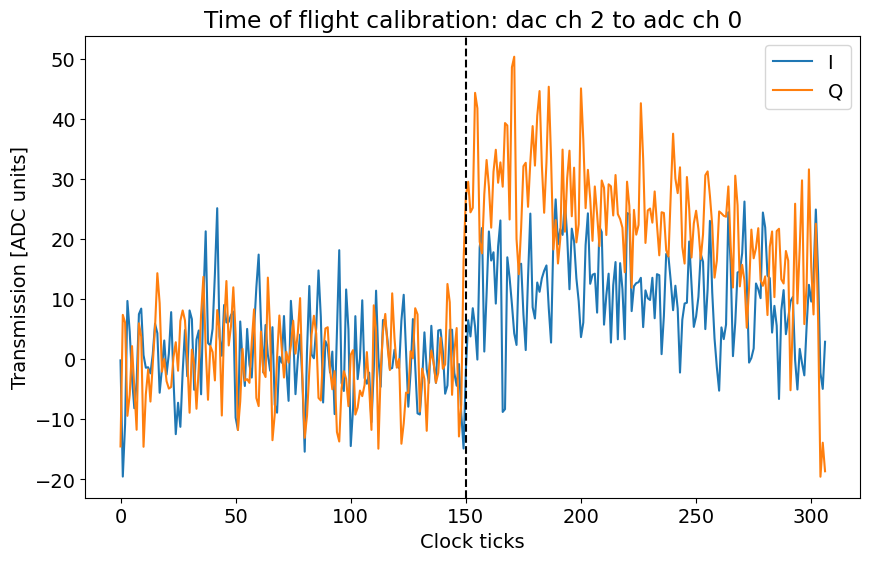

In [9]:
qubit_i = 0
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=results_config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=30000, # blast the power just for the RFSoC calibration
    # gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]

import Pyro4.util
try: 
    tof.go(analyze=False, display=False, progress=True, save=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

tof.display(adc_trig_offset=150) 

## Run the T1 with recalibration 

In [14]:
def run_continuous_t1(qubit_i):
    t1_cont = meas.T1Continuous(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_continuous_qubit{qubit_i}",
        config_file=results_config_path,
    )

    span = auto_cfg.device.qubit.T1[qubit_i]
    npts = 1

    t1_cont.cfg.expt = dict(
        start=span / npts,  # wait time [us]
        step=0,
        expts=npts,
        reps=  1000000, #1000000,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
    )

    t1_cont.go(analyze=False, display=False, progress=True, save=False)
    t1_raw_i = t1_cont.data['raw_i']
    t1_raw_q = t1_cont.data['raw_q']
    t1_amps = t1_cont.data['raw_amps']

    return t1_raw_i, t1_raw_q, t1_amps
pass

def run_t1_recalibration(qubit_i):
    t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_qubit{qubit_i}",
        config_file=results_config_path,
        )

    span = 600 
    npts = 100 #100

    t1.cfg.expt = dict(
        start=0,  # wait time [us]
        step=int(span / npts),
        expts=npts,
        reps= 100*5, #100*5,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
        length_scan=span,  # length of the scan in us
        num_saved_points=1,  # number of points to save for the T1 continuous scan
        )

    t1.go(analyze=False, display=False, progress=True, save=False)
    t1.analyze(fit=True)
    t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])
    t1_fit_i =t1.data['fit_avgi'][3]
    err_ratio_i = t1_err_i/t1_fit_i

    t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])
    t1_fit_q =t1.data['fit_avgq'][3]
    err_ratio_q = t1_err_q/t1_fit_q

    # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    if err_ratio_i< err_ratio_q:
        print('t1_i is better, saving T1_i to results cfg file') 
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_i)  # [DAC units]  

    else: 
        print('t1_q is better, saving t1_q to results cfg file')
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_q)  # [DAC units]  

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary
    
    t1_xpts = t1.data['xpts']
    t1_i = t1.data['avgi']
    t1_q = t1.data['avgq']
    t1_amp = t1.data['amps']
    t1_i_value = t1.data['fit_avgi'][3]
    t1_q_value = t1.data['fit_avgq'][3]
    t1_amp_value = t1.data['fit_amps'][3]
    t1_i_value_err = t1.data['fit_err_avgi'][3][3]
    t1_q_value_err = t1.data['fit_err_avgq'][3][3]
    t1_amp_value_err = t1.data['fit_err_amps'][3][3]

    return t1_xpts, t1_i, t1_q, t1_amp, t1_i_value, t1_q_value, t1_amp_value, t1_i_value_err, t1_q_value_err, t1_amp_value_err
pass

def run_single_shot(qubit_i):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file= results_config_path,
    )

    shot.cfg.expt = dict(
        reps=40000, #40000
        check_e = True, 
        check_f=False,
        qubit=0,
    )

    shot.go(analyze=False, display=False, progress=True, save=True)
    shot.analyze(verbose=False)

    rotation_angle = shot.data['angle']
    print(rotation_angle)
    threshold = shot.data['thresholds'][0]
    print(threshold)

    fidelity = shot.data['fids'][0]*100
    Ig = shot.data['Ig']
    Qg = shot.data['Qg']
    Ie = shot.data['Ie']
    Qe = shot.data['Qe']

     # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    auto_cfg.device.readout.phase[qubit_i] = float(rotation_angle) # degrees
    # auto_cfg.device.readout.threshold[qubit_i] = float(threshold) # [DAC units]

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    return rotation_angle, threshold, fidelity, Ig, Qg, Ie, Qe

def main():
    # Get the current date and time
    import datetime 
    from datetime import datetime
    
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the filename using the formatted date and time
    filename = os.path.join(data_path, f"{formatted_datetime}.h5")

    # Create an HDF5 file to save all the data
    hf = h5py.File(filename, 'a')

    if 't1_cont' not in hf:
        g1 = hf.create_group('t1_cont')
        # g1.create_dataset('time', data=np.array([]), maxshape=(None,))
        g1.create_dataset('i', data=np.array([]), maxshape=(None,))
        g1.create_dataset('q', data=np.array([]), maxshape=(None,))
        g1.create_dataset('amp', data=np.array([]), maxshape=(None,))

    if 't1_recal' not in hf:
        g2 = hf.create_group('t1_recal')
        g2.create_dataset('time', data = np.array([]), maxshape=(None,))
        g2.create_dataset('xpts', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value_err', data=np.array([]), maxshape=(None,))
    
    if 'single_shot' not in hf:
        g3 = hf.create_group('single_shot')
        g3.create_dataset('time', data = np.array([]), maxshape=(None,))
        g3.create_dataset('angle', data=np.array([]), maxshape=(None,))
        g3.create_dataset('threshold', data=np.array([]), maxshape=(None,))
        g3.create_dataset('fidelity', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Ig', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Qg', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Ie', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Qe', data=np.array([]), maxshape=(None,))

    qubit_i = 0
    # Initialize arrays
    t1_raw_i_data, t1_raw_q_data, t1_amps_data = np.array([]), np.array([]), np.array([])
    
    t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err= np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]) , np.array([])

    angle_recal, threshold_recal, fidelity_recal, Ig_recal, Qg_recal, Ie_recal, Qe_recal = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    start_time = timer()
    try:
        while True:
        
            t1_raw_i_data, t1_raw_q_data, t1_amps_data = run_continuous_t1(qubit_i)

            # Append new data to datasets
            hf['t1_cont/i'].resize((hf['t1_cont/i'].shape[0] + t1_raw_i_data.shape[0]), axis=0)
            hf['t1_cont/i'][-t1_raw_i_data.shape[0]:] = t1_raw_i_data

            hf['t1_cont/q'].resize((hf['t1_cont/q'].shape[0] + t1_raw_q_data.shape[0]), axis=0)
            hf['t1_cont/q'][-t1_raw_q_data.shape[0]:] = t1_raw_q_data

            hf['t1_cont/amp'].resize((hf['t1_cont/amp'].shape[0] + t1_amps_data.shape[0]), axis=0)
            hf['t1_cont/amp'][-t1_amps_data.shape[0]:] = t1_amps_data
           
            print('Continuous data appended to', filename)

            end_time = timer()

            if end_time - start_time >= 60*30: #60*30
                # now = datetime.now()
                # current_time = now.strftime("%H:%M:%S")
                # # current_time = current_time.encode('ascii','replace')

                # # Run the continuous T1 experiment
                # hf['t1_recal/time'].resize((hf['t1_recal/time'].shape[0] + 1), axis=0)
                # hf['t1_recal/time'][-1:] = current_datetime
                # current_time = time.time()
                # t1_time_recal_data = np.append(t1_time_recal_data, current_time)
                
                print(f"{end_time - start_time} seconds have passed. Running T1 recalibration.")

                # Run the T1 recalibration experiment
                t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err = run_t1_recalibration(qubit_i)

                print(t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data)

                # print(np.shape(t1_i_value_recal_data), np.shape(t1_q_value_recal_data), np.shape(t1_amp_value_recal_data))
                hf['t1_recal/time'].resize((hf['t1_recal/time'].shape[0] + 1), axis=0) 
                hf['t1_recal/time'][-1:] = time.time() 
                
                hf['t1_recal/xpts'].resize((hf['t1_recal/xpts'].shape[0] + t1_xpts_recal_data.shape[0]), axis=0)
                hf['t1_recal/xpts'][-t1_xpts_recal_data.shape[0]:] = t1_xpts_recal_data

                hf['t1_recal/i'].resize((hf['t1_recal/i'].shape[0] + t1_i_recal_data.shape[0]), axis=0)
                hf['t1_recal/i'][-t1_i_recal_data.shape[0]:] = t1_i_recal_data

                hf['t1_recal/q'].resize((hf['t1_recal/q'].shape[0] + t1_q_recal_data.shape[0]), axis=0)
                hf['t1_recal/q'][-t1_q_recal_data.shape[0]:] = t1_q_recal_data

                hf['t1_recal/amp'].resize((hf['t1_recal/amp'].shape[0] + t1_amp_recal_data.shape[0]), axis=0)
                hf['t1_recal/amp'][-t1_amp_recal_data.shape[0]:] = t1_amp_recal_data

                # T1 values for I, Q, and amp: 
                hf['t1_recal/i_value'].resize((hf['t1_recal/i_value'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value'][-1:] = t1_i_value_recal_data

                hf['t1_recal/q_value'].resize((hf['t1_recal/q_value'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value'][-1:] = t1_q_value_recal_data

                hf['t1_recal/amp_value'].resize((hf['t1_recal/amp_value'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value'][-1:] = t1_amp_value_recal_data

                # T1 errors for I, Q, and amp:  
                hf['t1_recal/i_value_err'].resize((hf['t1_recal/i_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value_err'][-1:] = t1_i_value_recal_data_err

                hf['t1_recal/q_value_err'].resize((hf['t1_recal/q_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value_err'][-1:] = t1_q_value_recal_data_err

                hf['t1_recal/amp_value_err'].resize((hf['t1_recal/amp_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value_err'][-1:] = t1_amp_value_recal_data_err

                # Run the single shot recalibration 
                angle_recal, threshold_recal, fidelity_recal, Ig_recal, Qg_recal, Ie_recal, Qe_recal  = run_single_shot(qubit_i)

                hf['single_shot/time'].resize((hf['single_shot/time'].shape[0] + 1), axis=0) 
                hf['single_shot/time'][-1:] = time.time() 
                hf['single_shot/angle'].resize((hf['single_shot/angle'].shape[0] + 1), axis=0)
                hf['single_shot/angle'][-1:] = angle_recal
                hf['single_shot/threshold'].resize((hf['single_shot/threshold'].shape[0] + 1), axis=0)
                hf['single_shot/threshold'][-1:] = threshold_recal
                hf['single_shot/fidelity'].resize((hf['single_shot/fidelity'].shape[0] + 1), axis=0)
                hf['single_shot/fidelity'][-1:] = fidelity_recal
                print('new anle, threshold, and fidelity', angle_recal, threshold_recal, fidelity_recal)
                
                # I and Q values for shots
                hf['single_shot/Ig'].resize((hf['single_shot/Ig'].shape[0] + Ig_recal.shape[0]), axis=0)
                hf['single_shot/Ig'][-Ig_recal.shape[0]:] = Ig_recal

                hf['single_shot/Qg'].resize((hf['single_shot/Qg'].shape[0] + Qg_recal.shape[0]), axis=0)
                hf['single_shot/Qg'][-Qg_recal.shape[0]:] = Qg_recal

                hf['single_shot/Ie'].resize((hf['single_shot/Ie'].shape[0] + Ie_recal.shape[0]), axis=0)
                hf['single_shot/Ie'][-Ie_recal.shape[0]:] = Ie_recal

                hf['single_shot/Qe'].resize((hf['single_shot/Qe'].shape[0] + Qe_recal.shape[0]), axis=0)
                hf['single_shot/Qe'][-Qe_recal.shape[0]:] = Qe_recal

                print('Recalibration data appended to', filename)
                start_time = timer()  # Reset the start time

    except KeyboardInterrupt:
        # If KeyboardInterrupt (Ctrl+C) is detected, close the HDF5 file
        hf.close()
        print("Program stopped. HDF5 file closed.")
 
if __name__ == "__main__":
    main()


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.5479680999997 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.85351163959018 168.43290917337586 159.22598415596858
using phase reset
<Pyro4.core.Proxy at 0x28b4287d5a0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00209_single_shot_qubit0.h5
-16.686338540450492
8.545817562988677
new anle, threshold, and fidelity -16.686338540450492 8.545817562988677 84.02460061501537
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.405422799995 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.02897631047942 125.88281138074096 113.56228259372612
using phase reset
<Pyro4.core.Proxy at 0x28b45a76080; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00210_single_shot_qubit0.h5
-12.937576499026823
8.457203006827596
new anle, threshold, and fidelity -12.937576499026823 8.457203006827596 83.52104401305016
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4337842999958 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.18520058453834 329.4361999213035 118.51858748757631
using phase reset
<Pyro4.core.Proxy at 0x28b45ad0ac0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00211_single_shot_qubit0.h5
-8.716473432174093
8.150951192177484
new anle, threshold, and fidelity -8.716473432174093 8.150951192177484 84.30710767769195
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.408737000005 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.90304367727447 155.14838949486338 138.7060217078447
using phase reset
<Pyro4.core.Proxy at 0x28b45ad3340; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00212_single_shot_qubit0.h5
-2.69496570478852
8.029268838156868
new anle, threshold, and fidelity -2.69496570478852 8.029268838156868 83.0020750518763
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4481037000005 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.62076904695374 229.74646229455058 145.00375075402633
using phase reset
<Pyro4.core.Proxy at 0x28b45d314e0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00213_single_shot_qubit0.h5
1.8022158842874612
7.922869287644804
new anle, threshold, and fidelity 1.8022158842874612 7.922869287644804 83.82104776309703
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4143525000036 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.17674217339506 153.2591090885335 121.6641969796563
using phase reset
<Pyro4.core.Proxy at 0x28b45d69780; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00214_single_shot_qubit0.h5
8.54695469814863
8.13008478584661
new anle, threshold, and fidelity 8.54695469814863 8.13008478584661 83.23354041925523
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4239486000006 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.51851207117315 190.81236138196806 140.2619387066786
using phase reset
<Pyro4.core.Proxy at 0x28b45da6560; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00215_single_shot_qubit0.h5
11.562542858329525
8.070236288388553
new anle, threshold, and fidelity 11.562542858329525 8.070236288388553 83.10103876298453
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4325788999995 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.0154652061243 258.82122494573923 160.55189960263627
using phase reset
<Pyro4.core.Proxy at 0x28b45da4c70; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00216_single_shot_qubit0.h5
13.74680461036758
7.8500762241300315
new anle, threshold, and fidelity 13.74680461036758 7.8500762241300315 83.60854510681384
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4075345999954 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.84103263939835 33472.54313665281 143.26341987289481
using phase reset
<Pyro4.core.Proxy at 0x28b45e129b0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00217_single_shot_qubit0.h5
12.783696105270932
7.627720085719433
new anle, threshold, and fidelity 12.783696105270932 7.627720085719433 81.65602070025876
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.401227800001 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.24997217725482 109.7696071839069 149.0515009183938
using phase reset
<Pyro4.core.Proxy at 0x28b45e13670; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00218_single_shot_qubit0.h5
9.793574099460933
8.026936952719375
new anle, threshold, and fidelity 9.793574099460933 8.026936952719375 82.91103638795485
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.403361600009 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.94136312438567 689.2785596474627 157.80924837178185
using phase reset
<Pyro4.core.Proxy at 0x28b45e12800; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00219_single_shot_qubit0.h5
8.144838836883624
8.003499122944847
new anle, threshold, and fidelity 8.144838836883624 8.003499122944847 83.17957948948724
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.372033300009 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.00524472479128 175.0820359651023 132.93244838530538
using phase reset
<Pyro4.core.Proxy at 0x28b45e57f70; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00220_single_shot_qubit0.h5
6.767213418228559
7.972052577264094
new anle, threshold, and fidelity 6.767213418228559 7.972052577264094 83.12811730439891
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.404152300005 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\experiments\fitting.py:65: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


t1_i is better, saving T1_i to results cfg file
133.74417258175504 135.64011689204946 132.9745399600199
using phase reset
<Pyro4.core.Proxy at 0x28b45e125f0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00221_single_shot_qubit0.h5
5.99387771288135
7.782677066838225
new anle, threshold, and fidelity 5.99387771288135 7.782677066838225 83.48813080490518
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4181151000084 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.83794147262296 87.17876967301088 153.79842782321106
using phase reset
<Pyro4.core.Proxy at 0x28b45e57f70; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00222_single_shot_qubit0.h5
5.874578483862119
8.048470625839503
new anle, threshold, and fidelity 5.874578483862119 8.048470625839503 83.37958448961224
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.3833879999875 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.86113640190473 178471.3143169138 144.19101049632985
using phase reset
<Pyro4.core.Proxy at 0x28b45e54e20; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00223_single_shot_qubit0.h5
5.2619162713308025
7.954227195402229
new anle, threshold, and fidelity 5.2619162713308025 7.954227195402229 82.34602932536657
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4167405999906 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.49646669209434 421.2777225154416 131.45905538455577
using phase reset
<Pyro4.core.Proxy at 0x28b45e55b40; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00224_single_shot_qubit0.h5
3.6198437547134867
7.786673750422734
new anle, threshold, and fidelity 3.6198437547134867 7.786673750422734 77.73347166839586
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4235415000003 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.05751665854038 73.67056793178864 154.2596940006472
using phase reset
<Pyro4.core.Proxy at 0x28b47003c40; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00225_single_shot_qubit0.h5
3.489348465054299
7.550826421286619
new anle, threshold, and fidelity 3.489348465054299 7.550826421286619 78.17195429885747
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.41866190001 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
58.9331963592794 5.515736667414146 58.83131847394155
using phase reset
<Pyro4.core.Proxy at 0x28b45e13610; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00226_single_shot_qubit0.h5
3.603398483196673
7.514451064554347
new anle, threshold, and fidelity 3.603398483196673 7.514451064554347 73.67842098026225
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.3939519999985 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.7800386697548 243985.98549838807 76.96759013682671
using phase reset
<Pyro4.core.Proxy at 0x28b47078880; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00227_single_shot_qubit0.h5
2.199695700498655
8.135433398533912
new anle, threshold, and fidelity 2.199695700498655 8.135433398533912 80.02850035625445
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.399719000008 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.80804016483873 158.55904500462515 138.98095918647175
using phase reset
<Pyro4.core.Proxy at 0x28b45e10670; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00228_single_shot_qubit0.h5
1.841952475789334
7.993276546226465
new anle, threshold, and fidelity 1.841952475789334 7.993276546226465 81.69352116901462
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.3944925000105 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
55.2805501694186 -10.951156945323078 54.37930977914691
using phase reset
<Pyro4.core.Proxy at 0x28b45e10970; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00229_single_shot_qubit0.h5
-0.024695852623475525
8.181372874245884
new anle, threshold, and fidelity -0.024695852623475525 8.181372874245884 82.7085338566732
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4013985000056 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.53488375541455 104.24575846147764 118.77084699778761
using phase reset
<Pyro4.core.Proxy at 0x28b45f17730; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00230_single_shot_qubit0.h5
0.4280911092834145
8.15785098346333
new anle, threshold, and fidelity 0.4280911092834145 8.15785098346333 83.07603845048062
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Program stopped. HDF5 file closed.


In [37]:
with open(results_config_file,'r') as file:
    auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

auto_cfg.device.readout.phase[qubit_i] = -7.844325608133489 # degrees
auto_cfg.device.readout.threshold[qubit_i] = 57.221847452942725 # [DAC units]

auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

# write it: 
with open('autocalibration_cfg.yml', 'w') as modified_file:
    modified_file.write(auto_cfg)
# now, open the modified file again 
with open('autocalibration_cfg.yml','r') as file:
    auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

In [11]:
import time
now = time.time()
readabel = datetime.fromtimestamp(now).isoformat()
print(readabel)

# 


2024-03-13T10:06:14.004350


## Just T1 

In [17]:

def run_t1_recalibration(qubit_i):
    t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_qubit{qubit_i}",
        config_file=results_config_path,
        )

    span = 600 
    npts = 100 #100

    t1.cfg.expt = dict(
        start=0,  # wait time [us]
        step=int(span / npts),
        expts=npts,
        reps= 100*5, #100*5,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
        length_scan=span,  # length of the scan in us
        num_saved_points=1,  # number of points to save for the T1 continuous scan
        )


    t1.go(analyze=False, display=False, progress=True, save=False)
    t1.analyze(fit=True)
    t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])
    t1_fit_i =t1.data['fit_avgi'][3]
    err_ratio_i = t1_err_i/t1_fit_i

    t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])
    t1_fit_q =t1.data['fit_avgq'][3]
    err_ratio_q = t1_err_q/t1_fit_q

    # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    if err_ratio_i< err_ratio_q:
        print('t1_i is better, saving T1_i to results cfg file') 
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_i)  # [DAC units]  

    else: 
        print('t1_q is better, saving t1_q to results cfg file')
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_q)  # [DAC units]  

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary
    
    t1_xpts = t1.data['xpts']
    t1_i = t1.data['avgi']
    t1_q = t1.data['avgq']
    t1_amp = t1.data['amps']
    t1_i_value = t1.data['fit_avgi'][3]
    t1_q_value = t1.data['fit_avgq'][3]
    t1_amp_value = t1.data['fit_amps'][3]
    t1_i_value_err = t1.data['fit_err_avgi'][3][3]
    t1_q_value_err = t1.data['fit_err_avgq'][3][3]
    t1_amp_value_err = t1.data['fit_err_amps'][3][3]

    return t1_xpts, t1_i, t1_q, t1_amp, t1_i_value, t1_q_value, t1_amp_value, t1_i_value_err, t1_q_value_err, t1_amp_value_err
pass


def main():
    # Get the current date and time
    import datetime 
    from datetime import datetime
    
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the filename using the formatted date and time
    filename = os.path.join(data_path, f"t1_full{formatted_datetime}.h5")

    # Create an HDF5 file to save all the data
    hf = h5py.File(filename, 'a')


    if 't1_recal' not in hf:
        g2 = hf.create_group('t1_recal')
        g2.create_dataset('time', data = np.array([]), maxshape=(None,))
        g2.create_dataset('xpts', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value_err', data=np.array([]), maxshape=(None,))
    
  

    qubit_i = 0
   
    t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err= np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]) , np.array([])

    try:
        while True:

            # Run the T1 recalibration experiment
            t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err = run_t1_recalibration(qubit_i)

            print(t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data)

            hf['t1_recal/time'].resize((hf['t1_recal/time'].shape[0] + 1), axis=0) 
            hf['t1_recal/time'][-1:] = time.time() 
            
            hf['t1_recal/xpts'].resize((hf['t1_recal/xpts'].shape[0] + t1_xpts_recal_data.shape[0]), axis=0)
            hf['t1_recal/xpts'][-t1_xpts_recal_data.shape[0]:] = t1_xpts_recal_data

            hf['t1_recal/i'].resize((hf['t1_recal/i'].shape[0] + t1_i_recal_data.shape[0]), axis=0)
            hf['t1_recal/i'][-t1_i_recal_data.shape[0]:] = t1_i_recal_data

            hf['t1_recal/q'].resize((hf['t1_recal/q'].shape[0] + t1_q_recal_data.shape[0]), axis=0)
            hf['t1_recal/q'][-t1_q_recal_data.shape[0]:] = t1_q_recal_data

            hf['t1_recal/amp'].resize((hf['t1_recal/amp'].shape[0] + t1_amp_recal_data.shape[0]), axis=0)
            hf['t1_recal/amp'][-t1_amp_recal_data.shape[0]:] = t1_amp_recal_data

            # T1 values for I, Q, and amp: 
            hf['t1_recal/i_value'].resize((hf['t1_recal/i_value'].shape[0] + 1), axis=0)
            hf['t1_recal/i_value'][-1:] = t1_i_value_recal_data

            hf['t1_recal/q_value'].resize((hf['t1_recal/q_value'].shape[0] + 1), axis=0)
            hf['t1_recal/q_value'][-1:] = t1_q_value_recal_data

            hf['t1_recal/amp_value'].resize((hf['t1_recal/amp_value'].shape[0] + 1), axis=0)
            hf['t1_recal/amp_value'][-1:] = t1_amp_value_recal_data

            # T1 errors for I, Q, and amp:  
            hf['t1_recal/i_value_err'].resize((hf['t1_recal/i_value_err'].shape[0] + 1), axis=0)
            hf['t1_recal/i_value_err'][-1:] = t1_i_value_recal_data_err

            hf['t1_recal/q_value_err'].resize((hf['t1_recal/q_value_err'].shape[0] + 1), axis=0)
            hf['t1_recal/q_value_err'][-1:] = t1_q_value_recal_data_err

            hf['t1_recal/amp_value_err'].resize((hf['t1_recal/amp_value_err'].shape[0] + 1), axis=0)
            hf['t1_recal/amp_value_err'][-1:] = t1_amp_value_recal_data_err

            print('Recalibration data appended to', filename)

    except KeyboardInterrupt:
        # If KeyboardInterrupt (Ctrl+C) is detected, close the HDF5 file
        hf.close()
        print("Program stopped. HDF5 file closed.")
 
if __name__ == "__main__":
    main()


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.3041346950973 63.435743805298436 142.4595095425275
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.5245602869279 15.11230509546565 115.51323892593288
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.38713800138837 144.07219609862207 164.85952302395944
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.30583911614426 286.53299311154694 138.72295443556834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.70940437444094 100.25205991881883 143.26818765146973
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.32773250294505 776.4472004717419 131.33929573316092
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.74017051075691 26.755022538692934 121.38043070499668
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.54907836341803 278182.2982921029 141.29128038079676
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.86352773245463 108.97664587873352 120.00509585049389
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.98740297139858 143.73042101848282 129.30214993524194
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.16034500476184 226.40363873185007 135.84626440020875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.56385478336662 42.150154636720345 168.31423702074832
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
134.5080939195133 -13.965435337715917 131.2258745811682
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.3679259905254 17.659927595526263 161.36690377740874
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.96405055304422 187.09099885686686 147.28013920562458
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.1467975636815 221.81567139394943 139.32379876765083
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.12703145758135 3.4636844838930934 133.23434588934612
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.227163468161 100.7663810118711 132.59059853771947
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.75384970490953 168.34227480476517 137.08838565624444
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.56527715439312 97.17552923271273 121.33061991367737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.6458928157679 70.5952354538883 137.43565724804586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.73721115573139 210.60319554860817 123.62679856525072
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.31539690006885 77.18073731254607 121.09756032826873
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.512155498867 342.8777789384899 138.3297715068512
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.2052464381797 234.28728698935143 138.35998496186588
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.74687736865013 109.73391221887393 138.2397089597267
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.99016483870395 98.18716497881783 167.0834632463053
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.2309485757923 178.8533118250044 158.76212225001214
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.65694084418757 191.72356147183027 169.16176638548137
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.46367161705666 97.88806259904877 146.36651815829717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.69756654395812 549.8526342672608 154.931015745262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.82265737911175 287.5238153480911 135.10643708048832
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.98260340061583 106.8783663261235 147.0469410559597
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.52551618863924 126.16854624449954 131.47966194099152
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.2080391340435 305.0147395314202 164.18625489237814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.36311608503078 190.59435192696213 156.3540194363027
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.40981127819725 106.72425473450944 131.51296141038537
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.73964668455615 117.73914913514209 125.11427159916913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.82302479835622 233.07868763141073 161.76627026300122
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.55075490449184 173.05142588887367 124.53586605051422
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.61597758432632 123.17928267656309 152.34337064581038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.9638441219634 63.39300644467452 139.7510406878676
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.70231673080096 121.07037415077352 168.09945327057923
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.02573571978746 144.6801756357196 169.51976755146887
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.88689108926832 118.59328735782506 160.15994324561424
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.27472816171465 119.55910115632625 159.65745294007226
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.77687920287607 259.77191854876196 158.26617695827775
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.46131637358837 145.36048776593935 152.0763680957669
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.39667898484385 151.29931884990864 158.78482414288163
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.31659370198614 117.04948718537018 169.57629899567667
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.90927940290027 173.13462252937012 165.36011150375194
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.312590408393 286.67133543517303 137.96751365280733
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.8859122015687 128.24173709308482 143.83110735525747
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.44304189415078 142.10590525569967 163.611387885219
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.98573570462617 195.13443196038745 150.0017687102232
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.3845679716077 165.3539307365274 142.14250871943483
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.97255597809297 159.61304802540343 140.80786677772812
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.94990934858671 139.76957993268 159.56467543201975
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.04634061519135 127.1028687333075 152.9155527758731
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.58226428578536 150.47661223960569 141.53735629781252
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
163.11964196948662 107.61525134225771 159.47412655241828
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.2791404991581 152.7938341295127 167.73816498039105
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.3305114400795 150.9567478522075 145.38317245442764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.79647939564595 145.16169944952355 149.81392032741024
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.97630633831298 136.52991244794993 148.72587812855045
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.06747159217892 88.85009727607122 122.18810616868723
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.5877413358788 118.64052388821612 149.72174006376113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.8015600739439 125.372281232773 129.77996664878782
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.56312508635548 210.10941634799664 186.1917434267702
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.3278845431045 326.41632877055565 187.60265485022393
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.76864786948028 207.18265779454586 178.45015494243242
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.65070566451993 101.35775541599553 164.19348307940396
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.71742065965992 223.39983084664124 191.04468942211454
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.13033356605928 223.9853186554871 145.00324960521985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.73043619925718 177.03471416340213 197.59399919878643
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
221.96252181255545 262.3578850646107 214.56163977699293
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
204.78744866998514 216.41379825418866 198.9090035471945
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.52984210878142 228.7047839261452 181.42696511288668
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.73815193065474 206.6710128824653 194.24458547605215
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.8170689017497 201.27134287282712 173.3463729872474
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.42913001811974 220.86010280457353 181.37938727113269
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
141.2777719645972 150.81696691740706 139.16881449400518
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.84369391906017 258.14360267168547 177.84802665935737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.67575001883515 198.3001446838529 183.70497678242137
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.09085406380717 176.06859533947346 144.14663134787304
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.4297181702875 170.98489822807124 196.82377446082955
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.71804696018282 172.5595461185864 171.1180819858895
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.50879668719116 208.94416733514313 180.00155671394296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.10407874324736 193.47289956802092 187.67993567623338
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
220.13041568840114 253.05361908815874 214.0478979898046
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.91608761585127 167.9213867321503 188.8546903346838
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.70341208703022 226.42298715116337 198.22976691180216
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.42587953759895 263.1159964698966 195.5619611925736
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.52986939292634 165.73682790558092 176.38450117757344
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.5120874178279 141.52114663959892 148.64376949904192
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.38779854848207 153.51284228716034 163.7842061983091
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.0374998421572 182.7161811841707 168.04481753102297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.44191604964624 229.65985078251006 189.74214185561027
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.77533244958147 174.93203030360164 162.38569052071168
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.8635800094802 190.18344236007164 173.44441439691542
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.48866505394506 234.32648867589205 168.34235498805685
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.78436505840014 209.91034313019756 157.00450476331145
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.44608035551306 226.43388958169768 189.98142826090557
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.4157291551469 147.83653604670172 174.33282126377225
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.42565783558717 179.51983698719405 197.31139744502508
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.684329318283 160.00382894454077 147.91418089442993
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.43984362171764 167.93841515207112 171.2460749155076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.6979133660593 107.26063894990193 109.94930515984252
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.98059031190704 169.20457523642864 162.7502986850252
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.8337765959957 187.44596373870078 168.7997668022909
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.04895631176163 171.79082751052272 164.50706575682796
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.10432941613536 133.45187540231058 143.89281567248074
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.5662030945273 137.09095662054546 165.81300625618144
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.0746027720953 144.87819096412218 146.5414026546066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.79900230121297 156.2874939673237 162.9077946602939
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.22310937291525 197.53804911444135 150.71755801674618
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.28785497837757 166.31147477863092 142.21369259698568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.45298923552346 137.07347590861258 156.31727729384485
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.88406538049176 145.31911931528202 157.63008497751287
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.53271744819634 179.0668040123664 180.76748610482872
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.00849887560122 225.197249485539 175.41659835605432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.20511636549153 167.5266816142681 172.00458733790506
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.58545650532605 172.13641252454175 162.17662519762985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.245894994801 151.915155272758 174.16551149726254
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.27024484918013 128.01864669672486 151.66907701584495
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.20539481165721 131.79789685473523 132.16193711420104
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.66145867557086 161.2829744157182 154.38775602354582
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.48224301967693 163.02473699308842 172.98837620377375
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.70255938925646 186.10460550794426 183.83329678424832
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.81751921974714 182.0497102471893 191.6104160486963
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.12806022739886 158.2336496257068 155.5973960800305
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.086593550241 117.36238761199441 138.68519603042358
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.05721734750057 172.53149056452756 174.26479507072656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.57056803528613 176.17968126093783 159.75779025159855
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.94028533144441 120.9491575162051 143.1652566852388
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.78079120833374 134.85216085785913 127.34278826889607
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.16221086038797 154.2639010671775 174.54597718993037
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.6435671616296 203.27043987490882 184.1872013712225
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.1488416510695 171.53360189915784 149.99833947262127
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.99338519499435 211.10099163794462 163.5855853202064
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.77354908313745 195.47498169848626 158.69013502518968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.70484272511928 160.9426902045061 158.0198748206272
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.4057307791182 161.1866657912199 147.1273734101793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.247391783992 143.88740239691413 174.47361326363853
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.8429353818577 154.52174093630296 156.95098167117675
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.4881140227794 128.39876554564012 148.0013195750828
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.81818118940203 157.48069463252773 155.2920251034703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.54321538606717 186.80928192606697 179.53367536534753
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.14486531472602 201.01814971107245 175.54089461317443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.96378284913274 215.76581555845954 182.5017211978873
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.28555843009437 164.26441035580675 163.0671103728228
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.033721026707 154.46849121658468 147.80459616059395
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.4157961554834 158.41466193712978 150.9724420476906
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.0583752195824 197.03731958494265 150.6760669332816
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.40198800396143 158.20196297242654 191.67789464184068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.61226229434163 274.6415161012721 175.59637218109222
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.59818151262957 163.44884459919749 155.62726208418113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.37663321651215 169.25085915379785 145.4998068970124
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.90210157817498 157.08353433937478 175.531558593079
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.6802238429618 148.0810943515383 153.15139843800705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.2038290728588 195.25291667308818 166.19136724687795
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.73780976270837 121.97923350286526 143.9576452691615
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.57663396430638 168.01600354168121 169.809377563251
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.49406746259424 177.83701766700824 169.31476413586958
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.2552488375735 192.9289214479473 172.6304446184055
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.4336533012162 193.2177181572778 166.8733848180972
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.76282600747297 159.14898609696604 171.83216235326523
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.54410105923844 159.83558609055947 145.69119052769818
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.80366697720603 151.1750145972777 158.3625281949565
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.53953861704852 178.74315833577893 175.7473826335679
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.62631365484577 159.64402088596898 165.2700655647804
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.2678991360923 136.82193754099958 139.27065753621324
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.33766913704446 149.09408327946204 151.59448032715113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.05182374191324 177.7620521827004 170.92466728261545
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.63327039426179 184.62780777873516 162.55575382969207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.7448993643661 178.4648612380014 186.17241344781834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.86269702484546 159.4983524168889 179.4169277511246
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.71785208581025 173.56698321953252 163.4572215737878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.9654051659235 184.8114506313097 157.13984072508097
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.51889887154286 146.35348269908707 132.86269289734707
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.1621840051235 159.7352934582969 143.8622054328436
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.7865604141626 156.7088368723879 160.8385118126369
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.0313633710066 177.39627779521712 181.55966950329508
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.73881671816142 206.44885969687238 198.87667549186614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.39550247506654 153.296713981055 167.010304353045
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.13263452346433 179.7337623316871 185.15679426202144
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.69352227829305 138.58704663632108 150.24749367602521
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.2963397967765 154.3229504246296 156.51308094861864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.9094422201124 148.84718281453655 166.90872021010443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.50046438373096 188.66736338201184 158.20504655093944
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.83572716980962 175.63390839256166 181.56878844988105
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.7511994259239 199.41726320812685 188.82681899642316
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.30219392419966 155.77025014902017 166.48245408406655
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.071313618546 185.03673102924188 165.73069882985925
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.4692976467017 197.25972871221862 154.03051608730496
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.21519124975154 119.87172744980951 131.3994206155736
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.0152150154518 165.42173587522095 181.24416692876719
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.7864940705027 160.34857280724225 172.72457767269884
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.32852896253337 133.77432154903167 159.90246634467422
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.35312657890523 142.00988704451595 139.6183536265185
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.12442182846493 125.82696685223956 139.68373244048473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.9627511453892 146.87654216127314 152.86327873927098
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.15328617518983 144.21884127763363 149.78407058544488
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.6162572745063 158.17318383007634 180.9592822042891
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.2908341948831 182.2503314271826 171.1826932704144
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.19479116031735 197.3008934056083 181.5526119723878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.72056145660858 191.39766475132353 171.9251990229699
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.05013971847987 179.53990845437184 168.85651596945561
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.05705606051907 235.23258927139713 192.39030474372458
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.20485700640057 198.05210657736453 180.9351886739639
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.32410415368156 189.83816887496513 186.98420798515932
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.7083614311177 142.45497415639684 144.64937895446917
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
222.70964492361787 243.07950387955813 213.68902737325175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.0025804838083 194.93267406159737 184.11459278835218
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.4430318397931 173.8165902215627 158.8136509343285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.55805489953167 132.20790945158595 122.53339264262947
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.44248612278295 170.5102304622605 137.1753904380604
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.54645530558795 159.17005308143482 165.35822013629232
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.02573989942027 169.13036320360274 178.96791384495887
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.28358004061724 166.62745258100395 171.2303126618717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.0583670842611 170.8531087848412 153.63789548568576
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.83029199692416 147.06794370440105 137.07785634836176
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.50398145337488 167.92856411097958 152.10126267953882
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
221.1598839155327 206.5568991530009 212.76109165807873
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.60788308855214 177.4412828282886 182.09145068025052
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.87607200887095 126.2502775876506 131.4346511392562
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.99293337167913 238.0831469068242 176.91805468778315
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.75431059357004 170.0031632088333 155.2155383503484
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.5556825557832 169.15534057376286 148.92549655230417
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.76709208752925 178.5820541653063 196.873376272864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.1172985923206 151.44616143271915 147.71634661234694
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.31013477660576 150.09030079646186 153.49942140662344
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.8158699018734 184.70632820048777 156.6603007292961
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.20979598780355 146.61052607527566 156.61278281293062
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.55063189614623 179.59600736730687 174.063480763691
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.58483510532648 177.91579895240483 184.9016168557993
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.84844627927194 202.01015332908548 168.85966024874588
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.8171270114928 172.0320108884773 184.30527049913007
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.04043138784468 188.3551563967461 169.27968182901068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
173.1050876634099 176.08680460660014 168.54252655681674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.5735070277729 181.48845824037863 171.42726123611462
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.9428379880203 174.7003950400439 187.8651343677351
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.98388011680632 172.78207549979783 164.22053312819318
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.16015240638427 202.33197888912704 168.03420120468144
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.8029744040393 162.727466061361 168.14324268297884
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.72621936222984 193.81637400265566 163.16820062236164
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.33122119137153 180.3644289447936 174.06655960129717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.26541543249127 176.69829043536893 139.3362013103239
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.64694155168354 154.84146499756022 149.61875201605875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.6758283538919 174.3207975870478 158.84800881105554
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.97276377994433 129.81523165720267 132.73676841072634
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.93501406566264 180.26624749607217 174.05974231126112
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.24536526519924 158.31538444068943 169.29295995020357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.02880584118367 193.8278646829685 188.44515296450362
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.83962320550611 153.0557873576055 164.52024550260978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
216.3041056288271 213.1672659527027 211.3551980786118
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.03089787111367 186.30373242648938 185.71492403197175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
232.57130545318878 274.5679299342106 224.15127716637025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.69188599323584 197.68278736559648 196.26383520095328
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.28838329067239 167.8827567452421 193.53789921790394
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.77716766290308 154.43048799128718 174.0740412079519
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
232.48040608177152 258.4789768464153 226.51545160310897
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
225.20393885435317 249.70817020402652 218.8594466134553
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
223.74145900444833 229.9061008354262 215.71827435837227
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
211.90649536630443 219.51030499762427 205.23441725531794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.02762834364918 220.01664817486733 186.78090829792006
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
213.45768670706465 213.11236298855104 208.06005455350834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.60420139204678 175.85183972451307 193.57300474944154
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.78887630436338 156.28320824744296 181.9769815286015
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.59857297193162 176.85944758604288 164.1786757699682
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
239.5087721812017 276.9907403500954 233.78623760749701
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.73583624972528 204.5713398627159 195.86256592070114
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
220.5783140394368 189.33269901267136 213.8882067414763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.84668028663404 137.0478454278994 158.58035226131364
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.19497501018665 196.71625903941657 177.95083874659719
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.98995266003425 209.36691387852795 169.62213711087918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.04439246223998 192.32552791905744 181.8651526401998
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.8223681553676 173.75617771719715 174.6980441623876
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.53105078352021 215.78067879525315 191.01481211432997
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
214.7008694730157 190.56780048888717 209.63489972374808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.2194893658519 162.31888657852434 141.8404870621207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.47469007835184 108.12183627505777 114.86285157944486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.73796406153718 161.95255561286194 168.29664745337607
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.27410520316457 153.73074850029556 156.66954747252092
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.11834686716054 169.7100871223626 140.13446989295483
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.20392157885095 162.10223033673608 153.83981142276568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.35774362003886 122.14029877503773 131.63697647165998
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.18225018258522 206.79985650620674 178.49923507000005
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.87585186007453 153.1717299203839 152.32635132422524
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.33594362376382 129.8216502278896 134.2935517149278
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.95716373943017 161.96611655595362 137.1245887230286
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.48979135325217 148.25667130398816 140.4950799996967
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.01867273507315 157.26984225396848 151.3474585586493
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.40592340542509 193.04859480749403 158.58479472238304
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.3510573420258 169.417366594946 152.35997760627305
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
270.4245934099605 320.4479009220819 262.4355663038531
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
230.64819887340997 242.35760900643874 226.27449636255443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
214.6266984828753 195.39192473216292 208.80980521706226
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.14951401836103 219.71887485977504 200.88328613410138
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
230.03017833687898 220.71782428309197 225.34097627712111
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.16261482710775 132.25924415317934 129.7034249993036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.495413781904 182.86640346367156 180.03290175421117
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
224.78027158703472 221.31210176063965 218.87037925980167
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
236.45321542968756 248.84798147976903 230.03846903489637
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.77809616046113 191.14821157285004 193.0453043919062
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.22293886264674 176.64609298393202 192.4328932769884
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.46119160063003 189.62744922994358 176.4473226657742
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.18782620052716 144.72536781532258 148.82287508981878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.4949407837078 176.35090796647853 162.33593255019622
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.83731097091604 175.368684141194 179.38110547158908
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.82646539246588 122.4108762262236 125.97363574980317
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.48422234577185 144.02175321678016 148.15431611560027
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.50873657971653 171.61789445545634 162.93145817912273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.9110076848293 214.71975032708295 185.407984504167
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.33626425945772 185.49626219520258 188.4351004835529
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
213.21519683583617 213.78605608372726 208.5854371685415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.43772719461694 189.2842545576749 198.05484118591136
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.05416727201225 164.1661235438365 178.861923182513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.47960773586166 197.11225536767083 178.954927036469
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.35982503803618 197.0222253225346 186.86633716824022
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.73365806179736 119.74406203661404 102.6068654690837
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
220.63941149047164 205.99785884046565 214.06941129030028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.08340507925016 160.54931282767788 158.00346182532093
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.09423391601243 173.4861148053965 168.74573276237018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.93599050054448 198.98802802046572 185.96466436588304
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.33366107932451 170.16662349447046 156.18739691615824
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
205.777315006531 231.76381350029848 200.07646288707994
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
104.82351424353418 97.27733008355699 102.17787628184622
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
227.78431833324728 241.1273780888574 220.42380384989198
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.49514595032528 183.16273510727166 173.79885372049642
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.35502719380895 219.9523278789239 177.61249025995357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.90454272714655 188.95714042401713 163.95752755149832
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.80049269604265 162.08458522280148 161.22202894751405
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.8018782847606 150.28858900041476 164.05929471734018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.352697490578 169.57319545362733 173.73103821370262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
216.29856216256124 217.94762017403667 210.53756108632754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
208.43534270075685 186.19539335550107 202.6889347242308
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.68696597541333 170.26445957919097 175.51384491226406
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.14602922162484 192.9085463343468 180.8089785920145
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.87839799747505 165.17185854560594 171.87842577298548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.56747412556746 147.2583331878379 148.64084137926852
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.48603268171223 144.72328534054185 152.1948495171406
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
222.23480561624984 200.83809179779055 215.5416803900791
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
235.64057774886146 219.68820000008606 228.4518050187205
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.07714975220082 224.9663961257246 200.13020682222356
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.78833475210118 181.27162649960732 161.36762501036725
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.4258554680138 149.8577731602171 137.98175625394026
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.94136683243272 133.56972545183356 143.7107963827579
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.6278722090238 127.1228624953471 133.68151896340703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.1358154692572 140.51545107543143 162.0106832483386
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.70825693608927 148.62018477321578 156.46003332763846
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.45195735058131 101.59828465512628 120.77533134778352
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.5076486713692 174.04534864024768 143.90558836716806
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.94085878250232 191.65180248541307 193.8420948200443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.56391021518544 200.94551968127698 188.2241446426267
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.60751177520584 111.93243651761998 123.00091495234531
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.32351541205412 219.12189586333895 187.3569932490991
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.97568740513205 170.31816322212916 153.4495260643478
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.05159340101935 180.7117093116944 156.95026806022318
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.28934806426432 184.21682013306187 173.87742488896663
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
212.34441447835653 201.68078680190396 207.4315859448249
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.86161258447422 154.6529715511626 145.0417704532419
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.3322846866733 187.61084919614154 192.4656849305709
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.2109780790434 138.0661010706535 137.92577912083544
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.81750158488654 167.35582948923133 129.20512900118487
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.67282390821183 190.57267122032522 197.01509771067927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.59838947752112 99.27425736750176 87.10512721470035
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.07135269917012 184.42613559926053 175.62640216943734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.33555707300022 164.36850618766647 159.27903111968476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.70205553980207 160.4732461514691 162.50671036876426
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.0455944521268 152.38430464426492 161.40982871992222
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.8977829795869 100.77498024237589 108.57592561157925
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.3595251082474 146.2410873978511 169.11180664139854
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.39917629547747 177.4869804059051 168.18803785451684
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.2913772700757 146.17397276078603 140.83357266988023
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.23747906665884 116.76172446161384 138.2292931530236
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.87909889755068 144.13284485923776 144.82429734610844
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.72409623147283 155.11676699435472 162.26497395204584
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.68470777151728 176.31729554156058 170.97643759825795
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.82298400985172 167.34805556815786 161.3694649160094
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.87548494279503 163.93948447060222 150.65934233486647
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.59982015110873 175.39394827021496 174.35050171555372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.76147619437234 187.4932992750098 182.43738857976905
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.08953500294241 112.04115363417209 116.10575169476843
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.52603616715196 83.55496918051263 81.26108512922366
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.73482076721226 115.73228853853198 129.9639606538695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.14830351242315 189.27809198848482 163.36126212563374
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.49902163849947 132.69558267445797 127.25380667443507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.53967916618873 137.82732242275551 119.58839743183371
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.1502087078389 169.0183534943642 153.47291792025618
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.31891782213347 150.2611331196403 154.86856665795918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.65531103694843 138.7613785851652 120.23711541114564
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.33747917341904 177.9862445361663 160.17393255446032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.77982732490824 152.20950761807967 147.67453068719468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.58561294820254 136.01271574273107 125.99830959609898
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.14701791791228 142.3092256439454 130.40875513737103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.12025638452548 184.8648225983751 160.32637152950164
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.80057930831985 135.24455838791786 101.3612461726949
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.63175056754932 143.43650592899323 143.17955903648695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.94254129101537 141.31441993414785 132.40922266479444
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.77737604876702 167.38685508968246 161.9526917647759
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
181.66182203451427 213.3354094810199 176.74942906651467
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.91617928076398 124.32695331676588 111.87890671758652
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.77319910754264 144.39160653750295 162.1954498656366
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.43573353992093 101.51401055763343 105.89788547063606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.7272835248374 135.66104781479527 134.41191809367405
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.14033108935654 114.1213012591106 103.7286025038121
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.2298824787052 101.8500730957987 102.82870381502993
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.69779153287708 112.01883475646574 117.40526317544203
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.3580165584193 132.11030353216893 136.59934677550172
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.61795705462578 110.45369775871427 111.57319521457686
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.34477727934032 114.59270227960374 111.38188382966376
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.16972255883536 97.84165356934103 98.20659588999521
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.17317911037905 118.51761378057891 116.07040948717177
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.96861213848227 109.77321194192734 100.02130301024864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.68878734218158 119.02856584420338 107.5885579713293
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.21223233911172 132.74084625897763 129.27627897114218
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.42608075469121 127.2973830000572 118.71127107603851
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.4182298436186 115.80618632189497 113.37885748694413
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.848993469674 142.2067683233004 120.85176857599099
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.01903257462452 130.48788455288678 118.54719598794284
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.816044306215 111.68154813242057 102.67853907588962
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.4788751625495 126.03238236945296 131.5329787970812
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.97946488394756 106.01629937846795 106.04197539931788
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.58891324723344 83.60487596972195 86.55301129020623
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.91993988576999 112.58025813090406 90.50012229355745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.52739387382613 106.03162098497937 110.44490438823071
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.06583319566188 142.4978341852538 114.61453165136002
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.18871274846992 127.76818312139737 130.57539340397315
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.44413902507273 115.0543765186553 119.15560632394845
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.9567403523059 120.6877567169968 110.57973591784629
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.64533279827153 98.83587525502749 105.73950079607503
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.8011761320292 94.37083353480354 95.8567052178924
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.04136608906947 119.4458663339067 108.78046773515207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.7387953629915 135.13047414484345 124.70558124118882
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.61544008850831 101.21303935072712 97.1178574252243
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.04961037621838 95.11443492055264 96.10069536678671
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.11850767406746 74.9133201704702 80.85961663189165
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.22537728019202 148.529637620085 137.67258060435452
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.6124747335323 122.89162866586591 124.91740143661156
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.4388253726401 100.02816341390204 99.47238751973828
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.54187700173723 96.15425761654228 97.49359829399467
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.77922230828337 91.35275670634975 92.36560508684215
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.72933302426688 116.39402115291259 114.34138300950067
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
103.57979221237915 109.54240797867791 100.80257504522348
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.03893655069065 122.69849363388231 113.95197621473353
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.51300912459021 103.28628010325787 105.66632924576608
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.02511024672349 74.96647711971454 85.3393073624579
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.69433682099103 101.79819874671665 84.2225146502978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.62311203527459 74.78686260998312 70.81540235055579
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.71179397688014 108.84298189974301 100.5117224777807
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.40478343929108 99.78228885134709 114.34200922579687
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.31759404676781 121.60332451135902 100.03338933418948
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.7231214093622 148.73978510728452 162.17026168067224
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.1439931355931 167.09127301894566 143.8096285554882
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.14408269620245 123.36987627584891 115.48920536700712
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.1230693460989 186.60109453411252 157.41282396593314
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.05131712262843 153.08591698597604 144.54756727551387
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.28094098078915 229.65630853813343 194.32860463615006
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.9317980582543 173.0065043620922 153.6639776342216
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.87983276667143 180.96010725026758 177.23868358439617
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.84555453928157 104.04292631072684 91.34337291071407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.10177282103862 155.7939689638631 138.0471496189235
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.32521811821965 156.20801024696277 138.1607400992725
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.20314296364015 222.40146426549236 195.13096958086476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.30851836128 121.04254776959104 122.51735702975992
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.7174069134736 136.33945695536704 129.29225960603551
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.66961376143885 193.09409426345877 167.28461274975774
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.81468272465924 111.59162700577964 118.46436477969142
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.99843725939377 111.25090236604699 102.57122112105614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.16919875086853 132.38059408345683 148.2035649344066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.09736564158686 132.9003847665668 154.1224974663748
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.72198677799075 115.7086299426549 119.21197693569495
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.20002605755425 148.5659368609112 152.71241604672366
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.76537965672496 115.14769147076984 115.64374236224764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.9670920764252 172.49260400063392 169.99944766041403
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.6257468730707 159.99579719815674 168.52743184529103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.78999429045018 125.04339568366973 150.463891744347
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
247.0502197284476 259.176279968881 235.90876601309546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.66390463000262 116.17374573996051 108.67224497064835
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.48176828180354 141.34640781076345 138.84047243233323
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.91751144641754 183.6938065036884 170.6796803492197
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.65054015436314 127.25738285632355 110.51283376326072
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.65381447877508 90.69304055465408 91.37320877876698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.81140035364587 132.6474985678714 129.58136431600377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.07308584656701 81.62817579846873 91.616505309507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.98272707119253 176.81732036111177 149.74752287438008
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.9072340028897 172.77757305344537 152.9414900294656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.75786228177749 127.4180538595722 114.33324473840898
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.89823726432238 126.05097489153711 130.51503231122328
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.78461072140925 127.38852183208763 136.14019745739915
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.11280795887996 124.79959844251749 148.93407787305946
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.04253075496206 177.6396541164638 154.3572342949678
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.25688819853272 144.2093203070262 152.07020353557732
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.31278487782419 164.26407257416452 129.0733119256061
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.93016122183099 168.40299306950945 165.71465390686708
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.65729300472402 114.50185883081845 108.08223161504861
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.77996698817188 119.45047191201931 123.28922584737936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.36526450174492 132.3631812937736 113.50041951717209
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.30960473621953 98.2074633673025 103.78623899705332
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.53043816222014 116.71133683709131 125.32646893931098
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.90652458959285 145.09561280766715 124.96953601731035
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
188.4844382476544 215.50499671056218 180.83441306090924
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
151.7964620782005 147.98019508375103 146.9126698220764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.15046478369544 234.47599222154042 185.97563798737778
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.4793175628901 121.69658616030749 114.40188396648902
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.2554669070315 76.07642473088963 85.19218548815202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.3045076759434 134.39445446722723 148.90025179757
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.41144921960614 170.02451846710255 157.01821114217674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
146.10190722385073 140.65059784172803 142.6255571728158
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.3596478355244 162.38750018989796 159.0055842943891
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.70423837280258 128.48932646150502 123.04947901830819
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.78818952957826 154.25654664556987 166.98996235657623
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.60579344304088 149.87851879392375 144.87510077221944
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.42020099512328 134.64416484463587 126.75933116038674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.91886105051358 160.27669333186577 144.57309102881544
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.43155406147 162.64100812697828 146.82182591916043
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.27127089399708 119.62692336356778 120.96647393129915
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.9788650902816 188.13571239548722 166.85755895647372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.74932723168017 109.02299466200394 111.91928296272027
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.03565178067429 113.1776303506846 109.37743735131703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.65142450264023 89.84707428303298 97.5498245406016
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
234.27472534509414 213.69421136315893 228.41116313593415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.42826960566654 173.04092994399505 185.95067715428192
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.07486088171925 152.71819370135162 158.71084072131794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.2176733675606 136.51846763565356 154.8269902645071
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
204.68635845474887 217.33070645302385 199.7014047111461
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.73403737674093 170.5992942404926 152.89380197361527
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.4489682385468 129.67139991948528 132.57632083118133
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.03584771429495 116.59659209089274 121.51136572958913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.14930922319925 188.99290238348735 163.59093478386544
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
161.7942392702821 202.58522724324638 156.7543039001488
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.82825048694468 129.9118943317678 137.44921255322646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.50166303927887 236.5799515772035 171.74727857571582
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.08859821464335 155.03178056430656 160.64401732769664
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.00881184686335 221.3550789276779 198.19317134014454
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.2348820389531 190.23155760993228 160.59404346338255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.2621197891146 226.9222530389994 180.84646938272195
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.70229425429736 187.97897541939128 172.82181973360036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.21471988452723 211.51251917300183 181.50358124871423
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
224.31565035601835 182.5134039312018 216.8334773243835
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.22213566828663 208.8464348122484 166.78508183477797
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.65733827441176 247.13443283291517 193.54982042485406
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.0447852780784 238.5330547866952 178.2553088375621
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.29912129168909 136.3875371600932 119.67963077328976
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
212.7783141127101 197.94930637913356 203.6315095013453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.46237554867739 125.66002416267072 112.29031154341517
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.3089499327987 199.51126773800112 161.28734016939407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.99675423745546 149.34795306698413 145.07253840008
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.00155135892302 141.4410179409659 134.15951956113798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.40045379065725 161.8414504661975 194.2119370563174
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.48192945792525 153.11144163169342 169.94483234625469
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.97779601876402 178.2634143703414 164.21152257999108
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
151.37936634467292 174.5297636902383 148.04643970327234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.69492546795314 166.48083455285953 172.7996029789412
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.567804268369 166.94674553775855 148.4546668690794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.21098974151852 133.40233088550116 141.64632008476391
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.27419691300136 189.50336061184709 165.19189067415655
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.77096625825524 207.95192730851255 168.18458694207385
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.1885949371564 106.03490560552407 122.12266417947286
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.3943245844907 272.2767337740208 174.4007302709239
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.3257890449123 169.58503461557672 133.58985467571787
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.60119560177785 201.96936403931593 175.2473455819871
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
204.795544153694 172.09941991308764 198.87904367587782
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.8303167278667 159.54401993393245 163.95241050808025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.16591884092534 145.64466724788298 146.99347284254927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.0308036548619 186.86465442361896 166.32560608693834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.89027535251648 154.75292175297346 168.9791931166575
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.18394500753116 73.06270688589464 84.13045336905853
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.67373504940943 180.47892922254874 175.8133173650875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.31105625687356 157.79091042872093 113.22124757511855
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.90950480883689 214.38372058969426 194.62960321074468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.6658347742154 186.83993104756837 175.15446593951927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.07881646982736 151.66428962538035 148.07425584871072
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.97694112232188 248.3382964393385 161.61375074451698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.82198440530888 161.27594014488142 187.13511679285043
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.82189063704675 208.92954778572826 169.6130816936345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.44124790688213 181.53069047041072 165.1605764026389
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.66992648621599 135.36590205424434 168.74745830669764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.40517084849517 126.97082495458086 142.31315660011606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.1316810723894 171.4702385799497 164.14548293867887
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.8305612420172 192.38219298169105 171.36595551496308
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.31870110824863 141.2971158801726 146.93345305194217
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.27297523072843 120.2309504948623 132.599326382193
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.70680974005523 117.85253750740647 148.7390849131387
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.12831278090678 144.44074486266126 141.16943031351855
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.14662734708008 146.38706470983203 191.7030162051922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.80461674653012 163.0223326755314 173.54318086003587
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
218.64437137904414 166.92112090568446 213.99332210574818
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.39058898421644 157.80694901943212 169.9652000058098
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.7501682720677 163.00545427592726 180.11045684503685
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.57715541296497 149.80930446036984 167.93472189374643
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
223.76684938343394 214.1946625402258 216.29313645178857
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.83738126852262 205.9283527563707 177.07337366517646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.79316555756802 191.96557353898882 163.86509500402954
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.95094828753268 102.5952007073135 122.29299042931031
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.4779999410287 150.15684793997895 145.27418290600633
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
215.18323117244287 174.01390950009633 209.81718729720532
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.87723157064417 151.35538334589688 157.04701694834262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.33689490468382 159.26998911218547 151.33629758203372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.21841363713784 139.62625981033747 171.78216231294266
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.71123555692378 181.25510593433086 186.14875566263922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.30145759140137 167.34561298165178 190.45031954812913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.60878816120135 181.57804679395682 165.9409370986858
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.29625490701005 182.42118090024888 169.12875842796998
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
200.55808234537585 205.5252124921227 193.15027204405575
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.601430638349 161.4413505489801 181.63190397285078
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.44255227204195 142.74675363761077 161.15122144817394
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.89502299808467 185.49425321022372 172.58313947170092
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.43667194580277 184.49461086063624 180.229131183572
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.31993346093589 172.34697476786388 159.16303409907377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.25847692827705 148.28264632013662 165.91531829276613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.3221525250388 180.1992954435928 193.94744698361794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.28879660689822 171.89722453960994 156.46757828644763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.50202951341655 221.69581960329165 182.97554885934463
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.61276125893426 193.5474960362991 188.38532369188044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.15456045585353 168.08648813697212 156.60095125268825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.54398152336418 146.62979218369006 153.4796144979297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.00335779405253 176.76461598943098 164.68416511618184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.27476808264194 173.8650862385348 178.1007516618004
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.55337889141646 137.6156262389798 145.40315897260226
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.2174469258277 163.41623178051927 144.78215812556664
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.0439324792055 140.22914275976473 141.33340689049066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.50838433994122 168.60226794189336 148.89115711440868
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.25533570824715 154.33318281861298 192.0950977538545
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.40694271111835 170.62962093646036 162.49523602232335
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.86834873785759 70.80244774462862 107.44507856672196
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.61727962719111 99.42075522212077 109.09979716666656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
156.8050046553764 200.3527668392275 150.4069185048859
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.5472533188062 162.16703405118682 141.88526771083588
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.55267823634745 124.40368896651368 152.3392041857781
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.1800489049748 173.81324795878155 148.34020965647443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.15964129598404 130.8444107954937 134.35840187403542
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.092578756946 97.76578837509521 109.45152500215163
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.21016929595726 131.64570564266145 134.48188951034322
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.75672973253694 190.9691845407508 181.09329081104642
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.84897339585018 146.14998655202535 157.32342246582814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.97162987383908 177.5767463029948 146.05578870628918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.1955793011901 120.0022806165989 137.1730614542378
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.69911761024144 121.73642392879609 146.652856591491
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.01065696797252 181.35326253141392 130.03918040427882
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.64350463697798 154.9614755283548 136.99922672545296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.40020125909743 148.52685520082503 153.16128003784178
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.64397833108868 134.21889498526608 163.94979854857584
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.0842659593248 186.22128463778873 161.60190003902508
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.6335094139035 160.9407266086868 159.88592187131295
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.59294615518036 147.5244184180402 153.64600447831552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.51994049871016 198.34116174004478 169.3764742120861
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.66069752518936 152.15605107575624 158.6783369754741
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.66693652380906 148.93510625424116 151.89139983475303
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.834817766741 116.4893123841539 141.71624545629751
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.18322528019596 208.0470605158929 168.82670210961066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.0042574799273 146.6141716913443 144.49452169607767
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.60284695624884 138.63965027454466 148.6193231786237
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.638507331944 164.9727609766959 172.18527130371538
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.1056275617365 130.39644910501573 104.1229047485442
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.18774301306837 214.51867130037778 154.3696529187674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.10347151451117 119.95473914535188 151.4762708219916
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.64227245477878 154.90653030355804 172.17849979907942
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.76800785277013 158.16018257552975 152.84395528016867
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.29843380833444 216.915333070139 173.46527111438294
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.90255437791265 138.6131404642376 144.6641241120771
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.67671886219566 166.54876992734884 156.6292958407477
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.32107934723743 257.4207510779727 165.1423935967861
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.5553024091341 172.8341462477937 150.6329206359876
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.4495132802526 120.10939458880975 163.52958532977195
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.86084397191033 148.5325517324067 126.80572094705133
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.3609553260732 182.2912278297132 175.74094773401245
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.6132834239878 118.21824466419906 130.5720540806036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.43997826955137 111.18662974878032 117.91700784105043
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.52902066694256 87.18628049762299 108.03392945058845
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.69604228752252 151.91813641848458 138.7788898570867
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.4458298111511 164.61357818864596 154.63252181578326
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.36491882047642 151.34619712929478 167.7479588343418
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.47933970071446 110.67234061466571 146.74760064246706
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.36083903257418 125.763137220416 176.26224580435266
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.17566570336655 158.951880452036 156.96324825072907
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.0584567734373 80.22321149505497 99.53574259100263
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.90024427839245 128.43820707304883 125.10337808463373
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.8691905546398 115.38361588102597 147.58030218343882
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.1931410669452 166.93426879106656 147.25193507107076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.63806367985742 107.31775969925096 134.86306308704394
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.68725548518665 178.08530954079313 188.70231478022805
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.95771354890718 198.823530623692 137.33887779791223
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.23199435815403 164.10587527043208 138.46448825632905
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.25231196563905 202.68988235517912 178.0508367093289
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.57926776205913 97.35257360766519 87.75844916600542
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.5730329978377 191.8708569897266 161.01972433921716
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.7992953566134 146.60932637923239 141.7774222730413
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.09326499508845 112.77271195943153 136.88358635519467
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.80377168460194 164.0261953984621 135.80602748997848
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.2778651175448 173.1072807342384 162.1729930034357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.2880278355991 218.60816148153995 152.9450341941324
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.2471997378584 183.00142924962296 166.17680204090294
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.29533338303798 109.41745262637475 159.18042060976674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.50566803960092 233.8959776778513 189.4667536750117
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.5772211989686 168.65160593839013 147.93325818259143
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.5085756645423 172.39379537602636 185.1474974935403
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.95267585334085 144.80565536058762 164.88238199564927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.42698322543905 189.57762361779433 163.51619148252456
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.2170382263317 214.1208328056396 191.87535878808666
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.38082365534393 195.26280105288342 193.03737563142397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.97065803086537 128.6074705053254 168.8063533474178
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.6763571333936 135.17112094092795 159.50127691311187
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.69045108354322 408.8909222646074 146.96552337116134
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.82336408178494 128.5754737639102 153.50973316160534
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.93558638749556 229.48510951468293 155.98279720552253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.24212501991767 237.4521426221018 161.7904349505859
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.79871178756 150.96976925481474 167.9360236220453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.0507981162601 146.4353986664762 167.66343537564248
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.4101735869781 241.28386538929337 199.80940611105737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.58855613061934 226.65746165167585 197.0904097386159
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.80352899476654 158.74303978614668 167.58502056617334
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
205.18613709174488 187.40432835584448 198.80021064720157
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.49356359020922 222.33296005567428 165.5335608644945
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
143.60600811134972 171.83275068708167 139.14073537742564
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.43330609443785 81.0179812465865 145.1530518577486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.7458852602056 214.17791914177698 181.36196291253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.1778134944833 538.1906845617974 173.54295525936698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.688084793279 156.3502730639739 123.67272510504
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.98328301132236 70.93544159638479 129.8093318319577
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.92109490058405 151.01633475790115 157.20143089046917
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.10243323415452 91.1798006306045 132.96537952072566
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.11646091472149 82.4140009231967 97.5237365621592
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.81364272458282 159.9324192267089 158.5427338622861
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.547998686192 128.31759166726758 141.13682816280996
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.28144789283218 202.75089349755999 140.80137641770756
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.70398796593653 177.04482719127307 167.81385439130182
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.33234795121624 166.16325729111642 167.74563002847322
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.07236560743678 261.97249812717365 156.73741023614355
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.90741845706378 182.42285790541226 157.78164816269114
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.16479644427915 126.86132142175578 170.1573809294362
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.09891833625832 335.29045011588033 155.2890575779521
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.38064655576798 303.31917100619813 178.07058786806476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.44849225555512 136.0736433855215 141.82222890705117
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.399483475427 142.88176835236175 134.76302927482828
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.86369745523683 178.49627152459306 165.7710470221948
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.22660640956505 176.40055345559963 148.24779636350397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.35214360536753 157.17926831025434 141.36520950960022
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.46375351185608 192.26439557162016 159.9984865792548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.23175619817997 124.6641602552964 164.2116268068962
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.0120570183444 102.11314991722162 124.3147409810033
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.88933579254694 141.08678092248707 151.63326165343045
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.12331279011502 139.77514449016542 138.52803277011301
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.78817576521155 200.30586378722543 166.5901509377727
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.48053049243086 113.55638330797704 148.84597363155626
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.9525987310204 233.49388968492215 171.60126838256025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.56858906633727 141.80162480095504 115.26474037800382
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.72077819390125 215.5842250505759 175.04037371441717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.37217875094987 165.59732105414136 171.14222392387404
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.88304454133717 156.51190460687943 127.82085456469416
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.93362988822537 126.16544909959197 145.92600507783754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.4819965661035 120.70024493014233 147.36206454264766
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.36130578828946 182.4060638359086 189.1160114531826
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.7723302952116 120.44174678750426 136.3792029094877
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.11829344239925 201.95735060986945 181.4178647031925
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.76065217807675 138.6441257756213 117.75987665468924
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.96598588594648 139.55341459856365 146.86841062243863
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.57425356883192 192.56419726925517 148.07903957841543
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.21589903107375 195.0183788326695 173.60861669219315
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.34039433611272 208.2362782488171 163.93183167345373
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.7188739406049 158.92498036586494 153.1482172850297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.9354756700801 103.98183890347987 138.50849160106668
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.9078742956026 320.70428380930764 188.52094213799998
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.26651481208745 263.88873960579315 194.97967437223124
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.0625264605015 109.56964311217315 153.95280154461398
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.669955542622 332.94715537132794 176.63809355266466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.7768326563564 134.03713563594482 157.2591731884341
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.4257295391908 170.7816732692012 185.24589085744802
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.55289558386056 230.85673765335042 163.96169380489593
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.559616419855 244.28064249721103 150.2248351136573
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.03981813546116 177.12725057680916 151.22464269966608
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.75006711397793 209.75765655067087 193.0976641937235
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.9082839475681 153.78204222935287 189.8805406504535
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.10566079166418 218.53283022461002 181.12606804822298
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.30336829275205 129.98576476435403 139.37703934491694
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.48146034926103 128.5067073128942 153.8328763953844
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.35314047581562 164.12233946968917 175.0830534156526
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.66838637691407 200.7868951928005 197.90441937283467
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.13249731411372 245.69596390509895 191.74494239914424
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.75565906509567 161.95375632160014 163.18953002697688
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
237.0565417252101 209.6624043429786 229.87858235059647
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
212.52120779176474 82.22255166567773 207.6227838493501
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.81079610019927 121.6586165852515 194.82527819314404
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.1422089517198 150.6787272687449 169.30253528491048
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.69678097066875 67.68964236324543 140.70731267240038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.37391398848388 37.925487567395905 181.5819481925507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.67026452027108 211.3456151401712 170.09827091986836
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.98410646230036 114.7126470523885 155.6073665245714
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.5885126607315 144.9442773774498 160.81487348681705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
262.0619062993184 156.41344099298274 253.26095583534078
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.90007630086936 532.7053658932407 201.30926801207036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.04397569689807 97.51937562022935 126.06654442732486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.44794481113325 50.81571784477695 119.35462854833781
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.57321257638098 585.2363990051747 106.90532507930077
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.97443665366313 97.39175217830437 144.50396800153126
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.26465836423844 173.34936484836052 156.29032178812048
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.67150230084954 112.05225773099761 134.6238965447281
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.6266282299436 97.14044944328094 148.41970555876446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.74299481067297 60.46140777940137 114.76556117965754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.3489384936083 133.9692587622973 179.22701504074018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.15893584485536 128.6197110460968 100.51621984674044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.60329278559058 103.78820683374994 150.18525688918476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.8556017144357 120.28280075711774 152.83778337618264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.6878890758112 124.88596392530994 196.5271397340246
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.863248213403 231.45304459338863 147.32672107378247
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.7978138145846 107.62221389603008 144.7058314873904
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.05428773357025 201.94290566214485 133.83926572991092
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.3787909514814 111.84021648178447 141.92212451522607
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.7433906304888 40.02828417887278 107.97886814605809
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.77054514680034 183.23968505534208 192.70126905737825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.51375496362192 183.01963561020452 143.37794903378202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.66386213281044 104.63102126164208 144.66197262142134
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.73260239991708 117.93473058691184 190.95079000923306
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.7134441354091 28.9732481923359 151.19717908520735
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.4106033982758 437.87759764919974 173.38208886558334
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.0553905585687 1169.7376130505643 143.59721343933094
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.44248951829397 129.0257274080817 188.33791195836957
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.07577364646473 79.1784604859495 112.06593371463232
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.88473489510858 177.58915112830832 176.3239882425126
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.60595292025263 160.34021757632442 162.5960605513524
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.16534117181266 175.54298274997595 126.02709333851529
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.87348849267354 63.56564720991666 133.70843444988745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.36558781475952 110.89928586000329 131.87477302304092
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.53165784703128 132.52305867181906 138.00513018517185
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.99120925437595 468.6275926628499 106.86137445381262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.32859263639978 175.5266136926331 126.54940474326898
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.9433668225993 69.26831779969478 142.05131042209342
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.33330983916565 190.48450648327162 121.10476839086928
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.94217810189977 131.02883223610715 130.40282150543428
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.90257360308135 100.03205545007988 177.61057954533482
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.25936283267986 242.10888099595962 115.46010420629885
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.50780551099902 127.83221429463886 117.18462251696636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.80529867550757 90.15024296031952 135.31674396694126
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.75999150796554 146.1051005870155 146.9757129490392
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.93954918071165 64.81018940124709 156.27134404480455
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.1750946236604 163.76070274791294 137.77534205267312
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.0983429569065 20.163563036418026 137.92115873560658
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.69899108836506 539.0082097613235 157.9333179089698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.29080496947196 126.4885711893936 170.38544217691083
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.34082032980444 301.66079808667155 182.4654818431497
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.73113276501155 368.0803027618641 187.31211162014
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.0652770680636 328.20121424305495 151.15768256064354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.56526154061572 359.6747997086865 139.71971213697515
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.2572654787131 308.3330214339045 162.7735636295195
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.3901675536553 151.33876647707714 160.51650836420814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.20786170296222 177.051467632935 177.0027617934013
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.56289486465093 213.5456974524481 148.34514943337498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.899417286579 106.26744560483138 147.96761830163706
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.5612856604782 193.8289625595187 144.41640503924003
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.73797475890578 310.871841998568 160.56151026010232
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.7494048757915 98.28045080925656 180.70798795847418
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.15343297050202 66.33388269888542 154.13671402932803
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.24704220966993 95.70958880495597 164.64161549401842
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.08615164575335 264.75735798064784 136.68542469900254
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.36832787331366 222.30299298598675 173.56821910760095
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.75299435700737 566.3299492091603 131.54477305395696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.27784823803015 58.648165754694524 136.32119302689645
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.90802700146853 76.97577789041816 164.60557029195064
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.0143817662876 865.5049527627851 146.09289120747653
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.89034806806924 224.11217967678357 144.7331864864683
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.20719490422417 158.1430222609215 163.9433806367524
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.34320616526594 437177.1145558313 163.19175364683224
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.81822471708801 118.34455584094411 139.62031727795497
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.73944449128848 66.62431196372592 153.60893785584423
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.2906839504714 346.8053639867988 134.29385964195734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.4477608388327 909.1395733105427 197.1771574261783
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.13178711875636 112.61902794094904 103.57496381244735
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.9885472706495 70.1046963967291 112.41619201932158
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
88.82244711693835 -503445.9223327996 87.66354577645258
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.65090811974001 67.00046522620863 118.28425954755923
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.35605859351108 136832.88039886247 153.58867905522158
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.04263734522817 102.24675913533915 190.35562114806046
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.61298342561747 272.9215733871475 203.31298611154597
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.25638492175017 305.6655118348464 155.27966793835188
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.43533566614357 52.57380261488119 177.51245641890003
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.1438270940383 170661.06192234953 122.95627136177605
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.14491684406755 112.51078337883894 135.63765401458983
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.30073889398346 145.76567056410315 105.9015651353656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.07131993117392 267.4357330475165 167.4193750385718
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
157.76671309777316 -110.88138554008239 155.39250314753838
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.82834174527034 535.9993986060456 158.47421684136904
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.15711385370375 190.36590558508505 161.56481723676595
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.14864572857195 241.1701816631966 151.12499333051997
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.5245983529608 254.11634131026432 142.84720651283695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.43590780107436 190.87784682496857 178.85633693163902
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.66109485386863 161.03969462003946 185.7523710851356
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.66936371247655 139.00926766306924 160.8600650945687
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.25123010303972 70.77109362086102 180.00305195529828
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.15585565816298 128.46771404774788 144.74630405389175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.39590910617008 158.31862290213337 162.2104153382761
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.10928901768196 399.2977635273518 169.52170393276296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.6652388744164 131.98909253956725 160.22249147572407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.62209426336406 154.20554934498801 160.63834993633193
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.6868536871091 179.60971874675096 159.95631653191754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.49936550555893 174.65567810835876 139.9741492386174
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.62563392535372 127.75472425487482 164.9857710408263
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.8572914213826 147.7704949869971 169.8247156046681
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.89377513916483 137.31797817971642 149.30120781723778
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.62837472879704 225.35861723465953 172.5521794464628
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.17261484521032 181.0771499407685 167.3241402454311
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.8483907552241 136.1320529755554 170.02984781533968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.6154387797679 199.17355810247503 174.62434763471379
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.35084486606516 126.31293603823632 174.94099561982273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.37966692016312 174.86299635438797 168.14120310016443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.4849121262224 203.98756016800328 173.0224932290355
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
208.3330271564058 331.4149071352598 204.2965824520566
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.9877329142316 112.77741178144896 185.42506302549117
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
210.41991858230423 127.41868644560351 205.46114616562986
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.95719676709015 232.0216246798607 191.27311077978078
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.5427251058247 201.68608764502468 174.8540927117323
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.14044704978437 210.44170120120575 170.8715097503415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.4587022566059 208.50330623789242 171.12259788184306
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.16714989316017 187.47931437134318 189.6588251139812
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.77602206871882 222.37741445712868 194.34284449724322
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.35983286663947 131.82499341004515 164.25145561359997
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.08179989250056 139.67019684602704 148.47523920921157
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.05699612781729 240.86670311791522 175.8735061785864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.60426430485802 166.14284527638594 159.21942878818203
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.98362774723918 151.9629476295673 155.4347200552277
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.574939088559 155.56500886807746 146.90552433056266
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.1636831767049 209.23014087654764 159.26405822714776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
151.31195529504382 134.45079184694794 148.15212328365462
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.38528439488405 166.58145718168078 167.4904821446698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.68224238189518 152.07226217246384 179.55818453064236
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.38077464391014 138.16831314567517 163.24835566831842
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.91791000771826 151.21958268856665 165.64886200865308
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.08999465414013 123.53609945295788 149.78141054373418
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.10149508473089 232.63885374436416 169.12981275161602
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
148.42984099889813 159.94212243329525 145.7932567494135
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.79961392856512 258.6552211189324 174.21325381199935
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.84117843708043 164.87580646694556 199.95076971845594
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.08328396645632 113.3767071857764 128.46516584805852
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.97046054451405 167.3988466229816 167.9352627070973
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.40835795333615 177.78857782581224 148.61956732835074
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.45814696464808 187.66507897661864 154.3122583598049
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.5809973434031 308.1787449055644 171.5680380101784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.0749840801893 157.26084368843198 175.38019624378762
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.12862093925196 119.40870940161994 154.33198792006615
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.1406173772901 185.94329313090412 170.2979685268374
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
180.00974423984098 188.73098966178182 176.87286323614504
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.0210531151258 168.82810420027238 180.01151587032354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.1735767844999 209.18302372550787 198.51819072284863
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.25287021709767 214.56234458510838 166.56685750605703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.04633067804718 168.4653932610938 170.5279970362025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
182.110894651904 147.16337241455653 178.89096993399875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.75261627244598 201.23661361628476 173.2216545946377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.76663731252415 187.12894166446296 176.58374016450614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.64318344022013 177.86218014399552 190.79113952067922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.72969473022295 94.22466994305645 91.35905314448402
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.75141765259198 224.2247891770309 162.5030437829676
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.55110667509261 109.00379576552574 92.0797267903726
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.6165187596058 149.0965923272071 140.7622658425936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.82427757923912 167.82556980594856 159.4408870128811
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.81493073308732 91.9780197468663 90.89893542888521
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
210.3767380294723 212.44052878958962 202.86682925289927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.19457822660137 111.93852146131978 97.83825046319926
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.37851742358347 146.02526765386207 142.83326673960894
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.04499901586698 214.20750056990087 169.32534029967272
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.04574531217426 151.82501340319556 137.40716656042724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.33142020255333 78.39416850884311 91.67789930004207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.46426130360076 119.08352740120418 117.28483995705173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.49378505278105 152.21750533059293 155.38588979239873
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.25926680764175 141.66869444047234 137.40459635971987
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.94755815903878 152.62442167089324 152.79559504307076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.94950646977492 130.63326671827434 126.95200249908694
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.43374353112588 132.29716984894924 163.9834295145733
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.0565674348954 161.47303710782177 175.88241273122173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.5571803818904 122.27255362938651 163.19100130484816
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.84630246023232 123.52559649445345 129.46232561956896
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.21372702124523 175.055695712826 173.892417007005
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.88360750268524 157.62657799052275 147.972222047261
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.73285684362287 200.44641906006404 172.04119362974234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.25850485609146 159.98781807974967 176.16951940930014
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.07891738192458 171.53162918346166 159.9753654386951
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.97758028774504 151.90287861280763 159.4713232285943
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.22370776633312 153.38690501000855 158.34189508418612
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.26899540596904 189.45562023365085 156.36482873877551
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.67561693261146 156.49430610424776 157.98105897074487
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.09275560170988 180.4684750963902 153.43317059869995
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.73475496748844 199.788737561272 180.8407622214496
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.44238271277885 232.60590790571885 170.7525140687967
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.89834563779465 179.3278331529645 151.59912583585225
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.95858402606584 170.80845810086018 141.41022480548165
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.48254853188757 221.4117316697388 168.8695231293052
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.35673171940414 193.88996234171148 165.68947809083045
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.21431015948448 188.1205475079395 163.47513662816965
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.79754292024995 206.69050324663215 181.6968103986214
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.1361031502636 192.9109825468914 166.54624877380982
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.12482488434 188.66325641693177 169.71782592411932
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.35863884055158 206.579480358165 192.52369430504208
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.63273212017958 140.9624550012341 155.70221800884138
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.89396912944596 163.6500604008799 159.8466599017503
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.37457098864667 146.5035699753348 147.96949452743817
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.84360114076935 163.53583483840586 152.33005217342935
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.46387511579198 194.91965743497502 142.76920197429527
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.45108272447837 158.26909627423157 183.2465127541775
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.01600517645466 180.28698745656808 178.10456795767288
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.15279477641675 211.566043514324 181.77630065113513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.18885047748486 185.5628475325371 185.1405677719509
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.7834604825145 157.3929083096013 157.8567194929206
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.5635678231159 153.16683390386885 137.59178579363575
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.03259317044194 160.62289752137116 186.78292416023703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.45204471195134 164.18470942449855 184.41044078218866
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.0934750171687 150.30539104674128 151.53335112893257
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
218.60485774538563 194.43028334240088 215.01490220221865
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.50035205633813 165.0171456114092 169.85392913427032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.48121164981396 128.98012127183537 146.81544799322384
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.36110008055 187.63986765646425 157.16071358574544
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.49261269987002 177.4551271350481 199.58028967062268
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.33921234327792 200.04378277551814 164.4085822322538
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.23190018593365 201.5435442513584 180.21890619603815
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.35042421915955 186.05182510744388 171.55839481312498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.26128894320567 188.5558267225603 170.5455749264064
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.96462833876143 208.25019291403916 181.98236142027955
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
209.21017725829998 225.7787880741327 204.7997311630074
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.05768072601856 183.16753801048725 173.06315983593467
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.37020905475106 162.85293856469045 160.81890395192252
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.36956352062742 153.3996840330757 142.71175685710196
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.22444961001938 191.32388837193582 181.7093042264711
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.40396255350987 192.08385624147942 174.25041356894204
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.69707292086562 194.15106855064298 192.4927544197904
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.58125955551563 190.05440198653753 204.952818933533
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.79928046784215 178.14572819647154 166.68636781509537
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.35318954085639 133.5863036863953 117.12811964796694
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.42070583865014 120.73994202055763 97.90921010418205
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.88436899832672 112.997341803692 136.98999019432213
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.3538966145306 102.9561710176764 120.39310724655397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.9127824434853 108.15251303938031 104.8495749840872
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.53508098373828 131.87463400759805 145.42645077355144
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.16458946120832 145.64284022006836 136.57745391912334
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.65586032953277 118.80501717136897 118.90955894338273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.48866880393096 145.7833787729821 121.26836941015846
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.56310055675684 125.70401169011011 113.8393002582112
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.28477907454132 131.00381988014453 137.98561905179065
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.62756094335333 147.12547295106552 134.36979612706105
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.7856324783026 186.34476903606281 142.32209667488752
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.78291885152353 162.23730047482516 146.6029710031078
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.1861121118859 123.56572419850559 128.8639808169255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.53003549390084 121.57674138460966 128.78997790646847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.35369838174884 181.1144960861015 156.56617534155697
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.62751849324414 122.6190381504325 121.00997022977339
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
159.55507896816803 153.1262435288719 154.56315510241606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.0884437970033 112.68872708343507 109.50663851558494
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.11005595593352 156.1804588897358 153.40988807259262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.89918159060295 115.55830004227118 116.21617005146348
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.36362251089852 138.6751063161982 126.93338192790478
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.52113785691773 189.31549749063518 152.9495285150036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.28896897801343 182.82255608842863 186.14276834193183
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.4151634111808 120.24051489060315 118.65322535954189
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.23160157489957 103.78735547371686 97.80341597599917
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.24195416569574 135.9653424054937 164.16109438557922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.09001548884228 159.57496133497372 183.00997475497056
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.0483259774783 214.9015011523971 199.28550862081408
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.39621516145237 130.32184302961386 127.4107330768591
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.13602483156393 170.26394575521232 128.5529700039588
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.4018138427784 152.66865076576272 138.8690735132462
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
190.56667970804565 200.36198047051076 187.14915439150107
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.45433330277456 224.55917730657217 171.56101565379734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.85595063476762 204.93225473966393 183.8503089735828
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.99675308153047 150.88132743796095 142.71324013243918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.63479655171685 122.48175194331029 138.10971451040163
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.51741139511293 137.90950208519968 132.47048896829241
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.01401812998841 143.08528339818423 144.51859303861903
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.43595648874702 177.18610222447697 164.99571464218732
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.31205432387276 118.18411596004704 142.47738273078926
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
131.2214745241368 124.2003556758188 127.64486543792766
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.33923224898808 133.80035574231218 118.21918433803802
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.53353656127156 102.83462763627222 112.58647477645356
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.3987072459232 95.12525196738648 100.19527143070798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.12906565788825 121.93154938251045 120.08293358335368
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.83191022969572 100.50560268804227 91.3114778865618
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.8037364115077 96.12774924588902 105.84274501883827
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.35241114305464 173.96039707008984 156.387018621962
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.1822744930128 174.67404910283085 176.58654587406184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.5178421745948 136.96357855633747 161.58795559036017
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.550871177915 124.046165038812 149.37935477231963
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.9549344515419 177.79488468386205 147.8351000657325
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.837288492777 191.92340528608707 158.2875058465004
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.67149310405847 157.93546501219222 158.59602879607107
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
145.5150270344547 179.91236916612118 143.67959095934415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.27699637590916 174.95756371258733 160.35442795823613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.42641958313502 158.83014276160523 152.5173556182093
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.37610426769368 133.3643074131642 170.71416570850224
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.71107324578875 123.05720744824274 123.90156403852498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.07241685601838 141.14737033718495 158.7186338995061
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.26548291882472 134.16544904200973 149.60867817719893
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.32350835339228 137.1727837552644 121.83069894039453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.47876882872248 149.18138591231377 147.0526530079686
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.41795289593276 172.20536783557662 148.77085696530008
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.85214534761624 152.40143136164968 183.21934739259908
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.24731902569424 95.16862651473869 105.8983336378734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.03511304875877 157.88116896267735 155.22280526611448
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.15267940488718 159.20572321783268 163.43715291489977
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.40393970017266 166.04816924501293 160.30842440209065
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.19289272518648 161.86408324168403 174.79730460162367
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.94908993363657 151.98612892880394 146.17423587263067
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.26871809900337 238.01736203027957 184.40625292534716
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.02468679987818 93.70094207404608 118.11450819981047
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.08730143881449 116.05353016536836 118.93561593599904
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.77616688673916 99.25289131460548 117.93971218756802
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.1995625910614 122.7495097160966 118.9946011513399
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.82823120908452 159.75844871604573 162.53976835392498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.0433690867297 121.9435973556235 135.1885142002539
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.4911891622281 224.11530456736523 183.05585403103996
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.51771039123074 131.23479031045937 135.87284869212453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.47645557886972 179.80863071024817 159.5018461754564
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.3123812861122 123.26626008468732 129.48388892880826
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.11456702705178 108.21910126878664 132.145030871664
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.34008855220614 133.66645068463788 138.54085680581184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.74002681886563 145.22426360030826 148.44931525851865
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.43641895340144 146.43143533471516 145.2139531014313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.86751429567312 105.29074283129376 118.90942232657254
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.74468958929336 138.72979276720525 131.9852284141726
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.52764473791339 125.08493778340429 120.07326738170347
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.38443677641757 148.80220172016905 136.60132532227354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.16703917922504 112.02409262472956 126.46399422574235
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.7626288421499 111.41674842380141 126.35371473234657
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.95872798791427 134.56798942058973 136.7420865149552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.37730455745165 164.95800258772957 140.08273580608645
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.64034259952518 114.68885308026417 126.78081865051963
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.1877981580003 209.35546996596827 153.42972273133256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.3481930158346 113.73206120989148 97.36989189908789
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.4475768671161 123.44468929543534 126.91511840113138
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.09474692374184 142.6727495096191 150.52886511904143
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.36264566912647 99.80512409192019 111.66981561377888
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.71799192676576 142.4355197849432 140.43614945414842
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.10763613242636 153.10038469657567 137.08191814485235
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.98104286218087 94.61576910966386 88.10146821636526
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.47971908016166 99.12464623119641 92.12623398311253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.5717025678786 125.44970249175414 105.84681324702679
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.29227247365654 101.23676706729741 93.22362005653557
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.17602625049108 98.93271975767345 97.97986864403136
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.76051004394022 89.80464951586158 92.20469153078056
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.9430439261387 82.06870703940942 94.13850687500566
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.51360213498454 112.64264359017778 100.67499743676574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.10642655335145 93.50980724959828 102.66427985044264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.9395883948878 120.89569602831365 104.32098858821513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.86938444715925 73.05532116037044 75.14158287036277
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.58491405886302 103.10035376856847 95.39622631177143
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.63725731573038 97.81762814754234 91.87876020220124
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.22110541866166 78.65216329674766 84.84968177968953
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.02278880284459 72.98398295326425 77.0929696529689
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.21069606099937 87.91147629642938 98.4048964381457
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.9798678463526 86.03783401621746 82.55049090483115
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.95073373175981 86.35350030380494 91.03128236246991
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.46910036898714 99.91938477176163 94.5202258911236
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.24534585366985 69.83851206935529 87.6431294720188
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.85879510747414 104.86920068473357 105.92821054839582
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.97698138757079 84.32757870186042 78.03182764964794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.99312890507406 84.74045064220513 82.0666369820752
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.6958346293155 106.32855288618639 83.44274056453634
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.74704977768936 71.99683568247282 72.10759934767782
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
85.51340793831287 87.26525248709869 82.57982195344943
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.52065582903039 83.31314845788376 90.11402572383808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.28526986625822 96.02802606160768 98.88376667749743
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.08464207613098 97.69286819208783 98.81827377789729
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.04404390598224 103.47251000300504 89.17629378221476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.25393749898674 102.01272231328124 105.42569026885077
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.45542692350871 80.22942589548533 73.00976267842563
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.44762034847754 96.00540506659162 97.86714242989429
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.09852920745053 88.21950748853398 82.99338472509596
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.77696833737276 94.67907994912419 102.92746380510837
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.56294604011798 81.23694216304492 79.73488976232193
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.84366730120756 81.00044013006352 74.66969717090335
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.6054775683058 92.21646441798873 96.78344980232161
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.6356529203462 95.02292943703962 87.85605621588036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.39330279052346 109.71363905643533 90.51222280115181
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.24654811745435 147.40252595478844 146.75255444845493
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.64308769749394 145.4756209631977 142.28679048083163
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.01404714188823 138.08217074795516 129.40021900847978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.41820683694326 171.74545077255286 137.45256606860278
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
158.84592480505012 160.07376584900194 154.2977536241008
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.73715139124138 114.85378755521438 101.20146421153626
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.72032045184791 114.78208731889964 102.00818379367085
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.3300892632493 74.23181782100549 79.79588417960342
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.06306108850849 113.07931612299659 101.53070797351704
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.76988558014143 138.487938920048 105.00662782343171
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.46886720433066 88.71127264779378 89.80251256107083
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.3161591035807 97.80785804781107 76.67766718426385
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.3813303196695 79.232503628204 86.89878376742611
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.03162985344473 82.08018796006216 82.54624833836543
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.66310834179657 89.06731593332897 84.7938097104681
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.00269753366975 88.84180027418101 92.6606827245367
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.4504019581691 95.40166453146047 84.9684202224873
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.76993064940135 92.08636918415638 83.08370109146477
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.5266715233513 89.19522146655972 88.75613843777056
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.28927524739073 109.2123497607742 86.58425668747915
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.87898874817573 82.63888731096245 80.76471527911848
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.01973206781851 100.94748676066845 93.77474497131409
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.65095708902457 97.43124618239742 96.1715546751786
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.94440525509694 154.02530389892397 150.67392192568474
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.88578100936982 146.6064302564955 165.2353875917268
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.5702173216278 142.88781859407283 143.55257399241157
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.998854660564 181.12013076457808 203.5824204934893
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.76904058811941 125.16553980799331 117.57546051261562
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
222.26946600306394 221.1639394531482 216.55358690300412
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.46219278080042 148.98689451877084 128.43664316557596
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.60059125504813 156.41361074562786 146.06426097622636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.13899780573655 198.77400411969285 193.04212843803316
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.02762155936043 178.5387940268718 199.6533107978593
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
221.2730610056403 213.04575943735577 218.13142000509112
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.429015918706 197.19637999676806 197.15591386442566
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.0410079355036 188.3495696239708 176.00595841949848
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.70077828349994 172.39166737040415 184.29957727651495
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.83793967833597 227.0922039178578 195.28646303318638
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.24085352480293 219.9067482811601 191.8942593874692
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.8419054214504 83.56251437056882 78.59013541323364
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.40667072352488 104.80433806320401 85.82616509879283
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.77656973113335 96.98929597386261 89.47786979615415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
90.47296495360727 79.48252160573283 87.30527863181936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.53704750767328 86.70191291615144 82.1875148046788
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.36750314120599 83.51452142284029 86.272619405049
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.90691920558304 100.09783151131116 80.67697602530922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.3575975984798 98.14274765467852 88.18613955260582
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.47137867811824 70.80347367013086 85.92458018770132
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.5853172695112 84.62836587832835 90.07869495120771
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.96162861410903 100.76364228227702 82.48759198748667
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.18227246556513 88.18927805505514 91.05646382502007
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.7174615513862 92.52586809764307 84.47285528456652
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.15207710677961 82.02107540058927 84.18226455466848
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.37064958945193 106.9436870892292 94.77414662053928
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
78.83726657915254 78.75375997417429 76.32776279501299
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.05134514904252 76.00379807368178 87.76891704294509
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.85130801817292 105.0099983725668 96.05752560300111
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.1593451023511 84.80963486522094 85.43769297704507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.07063242228612 91.15075090045433 81.54586677712055
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.50170981148038 128.77584093880984 87.2368527225621
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.08124190801958 93.57502633482434 96.04887236642045
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.17461896020639 91.18871402224346 83.19795173471526
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.10532333591355 82.8784580025397 82.98823913963808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.06480660826568 83.92919592327995 78.23028326747165
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.73107441567197 83.85679376969239 86.8643457941903
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.08292651400305 95.91584434014527 94.24635060129145
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.57662557274134 108.5040355221691 88.63443511287656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.96053692448066 109.2542364851563 96.67910631798094
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.5323228642417 99.14717863675236 96.91319774317803
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.57592829179097 99.91817966863596 90.93987162635807
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
64.79057175305428 56.888728346643425 63.797695477210624
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.52523153779654 143.17456081737885 157.85219764548796
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.18278330376037 187.95371032986304 192.79959744277446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.29096249673358 205.24924919258592 186.40036770713886
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.2756027853828 163.74820601688947 196.35592259504767
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
222.3244813589631 305.5344595338948 216.53518995103025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.574624680853 202.88465458692713 171.60971828311847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.47103464132184 199.36354064312596 172.06379238664198
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.6774821745281 166.27752724872846 175.79067689104875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.0790995928704 164.5094630244844 168.7319881026767
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.58113147944354 174.59967392278776 183.89241337650773
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.51264499745852 183.09518104782265 170.10781081765938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.55620412759146 138.83396901638008 162.93399196407321
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.08678485873713 142.97118676644124 161.2575173088154
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.3709542771797 159.8169185935173 168.86330668368774
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.40755369214165 153.52013928073362 153.4398943612165
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
142.35949850596708 152.985563855913 140.11693827622497
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.56623088902444 155.4546656085358 175.99912175199847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.62217349508182 147.43886783591972 176.15902158899658
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.4164653339824 185.71996874246946 173.98938609272568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.95437654262267 132.5775628105848 161.7266160954214
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.09452056841045 157.5624601964286 167.26057757863157
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.1248911237934 174.62596045119545 160.0680093649025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.73321741782806 194.65803106184336 182.00589296234287
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.44851348989658 153.18412459322934 147.4468922462897
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
150.62779231590628 158.280365178576 147.53371472761603
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.22783758800304 146.18516799179696 160.1715165085916
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.36288045492043 185.5357665817277 167.99962982493668
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.93160283139463 141.2231088971751 149.89286605677847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.10346946048583 144.3821948852892 141.05227612009162
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.32588824294356 131.010643094203 153.27170773366328
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.98918553399218 152.05782649310012 152.33550204633312
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.74267584973376 142.4331770724717 137.2778444092362
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.23299575652555 140.68104625221912 154.21643673015242
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.4549537721034 177.41100513376728 154.67875133996594
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.52337165043892 193.66778230690275 170.21480018306156
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.62420463212933 175.87025110305933 154.1187669138309
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.71390732121833 187.9744947735214 170.92916257306473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.14261535298164 171.10441179725717 143.32957355283102
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.83624085642762 148.81471180470896 145.50325576244757
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.7733382993843 201.49753386793478 170.16197095951603
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.49973727537832 190.18997312258435 177.6461539733665
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
147.0202116018381 148.93824125216076 143.43705370609277
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.28454228343682 158.57085436618956 156.61907935349075
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.60370245809452 180.7204201380782 166.05150252565548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.87933783847149 135.44301692973633 138.44026908731865
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.97017703541655 168.1312760156857 161.59567184188526
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.32338791403902 172.1463921132794 168.76580509891448
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.41720217652863 168.64980208045586 162.53624048045606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.4118359300823 142.29135265847563 153.0994344664358
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.8610816426246 160.51525446573717 162.49917615161385
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.50899872985698 169.11009103190642 157.3833005481641
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.28749710590537 160.0258460332023 151.39928024152863
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.59716571261822 171.15614251468995 163.14602387462799
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.72658406886043 150.8366378172044 162.49690883514552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.76741461835786 156.73470928543387 156.41994876607453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.9596992567511 190.33389053842666 163.37387548030492
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.44975473988697 164.1008734561973 155.46629837392297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.93133726355316 132.47281203144934 132.4855229204331
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.2429831715165 142.50716903256114 147.47557769906334
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.02371420943743 144.5205402484769 156.39134093926938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.2594548116186 145.26685969986698 148.071429919217
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.8486027469598 160.4932969419106 139.50231836399337
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.13704664116665 146.7923375079701 159.74253321474401
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.9277089185479 147.57760957111677 146.6285438850421
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.83930880503448 138.33051327275223 143.99298761760411
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.99938413587387 147.49738694269192 153.6115482876899
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.06839200824467 166.00128588286145 156.11309253280606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.24816356310427 159.6692537835331 171.54041904411608
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
223.58963945265813 266.53996032932497 217.20262877771208
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.7685748414903 156.41976691555848 131.35084592204493
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.71596634760334 150.51176395524556 175.992653076773
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.84519519895537 187.875388824417 202.68715148984484
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.24706160870312 164.02699947665556 172.18575353545907
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.84304777336757 133.79100067378556 144.21759205805597
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.50119967166123 115.02356806025713 135.63221347287586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.0052839225386 153.73193884633866 142.0411059741925
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.10032571614138 164.6200590703766 153.33146884145776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.18765130610007 210.00431441867676 192.2490461043572
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.49728721309285 174.37285924532694 149.93014214445185
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.5796121581872 167.32974933617538 185.0819918615
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.2070828905467 157.39370909874387 167.68476594884646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.37469097909067 171.4995571472917 151.24387133608377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.37546510743883 136.9487663459199 153.7817435682234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.87372727362128 163.6279361082388 168.72322631204133
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.29578812239316 145.17144603433982 168.45453170989836
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.49259041375078 146.74713731838492 156.29840386682264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.50931517884334 206.04991759440762 169.99591231744014
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.7622525734348 193.97884755361815 159.0210625596084
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.77620918378886 171.37356599941126 173.58463618051613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.66341249630642 204.22221840565362 162.1530297378764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.3927799802169 127.23301105373247 150.8866103989004
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.3469655752479 165.10306567374656 167.52287149654586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.64859277353636 214.0833425180582 163.82813597463763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.04552557897313 160.20523090539825 168.78411285806087
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
224.5726576067797 265.8619877433323 219.50000349703433
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.16220977766233 168.67142589236124 179.15003249443905
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.46283879762495 156.51258636707144 152.49565341700767
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.21808072036217 151.9533410494847 182.64502725472715
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.62949652175075 152.62210773816943 176.27630067533565
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.7178833812541 161.4538895242786 171.22109464161053
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.68098378794983 120.3066465822342 178.4636913813802
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.0803881925955 149.9368715350994 171.67539044315825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
165.63410207596198 186.87409636695975 162.9027254812551
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.57863926396703 199.96494243639438 185.45034149007466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
210.36912954369296 202.8722502018359 206.01817581072652
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.58002717727587 153.14711707258058 165.44001396451458
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.83836872892212 135.0662446715075 112.26032252950961
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.61892460721498 179.07249032137003 167.15049043710042
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.55242602280137 193.78552305108934 165.3984763426002
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.3358752701687 169.83150023539284 193.91303961546262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.38453659437624 164.19955502160715 166.7046073722795
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.45509617936304 175.54620343690962 178.27836583849245
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.19694778388615 179.91821089398368 182.45106834030761
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.44736770752226 264.66692594349263 197.05203256907876
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.67397111197315 243.9419106122583 197.74216616076916
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.47060035366002 264.5869570729824 163.72045415604074
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.55515219345105 184.62169472469387 182.56208032538194
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.17221735401355 167.46480955069038 153.56446495397634
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.56524715031298 169.7726196214623 159.37302709663857
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.911167823947 133.9164168499642 160.5194800124586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.72007070227167 329.1644651726736 170.07828198753106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.96592990352454 153.9286967379644 168.50528246538633
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.57499920251706 242.3300900564554 188.25570084077265
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.8797654221505 186.1478747838205 191.20011227557447
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.97381163687237 225.507760399967 203.2633432230488
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.91769314016423 116.22359241414267 162.28111624062691
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.55303576208382 165.16579238327822 177.57684093987103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.43740766886137 260.8620263561177 195.9459250795584
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.05589457337825 249.92553057878766 185.43918651902518
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.97762718551084 176.49273055071833 161.1751498029468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.07334124193005 196.76096630849568 182.25219406189726
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.87064452995298 174.8619619875362 150.13377316831725
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.1851868527052 158.09593435107112 182.27820813282412
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
250.43999868270237 210.74737007827326 243.76318797449062
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.70963206945956 165.27842804771072 167.86695277312012
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.50329838109715 170.0326473362344 181.00114240186244
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.83864507597323 225.14933216726234 167.76907781769802
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.5797602443966 173.7588696454184 172.35003495385118
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.30653639787698 159.042831725793 164.40806836749698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.63987647325584 155.78045288306802 193.6480896710264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.25101558682994 174.63679366396966 178.96980568315936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.70714208440333 274.49488107448116 186.24014459098245
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
217.18473593048108 225.48405778624274 213.5339954686676
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.76798265591654 136.8611341981678 168.18525203551343
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
205.37413948077278 197.28608893681323 201.97057210063593
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.64219400069206 178.55731021940258 196.68230989385646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.27680609619892 159.56407284564438 173.66597550058927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
224.11969171902098 318.9949047685175 219.0853915475441
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.41303055840717 175.20807648548325 166.98782601092302
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.7671011253435 161.36336592085112 174.7277990013663
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
213.96272309512918 189.35212789121724 210.19010862804146
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.97230866784116 172.59706371594683 205.52296082303704
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.76483636069648 246.85817867345247 189.48332764785954
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.83785930625484 229.94421252347254 183.72190234902345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.80418372655626 199.18822321720356 196.78245312347775
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.51612788559035 180.33623239110594 168.8794183150502
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.0365574999084 171.51227591808595 166.7729995427778
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.69328838639439 138.05849567039368 158.0191771980862
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.2319344435267 191.79496880233887 178.13802014216432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.44150575896762 132.83029032740725 181.82733325075674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.19786836512299 162.40309900383144 172.9200893121556
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.55392613401293 156.52244438484647 192.8400545580068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.48024736796205 202.55413018605736 165.81058077924223
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.1912799554013 127.60622584973194 177.13544407474876
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.28985355464653 132.45845951354124 156.71278663340505
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.08877792742337 310.67073029379566 162.4301832744601
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.05425981754746 169.37001372358014 153.23972169640214
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.8778845747181 76.2715956095356 110.35311088205172
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
205.2835610663268 188.8121651478771 200.36216866065513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.14185748289012 183.61812012095018 196.37681005371982
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.97044672991947 234.06975984373457 173.59669476335065
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
228.7421047898711 154.51851318984512 223.23258472271914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.299632636742 213.3639510550855 180.28353314330016
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.85701605308654 146.60020130388898 171.80366125727468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.715010546739 166.67216551215625 152.73283044868143
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.43314021952096 155.70324835415357 187.950500720465
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.98522575925406 189.4790594542578 173.11613346821636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.23647330424544 144.50831071995623 152.56910597322818
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.46915851235536 156.646313363147 149.90168218757418
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.61998200353233 124.79918413653414 178.58381551430625
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.49719601631404 99.1856519454158 117.64915300725605
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
248.16075913163087 231.07935450807685 243.12419767908585
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.38419210135268 199.32387751846113 183.75155345669572
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.36795098888777 229.4946332819522 198.2927696796263
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.19068960551635 196.5555300248837 190.07740007067395
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.40318986182683 228.4051371781116 158.64258330959825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.87170556443112 131.89758196552103 173.63549014923018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.35121537376338 156.8532448522749 177.95141701158354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.39844937560284 406.5318436629748 188.00939756500014
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.01298749491218 172.98836340085663 164.7882763267407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.06457412399283 268.7066781873534 169.8794391478867
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.02586997217495 193.71624132465695 186.94388514444125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.04300752836136 307.51655805347076 175.1203081363122
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.8089196848116 196.85123981981275 186.3402196962567
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.31952524078585 177.21398884530046 172.9712222407919
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.5390066210356 172.99119698463488 161.6775453447469
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.06768374965762 129.27012615566906 153.33943574434744
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.37829558403237 286.6153264606378 163.8944634201513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.1747245981957 181.96497518044333 168.933892351102
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
211.07510204588414 177.28588350032197 207.4975300138253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.95924848217138 219.13641927642317 190.09213217196668
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.06490263600665 131.17522750918624 167.75197468845022
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.82578377038146 220.33016431419694 157.10618114145726
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
184.9535114459551 119.25226726196243 181.14622551599763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.26370873239733 197.98350709982472 143.82988134965856
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.52978930199626 154.40367514690087 169.43817002580437
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.3484883735894 174.49459633350025 172.9188064577521
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.85690422340772 147.37390079069064 146.1726741272156
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.36634241636563 202.45239284250016 182.14418570599094
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.1875622326066 204.47997923164613 175.31961289285374
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.5045805146696 170.27587486174127 184.94851435780433
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.0040470940734 258.81350187488863 191.75172008049728
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
175.73787520287695 153.0176031282686 171.98318425988916
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.11316169256898 164.8351288168289 156.69244057815536
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.53860863548465 287.6204637657519 194.9167829232813
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.35328560608605 119.38948018927123 168.93003805750317
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.67383035477607 221.12498066404908 176.90772666971841
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.84207423025603 132.26452505674908 142.44712891361942
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.28923820579772 141.48818326434682 164.5060000698175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.52014533965496 218.87026041695117 146.40470843179173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.92596131439288 175.75331891510837 154.25920929348692
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.42813565204062 294.1941710070033 193.57502947240297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.59453830584988 164.7865562317661 176.966455453957
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.39478610136348 253.5677123199879 180.31995010571927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.90475244321996 220.92628196176426 193.60002155331978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.89307087850685 128.33530287097503 155.110844408051
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.1787845895523 112.36510042034622 166.35654823051715
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.3114453371972 142.30697090774726 159.7781689572737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.77362549142114 211.86272329042447 143.33768624570158
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.7940622100746 120.68663815162537 159.4251665831006
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.5600707841644 250.58281112278488 170.722860781839
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.81309828118626 201.71135938991088 153.16909808833464
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.14605270585886 149.83464716987143 147.10543095411032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.2756828729249 208.0622451209848 147.75606681953798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.41104499828913 272.22847990715616 164.51037214340454
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.04778051133033 186.3991389256123 144.94312501428763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.6880710222345 88.30644715344695 147.67616674444446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.6148370389545 79.23716683765015 141.70857318048203
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.46736695281447 155.9603347818968 182.1797443147099
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.50398576948328 175.2915761454477 134.29808460279332
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
223.41076124952724 250.38292608756362 216.673013035983
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.25239454131372 136.42151526224555 146.77439184732464
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.31860900799916 173.19157733997028 136.89562413048262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.4717423342766 117.18221403278325 104.9576314778667
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.94287066347925 160.26869750872768 164.1167273278556
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.0538147526204 169.06540724493908 143.3654250703568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.73630241829397 99.81254449715951 157.36081582960844
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.9344313864086 89.90134355966171 145.68569048057932
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.96339480013248 151.3150755147038 129.72060972716883
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.5849459170127 158.15613624073535 143.3012906666953
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.77723233225342 166.18831558243008 143.89718082417852
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.37713882173492 341.11237295282393 138.07342067110613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.8171476262697 288.7738799695645 146.09530906882856
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.48956926262892 190.5783348105456 163.8818017385361
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.84625171343663 122.51250274648982 129.3255078416398
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.31944841786874 116.82767405435023 99.25052231669657
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.98026840104453 117.11030197267684 132.83592448341463
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
217.7044910061862 201.79482385416395 211.69927650840577
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.3685016103215 241.95467817652073 153.55941892581507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
135.87580521572556 -22.773637531161427 134.21224389244964
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
210.80718534023256 311.33228189368924 203.50836396948677
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.30094669377894 75.62605775193286 139.97276685921724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.24509028076372 129.96257337713354 133.48407707020758
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.97417422519212 124.74052234633439 133.37515301228186
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.70975467605425 105.03102165923686 134.44051345108826
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.11306701411038 105.10998757586947 137.04311660648213
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.088387724733 468.2023660687504 122.50627088867562
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.8328013877303 126.17667738849764 148.31140614478096
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.58464236460574 100.75780786004007 148.8070038762235
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.2963447022857 159.87572497121045 164.2756766722779
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.38463034429296 216.43637902161396 146.8033400456237
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.76126227417916 213.2230667765238 149.08300557128715
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.14766358079098 199.7345087278291 171.34764619762944
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.06377580454713 158.61009598865365 175.36637405936392
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.05331224627514 192.79067584800057 156.3517853166717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.32529398580883 143.86042008759213 155.2987686743546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.82846062081114 199.6423810332905 163.75533072836208
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.3185579048881 170.49486459390897 152.81781629217843
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.81919664680535 119.22080461256378 145.01233593611803
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.74537815088516 83.52900522036535 109.69232925588382
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.26911316082806 124.72395071480675 124.94713520421695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.2741637449943 144.51093274671788 134.05493337491365
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.79752611070876 98.82026268706085 123.5404467891103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.34820848554475 111.41196798562169 140.0059924115108
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.3984011367901 245.67519185691887 160.07335259377183
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.02282288317022 116.36857036135494 159.3225997213379
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.23323886399345 133.17833015084344 176.82615680159705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.9917835654367 307.86097373684026 177.0810100630782
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.96630633788217 179.83571123037342 140.05145860865647
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.4120511631013 168.5550574997086 133.43714687107354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
213.15337387197576 159.42604490689416 205.91464545725862
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.48476548200503 79.86131270935121 135.46198575322842
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.88041532782862 88.79659305455772 108.31912584392296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.66629202269596 299.95140860806777 135.65992420394153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.41784238937652 216.02510856013976 168.28571008154202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.4628869395443 91.65825876310457 141.86754299485693
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.82298282637356 198.81957497107447 190.02408301500702
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.34222881735255 171.00298685214193 130.79261061264236
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.33100245141776 1453.160212449074 187.66715494920658
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.27065307122407 78.28521985394823 149.03825879230368
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.5985786171621 60.99895418250442 130.28589154106336
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.84900494429938 219.6141322208814 117.31122638909848
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.23225075349166 117.76265866957401 153.76953723701786
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.76577820130413 292.73578310642387 178.27406442785977
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.90743115724914 342.8814497973087 145.09259317698684
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.54268698458364 105.91737430536924 155.62597617934577
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.32171161867575 255.87080050743725 142.85143635944317
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.09713110927177 154.33289302345534 147.77672777312938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.11300010667688 163.17165460274444 146.62371345063062
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.72430308489024 99.06694066182322 167.40123931085125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
157.3055347136303 -698632.0347338028 154.35429214844427
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.88690325595837 243.26447118021048 146.34493180523808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.72722324277464 197.47048693581792 159.5324120872767
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.13415929571147 83.89273113788762 169.32025258763784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.3961915000282 343268.1497515676 178.3035752084116
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.92395768150436 148.2571445827114 176.4671493581772
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.1420855743277 255.01435159588002 130.89165422604586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.69855138547936 137.46248569230627 139.1577761878337
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.74109261042744 89.72952377568478 149.70371014040225
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.20415025235374 214.7367099770586 129.08487692845785
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.25824993185088 174.09827778068467 116.4441491834958
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.62246394812766 276.0591677538655 149.94159343888492
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.90760396907052 168.1773719284562 182.2963070034922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
174.53499397469992 -589327.7645893216 171.9716477504285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.62776183450828 382.93387234413603 152.27961451871127
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.0869661674101 201.15067381859376 156.28544525546707
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.36292829576794 226.08864398005704 166.90510087592688
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.29282314797308 412.1719469304802 176.60545481598228
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
163.74444565898057 -6.180035764629437 158.2055957429124
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.21527904872804 439.08278450212333 170.21568201547166
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.63989633024973 25.204497760329843 97.86590752433173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.27310967041524 96.47493762052912 147.27248143239262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
122.38021387498863 -665392.9524802148 120.26054425894472
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.81724203644657 98.22304259669654 164.34182406480127
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.16883864194227 83.18208167254542 157.66664184854122
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.00621440963178 426.5644446543993 131.76873609696182
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
204.9813312663042 107.07502046015763 197.82065909820443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
154.65541567956143 -12.694487069067407 151.9542924988397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.89284391929536 135.87634649267608 169.94452083446842
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.13580610962447 86.82297728055559 128.27894611927246
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.6705487243686 40.34337340651881 131.3573115498171
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.36789346687053 3.117053271134818 123.129785479738
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.45608850678406 336.1658674125963 124.46063253403163
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.09810990761292 584.7534877071279 139.40675496306002
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
224.28627807258192 160.433129034554 218.68450424733985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.04959904595935 93.66497875439565 153.0446588627798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.81802185051794 180.4346078380827 141.226668750635
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.76016579393514 88.85235161633042 121.68289391709966
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.741813466827 128.14853680745875 139.08681399509814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.61491228391168 12.49639828743946 162.38748120369877
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.29105915885145 117.5390229361697 156.58745336240878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.45190655794212 822.7758327879766 142.58470398034447
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.7655250767097 207.91709158675928 149.80184106355628
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.6416470577718 135.468071964409 160.9331518691644
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.7941512595334 219.53903186073168 146.70741148948284
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.07030700490378 74.76665271081038 181.04923708114612
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.90150753500427 197.4781087332074 173.57169701517307
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.14856446952552 62.9376154532642 142.5742043486154
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.09016417353476 226.74010746974213 161.0213870777054
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.16374612853375 203.03125199155636 182.5441517295016
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.72157981767414 209.47093661538923 123.64633524785847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.46596486486112 110.19610276754159 118.18447263000881
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.92241981085152 73.33339351864603 142.54163568028838
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.83959166781867 4730.820400779199 171.99592527534534
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.98385039617335 144.50398245670283 169.30967089686064
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.0545886110882 118.28177318575673 168.13568263828043
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.27021310737607 249.58844288153574 154.65382745492968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.14745577649066 85.30073541250864 169.13483900354385
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.37540766099053 164.58719804899383 145.3099133121806
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.20347499312757 238.49777608695766 149.75638421469299
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.00339418542364 434.92460177168635 141.67665214409044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.6949677431946 172.9680675423125 182.75316043507075
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.96827473613513 310.4670200417688 145.37441499515472
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.4981588993783 64.63291363517145 153.65079372644277
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.4998054697766 296.737411163206 170.45551660386477
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.9892059101397 269.7192251938578 134.67225239904784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.68327355265325 555.6044652512643 164.01444462015786
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.479051484579 139.3431528052312 148.55575133530158
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.82673815281316 112.9424842176883 178.3388278818066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.82073967607167 121.13211573208626 134.35598365001616
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
125.39276205277247 -710.6023909874652 122.29870098449435
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.36118307961112 180.88980703545388 176.01528032735683
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.8475249948518 418.46049464347664 130.05691130808347
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.78251732130124 176.57059487920867 128.87162732845533
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.93431948733581 171.2044725156686 113.29132263490435
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.8178674517483 83.73471983042741 113.2957051409966
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.64301097951979 136.988008342155 101.76226348984056
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.80911334237481 358.7592106486102 115.96673646761253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.30955192050014 193.1759200641011 99.93798317983486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.268014614675 203.05671685288428 122.07283142813975
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.15783585249713 117.18174676165967 117.66269750035914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.72773673911742 96.81212963339638 103.4282063335069
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.03688718586551 55.66608981053525 109.04618902019476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.00420939757575 183.59241049599615 115.98580575184573
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.26894770642632 113.57898621339051 94.09488772772482
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.64256148740711 40.89660528642969 112.84208089216058
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.52653825067127 210298.74258733637 83.85867661361293
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.21233550582876 104.24148307496377 120.30798896612288
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.504444725421 159.05362357795713 119.14969208558061
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.2094261167365 244.7263358493684 161.36728187728835
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.69753259660455 67.96513914546563 65.8514982955389
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.25446221347234 79.18899162091768 68.26384589319086
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
57.73149398231354 3.1693188869556224 56.74438865628769
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.77473126490229 74.0888331988052 64.86475036141267
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.80942002453199 35.3066949053624 97.15101776940966
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.16668222671655 176.58436486096807 150.62683464119175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.29544725638826 97.89971579337436 97.23585536725805
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.33483218117047 45.87964435040799 82.04099670483882
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.95419126526058 26.660097896137287 122.34846030076022
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.73985093449703 1130.711680739933 116.57134531716274
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.03476615532162 239.10626483488358 125.40089460078345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.38595908098046 94.51594000540514 137.70918445047155
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.21928578046479 113.59200539006017 101.06817088563369
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.06547617696678 51.17570024817032 74.27143570769785
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.95450513158713 128.29155622113683 60.80256112659635
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.672938206552 62.64320513765003 100.0955612601818
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.2932380210001 113.93262888639183 96.12154371532125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.74571899263552 131.82428705304937 175.20920786587473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.82341848386683 65.95716859133366 91.80100203236967
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.78787614214033 894.1187641035176 110.76172494893129
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.82494940060847 306.6214038596544 109.37610164501449
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.69025765894321 91.71611293232729 101.07265001919973
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.73212694748126 163.68310012318898 90.08406333490817
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
44.60011466641089 46.786959350045635 43.530396692083166
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.958294960159 117.6 83.68851151953781
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.13494979852469 148.11114765653346 63.49092027226658
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.15930050712504 92.71074001687643 137.8232284999915
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.28375622635053 87.55448795321902 140.78478812806966
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.09613226473459 0.6485169665370307 95.80381627632299
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
93.19266399021991 -120.32360808135462 90.76647827011159
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.45415085981189 156.17024377745489 115.52703507275211
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.68653691674035 52.73896753966953 69.60762138390949
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
72.6965751468063 -77.84633047974492 70.60628079349877
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.90702811383443 226.22869978411723 96.61402737063705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.47640055398055 74.88653325878985 81.98141267901894
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.9470415545529 92.19242456066728 102.86665396491436
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.3831370982969 113.45499901193175 133.20884628067387
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
44.60743234837359 58.91875610615586 42.45614805024646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.9654216183034 143.890017664225 136.58899141979654
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.129035530980445 60.45233498889127 59.14880358463696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.76971636640027 145.5199486452924 125.49553074852513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
70.63506135270771 -504.396665731407 69.98729052722801
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.67046764250934 94.87053847175775 70.90042897650623
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
53.986173193965186 74.40683172442417 51.21689232530473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.41409066473584 119.64687147137346 103.25578345786073
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
37.42724621401414 103.17263824620156 35.002245229823956
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.96058402232943 113.63214489677938 72.45612983371268
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.48071618426056 531.0635456709757 58.037548274994606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.8810260444413 116.73970541453279 137.47291032280611
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.8802170875975 210.0180510601513 146.5148579903972
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.98873436330848 58.77836328047774 119.36379942649971
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.1012848224132 99.62992641527713 160.09403612930168
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.3309856785204 185.96180214436686 161.9958376943412
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.49451875111814 84.22106792942648 156.65644749939727
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.76000394044864 80.61964502835508 105.19406573530648
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.07515889750488 210696.97960041705 145.74125997216555
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.72247802287296 75.8520136586677 94.10384688064642
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.67111229287346 117.6 187.47937547668087
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.51436393862153 141.43742021814143 166.17262360270408
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.0765586437103 174.1132156914288 171.53569307638546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.2773627738882 340.7847248250855 75.92747879314389
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.64046452666105 63.222431997693 101.01376690485681
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.78359744879047 63.43668076309613 65.79120288670862
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.44976841800329 88.69702294801745 95.98489625272228
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.7651405460408 111.13853442446324 117.3475647178866
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.3428176524865 97.28092658428638 75.21118344768445
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.17421325989022 57.80935870269873 130.2995707743549
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.05608224562232 161.61848097542466 135.17457584065824
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.85862084245942 140.65433143510327 89.4586262995028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.62504615423032 212.63311366065184 143.27955470439503
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.37484796118508 126.78033972768833 145.48196409765146
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.53604327175913 119.10057458460949 132.32604565933204
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.13600044787567 84.41283921795414 66.4155281839868
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.80555549318686 135.9800670253737 178.613851982403
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.4824653990544 60.37883336679376 84.66606409077153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.4683507776893 62.37457577629438 171.5898846956616
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.88705050557839 44.40150238503613 119.95655306759254
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
228.99285608101556 117.629040918041 214.16381914644415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.35473511450203 140.41298145786013 92.12678270208079
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.23643979984797 114.46238975393484 150.26389591172597
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.78893095147315 465.93793923579994 84.38101939917755
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.51332912204631 219.43124546769585 78.46294562885302
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.13427614051439 223.21687862573546 103.99042286394724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.67437707482114 146.91474420402648 175.16342016251724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.6029909253421 243.32396688829476 148.03295071483382
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.7743346314103 133.22994871673993 79.80440648231831
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.33805970145784 111.40686844047227 114.751014997985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
80.74473667523516 -96.76372377247367 79.60827168750436
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.08611717200623 123.6028200461421 165.75642699437913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.20346222481139 253.48249247159694 111.28069578744801
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.59720444302374 292.5094729486846 170.34277054798363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.18722777149029 26.473205911835905 131.51438335247695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
76.28028742943705 -10.820046953909337 74.02078770199772
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.1183684860852 7.147978216977857 146.25324527523475
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.25865517269918 357.8404255913939 132.57183487667783
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.80999693680431 79.01383549392538 67.3957302766298
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.93214699272124 378.5713206509421 201.48589924960186
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.72770354518815 39.893374195341806 80.76365975104152
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
266.29918511697656 285781.91804085765 247.79486857944914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.18243298077513 33.52576719342665 70.6237522155932
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.0034843689387 0.39905983451027455 133.62185989634608
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.96951724876277 140.5718663639354 136.43664076763713
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.84751209308321 53.356424656609164 73.52796393476083
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.11072909401967 66.18971382914145 84.59710263557778
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.98985966454939 229.00095098230582 88.99936865485675
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.67137724860245 76754.78705525569 171.87358354847913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.9498976354377 416.3976340380056 176.05623514832357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.22780432482364 118.06290902867764 115.07463311458852
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
57.69977914411505 24.567958417226667 55.94978565206356
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.50613159540464 96.81898386838434 67.90552488550905
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.75276021386958 148.0958201254212 158.06808534623036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.0372275344341 92.36102446880494 89.3067568550452
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
188.40171181287823 -1807.93760847466 183.58749554383036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.2412291019695 252.46330450539227 158.49490809025642
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.17416675837028 108.45390297478599 69.92701178906388
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.2760066854285 54.37298862947969 176.80855717728255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.02330334958702 23.80378233702119 152.78530008187732
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
52.78329324943765 371525.3467407835 51.69112191979357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.493835666480074 47.59214626355641 62.626461691243826
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.928769049094 275862.74308833823 163.6303316463387
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.64996642476538 95.91425026548828 143.04400191273052
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.14584514001227 207.60480039264885 90.2574317042432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.74328512103662 102.63812521156031 162.05771912677108
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.1069056520428 304.12065022894 100.78802105431804
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.20046595654014 47.066354038306024 93.3056054151323
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.75497226562098 129.11934262440963 194.17573931900537
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.6982452022605 92.123769423145 118.15542764934717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.00580279680784 165.31134047562614 165.4984699832415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
151.05018999846135 -1737.7357606327273 145.63573764950897
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.84503196219924 64.80701965585126 151.8265143666443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.43923473536063 8.676283658130567 117.16463165062143
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.92236691642216 22.11928243337114 131.4222859840903
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.79511458287426 28.754288778443176 92.82478820630908
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.12787795911454 49.14695463905758 117.07052858412149
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\slab\AppData\Local\Temp\ipykernel_10928\1835107758.py:26: RuntimeWarning: invalid value encountered in sqrt
  t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])


t1_q is better, saving t1_q to results cfg file
187.06063245282215 64.81826621317124 184.44895858184793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.5030493350989 78.63361768186981 62.80080330940631
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.89186413238576 240.92783901078874 163.11761558294256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.26986415988414 39.30406071409399 94.65334314102458
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.13547674320726 19.61494019145342 111.60387816469044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.80664710740095 117.6 182.00896352031012
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.68252333597317 528.4654027479351 185.7194547819991
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
42.92116425143668 57.27360611746115 42.544232435064636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.46511571000808 154.9501726972497 123.23420589832205
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.31458084370746 70.07687770580696 158.75660360388494
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.01997256949625 39.433146872566105 188.48423539370407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.75240264176142 949.0984093080993 192.21870904922025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.63437931311856 147.77518708559703 118.56752772209768
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.95610261217952 111.69481912735287 85.17648935208469
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.35378273576436 8.575641437280296 77.28065269539226
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.47593762049655 113.78768532364992 153.87060329946706
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.91404650324338 99.3195026262401 129.98423320059433
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.41714382753406 198.7373000740811 150.62008093458357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.19010086743802 65.07276975068206 88.9806444866659
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
200.87953901930902 -130.56077677931435 198.64424144242173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
74.69024671633356 -57.96009674460558 74.59479249509354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.19390829090003 311.1985722510775 186.08683185852973
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.3814412890432 117.61352359548519 151.18031185062966
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.17723309866577 95.23486595076517 87.9380312225273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.85683504263035 145.54835810609148 97.79731359935928
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.37889514697775 91.98051268979839 142.0031842496511
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
121.76431944008132 -1141.3419833757678 120.86578684232624
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.34817201912148 506.6729207986724 88.97485389384767
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.83974771365665 142.24737557762893 121.55972107101707
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.61188854475722 120.65040252690414 107.51138595196426
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.87124433161374 60.77864508979132 81.15114992554244
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.02199500436531 73.66649186463519 88.66250449739202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.35335004943965 44.40079261501243 89.8460823124555
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.56709732305436 192.4944396226827 177.60079434590244
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.7126501018073 131.08498265727505 116.9278380291655
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.18958325315225 112.90775041045009 187.9837369590942
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
132.37863566778313 -25.7021335714251 128.60375170842084
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.895542807605 182.28424934302177 86.46319644639948
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.70603168842584 162.19146420464392 188.3556130872558
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.4115763656413 116.98345420093175 87.70061789407461
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.88101634898106 215.43711959360292 75.74887716624566
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.50163352905497 107.9429805229694 106.41973973117345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.85212067832808 69.89103238139523 73.14193798307613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.61669071947404 245.39077324515912 171.99159112237362
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.81219914745665 148.65770755399475 171.30859537947998
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.43917449297004 135.48069627557308 86.2408997602714
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.07481445907175 192.81039311527041 159.9254596436951
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.82845837023706 212.1484560965621 192.02643936844464
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.12948153894263 131.2910294906036 135.0378561130341
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.09514767393162 180.45641871826717 134.65399435089083
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.26080529871173 87.51480381878999 78.69761621917502
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.07544256297822 71.10028992383702 85.95734104622667
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.53627442141925 103.77175294289499 80.00778398961118
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.28670583608982 126.58649610321157 165.87462176643896
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.5632715231322 139.4043114189748 71.33812509021205
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.83512090107449 71.79386671114722 80.08005086661895
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.65838157573891 73.7188711450635 92.78905285026869
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.5940126881596 151.7465122851557 119.47762403484177
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.379294063236 276.0279127444622 182.36121730746683
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
56.77119721458759 70.68379066208443 53.281275219050116
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.8779016717084 124.39546154495655 155.0486206280029
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.7367304251816 179.6575947198102 180.76386298688712
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.96456993039048 64.68912327661346 98.9684923795768
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.78011182263558 125.50312789377665 109.7133831580568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.37019216132339 77.62102149747905 97.50484014222208
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.81970573070663 74.94296270123148 61.201776552217595
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
58.09330204104818 -60.26318878991293 57.17705683944916
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
56.88779690225255 53.63530754269366 56.14777550164613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.5964044726963 205.17867992162897 176.93739132921203
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.28937018851389 44.86123134619702 75.10203404586815
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.35394790958057 107.3235131692819 131.48939076054808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.9502447428176 744.289964466044 168.9681395734724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
53.51003853191016 51.31129964284375 53.29489651440171
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.9665097278586 214.26459189164026 159.47837877273489
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.35536587244005 112.21721517711171 159.87651339602476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.44638281435925 68.32473515653318 68.88968978196931
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.02189555226325 105.25374448433524 69.03768951651695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.0881484192094 111.83132580284068 106.28312169767595
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.16498521429371 93.0479077379661 123.63141610861595
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.50819848727936 59.77873601530181 76.62506501146714
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.55226942125556 123.57722786042574 108.70239991867498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.36694916592927 149.28281434212622 178.51247228299627
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.64826090257077 100.46806183697755 156.1346175382793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.49065373096332 130.04491142260983 171.73677624159816
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.11472553377476 96.37565348264462 87.80432682836599
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.6658041988481 127.11703381901513 118.47910874485795
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.65504184053938 143.60699388012912 141.72816522788318
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
52.05326423351155 42.390024810152916 51.847783118110755
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
54.66065674723241 39.5276412562959 54.26003306077159
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.8234569829755 68.86755724874911 94.58535448745951
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
33.39997939111814 57.81838427063569 33.04233946183484
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.26505019648675 76.47029853292321 62.539188050610576
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.73317119923928 139.40653371887947 147.10073735028837
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.02956064807287 131.1764280197894 164.18627047453685
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.71360301325316 142.54487185440937 135.07081334761853
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.48393043496355 219.16980601297234 196.50490875768986
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
163.8285470148359 183.2139257904066 157.98690128272753
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.85622829722183 121.8877163151443 124.11118681276483
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.76546500833953 168.79782136092462 164.97648844665815
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.20603094212174 197.90400947788126 199.07028784715692
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.9862837548021 111.19552423543317 139.7387914012847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.80337411738911 105.17571212981568 112.33654178406825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.3693073926109 270.0957667426396 150.63062480308136
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.45620259299804 215.29476386573074 167.27432503404987
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.15171985036531 134.56597116306037 110.14534375750878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.64792062454416 173.59433314233382 139.4364992070373
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.31891530310628 130.91213161212886 168.17974239942535
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.55520489493276 270.03221156341345 169.30731004966574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.20917545251866 85.42497540341685 90.99075674375295
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.72731580072454 131.42053953936156 120.31162213477776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.77855725985314 121.19186713781637 106.64117091046445
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.40393666103812 87.722964987638 78.05089376748919
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.93300107608158 253.26075552264496 144.1627265099391
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.35409042887335 191.1212396538549 168.8741791106169
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.65992910512568 128.92676120541006 154.2340021671127
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
36.337812465811 38.84684754689443 35.88154189472331
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
49.28859901576479 30.760276117805695 47.854784969258375
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
210.97951740125114 231.0714685355164 203.74948875963725
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.0558039431878 147.37316763339214 176.02142643800835
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.28940041509568 120.04948055402865 109.12393205880473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.1332135332612 65.69965540513938 79.46942562051615
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.11028149280116 118.71384783551831 127.5611384899646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.04774978288523 73.39521520574256 61.030615680943626
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
217.375890217675 151.09657300024287 208.38112478582636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.57375983456433 184.08368074231393 164.16955805292247
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
364.8370357791858 305.99818321768333 341.86324679819194
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.19199097393752 178.12744220920447 161.23523892076219
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.12195362273107 277.0236108029572 180.86673112082204
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.6929506479444 179.0797262022143 153.45877995896774
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.29403773317723 114.09342581272918 108.23226289617422
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.21626670013 72.9381376831061 82.52165533341639
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.7614511090635 201.9611567591184 157.610892348487
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.27905398147858 103.20896511536611 78.97780540403244
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
33.15086396671366 43.626431839079984 32.66210768078023
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.22133159303306 145.5745464861127 141.26049415702389
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.14908222724594 166.91609600690492 171.96208026335705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.19524896578625 160.072047052985 162.38586880370445
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.0280898425641 123.77687918247265 147.44915394301867
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.73831311149131 89.13992459867741 110.64735547533267
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.43822783525846 150.33009917902973 143.2575284878061
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.05139908942778 122.54430642955481 134.59660168999483
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.96952393331333 275.9778796345817 201.31934730115725
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.52856549680612 197.43123065981624 168.24928927798686
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.72101799381406 149.14857606126336 154.6088124954675
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.0852707658943 228.92493244928193 172.15545982364287
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.19676460757975 139.5219203759022 151.19963591234787
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.28315894045895 109.92726559452487 153.12698669452396
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.7781361999704 145.4907182891618 127.65043223843546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.9643239727436 137.27290914292317 148.54733277044542
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.62175449348456 124.33557914157339 118.44645880142285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.54344619973108 142.5583510199006 156.0737053803406
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
170.31037355633515 197.59455830061026 166.28504812686626
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.55511187111222 132.93707011733238 137.60025047797285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.48912564499292 274.25029585151776 175.96556156782012
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.39490115463263 125.94689568814456 135.62725886816276
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.14113648553155 210.96912482669882 142.00915446917784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.94362933153616 204.99948043827322 143.05896808046757
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.547952113182 163.87027716368232 166.32434818823978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.2616826461369 133.7413816642183 175.9394171198722
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.2437319633048 240.8007107829601 149.3327912775688
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.78192295963379 112.28798239471092 117.95934015283972
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.8138200210071 149.45399410300521 165.36094583446237
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.4388757809953 141.84902393350887 146.33613962978256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.46802836696673 118.76192645029835 145.7239930328712
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.6906020658581 163.92293096329865 166.48285606332573
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.48439651408728 153.00206975437993 178.7138331473594
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.3373465876315 128.3479914505169 128.20751644997986
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
148.61954530840083 171.42467323669487 144.96154216198812
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.32886438194058 158.67131930853225 153.5805558130313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.8469008300797 168.33597177517905 151.55138129288537
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.47139978919745 126.6129051880601 120.18236829199324
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.28243479356297 163.53922853267977 117.11386413158388
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.63887196088126 192.4336502931911 167.84177482421546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.79334090825263 131.0856218056072 114.38227583054405
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.37741291834605 105.65061570622599 124.53594012008696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.95062306201845 97.95317069579254 139.0302000228425
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.70987333769241 136.0217101402864 136.8787997596916
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.24015848011115 150.9888766542597 128.41583623538125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.05543332178542 123.29674906289677 130.0809178459486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.5287167002156 206.05091216555627 185.65662365991784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.53918048957019 143.7718337198592 172.68091010482254
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.2324260158143 146.6942378739903 147.47673161561178
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.13986870390069 120.91137621820327 118.85164560886162
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.36431576750329 127.4327034967607 152.46091466805362
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.55840649894515 108.27964192124654 133.5877467680197
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.43777835893695 133.8977901393948 152.19173048754624
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.46198700754906 154.37924486512392 133.17264791340224
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.2449868552178 136.61323063305448 143.58759636464228
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.68032316109395 148.42109374182652 162.59673288629287
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.84750170410376 129.74555848941242 144.80206013378623
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.70044910251315 114.4933360169807 121.66358011489676
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.3798644342804 131.74386120364048 127.1344271307234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.96389693377083 110.24644572823705 135.12094286718772
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
137.5084928997287 164.78799744726936 133.69402231267867
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.85196466771896 147.71446853879675 125.82512828783584
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.327749150585 137.59512837395167 126.22004315566309
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.05389212188206 158.4632032158166 125.09677329726291
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.7504014067095 99.430586827166 112.90822931465793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.9378105742231 112.71011618969456 126.79460180813598
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.7480819091406 138.1952889276382 151.52405528943248
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.00271745860428 167.0797067596696 145.6592626984989
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.58783420438313 138.65954407658526 118.26805377535553
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.59545970288873 92.0198163629108 123.55387997055189
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.53835071252675 163.6690294768315 132.40042996374655
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.96395803100918 138.9682978335048 136.21162408351574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.08167144861704 111.44937696139102 139.63968204612468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.26139751541874 157.29335895900806 142.30971803522354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.59302382662835 98.7988078164674 126.97463024148553
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.3271028489268 117.89503768484899 125.71145111604099
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.46748612853793 107.26136374031503 122.96693229359889
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.33982807501778 125.11022410083356 142.2993892819474
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.85391578245012 161.17443638871814 163.5265982056904
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.16041836328193 123.55553785564183 124.5833964227326
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.2700480791226 113.0606389732511 145.39841236482343
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.01457900790538 187.13758909033467 139.77324783713394
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.52268697876087 107.05491495127175 146.6614305029913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.86716628767857 153.49019862845708 150.90915769487106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.37636952428483 163.45988337213896 158.5460450325943
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.91193352583457 173.27538435880388 158.47426697760415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.1791789746071 132.37093640124746 146.6810970341096
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.3331100421132 111.68276561827393 136.6903386075081
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.71513944015176 135.71498486270372 110.09174541305825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.08728605601743 108.92890489299567 123.4891498557864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.68642766470643 116.58814018922752 139.74521520356024
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.4645368587305 132.98510873680317 141.3546697265308
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.36858873220444 105.75131939395337 130.123363284016
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.7141373532145 118.49777821582859 127.63581715024202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.24101028999186 106.82603658659585 122.77979235497598
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.0023193065897 165.15338296460243 180.66922705272938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.7459360643192 125.32082067448063 144.30387055305107
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.62936743187777 175.43477795115479 198.7702630925911
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
215.5379073430848 315.6509597345717 211.1260547376424
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.54959544576954 137.98363099917552 157.92912283807863
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
214.4067412075614 207.11943010334565 209.19228967015377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
218.63764360250866 327.8124650947623 212.55175255235207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.87987934455148 229.53818379674976 168.71048674630697
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.03985087225513 152.63640153963388 172.74941564140377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.9117606896833 135.79658105509347 180.19564755886958
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.02898392395778 181.154029273066 171.0737045358728
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.97943968795218 195.85497372073453 179.0010836474578
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
200.91473152522886 184.4883652912103 195.82851258020108
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.6805205622772 172.89799932259348 171.31853655416566
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.18188613705058 167.21712200978766 185.83783092220943
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.3890446101049 206.33869604190414 167.1892500863153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.6692221114658 167.16894374746673 188.72003564006886
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.46995527922027 230.17816349266624 185.32091150051312
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
212.45634901801574 172.55978021467251 208.56085943767167
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.7092239282479 130.0538582692631 187.43749421871266
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.79321728302494 207.37732613340157 173.02101382263106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.27116182913596 182.94933387504918 163.30845628382752
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
217.35910179372615 256.48687929125936 214.44785957548956
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
204.22715893119164 218.70163774296853 199.7826427814258
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.9939104557109 182.00254136229347 176.7492854944504
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
214.7102229746871 284.3430463186667 209.3408301317173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
231.19207250004197 248.5854183214278 224.03742464736902
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
225.58204768304404 265.27680129570683 220.51143525342107
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.765537078411 135.6406193292783 180.55844938688952
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.74656545497567 228.38378079449805 170.065348776133
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.85653188053334 245.64186225904677 189.50587132661494
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
218.16613644020316 248.30326640415925 214.5874833005286
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
227.3963529378308 240.01800670092246 222.22990540213706
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
226.8347154696686 306.9157666660394 220.8372225253806
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.68221630613903 212.01109498036462 194.47121987825793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.40856337284563 263.7173690351711 197.13813003112122
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
225.4411025725216 338.7379625418888 219.69608419094075
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
234.61513900116557 258.0233497606081 229.17305776787387
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.70554905159634 211.80465938066305 188.7578738846825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.12965391757078 176.9659947101007 181.96103646830582
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.12579818657844 178.12929431047237 201.8768233117758
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.50365797129538 178.98363304976473 189.1327891950655
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.11251867388486 192.6198020814327 178.97365852920888
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.4613382804712 238.95914154761434 201.24187402673368
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.13673154893377 234.76609421342363 174.88790755557568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.71751769684343 221.3193887622293 181.84660840372834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.20683406277172 212.5270674934455 181.09677271359007
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.20872519649998 169.51090065348774 188.45407380676087
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
235.14866542769704 180.96906534777304 230.65937468287592
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
204.60593943081088 149.41337829873677 201.18239415961554
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.7088599640356 175.40209954709832 186.31528784728474
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.0184550947283 133.75686567010132 171.8847329307052
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.44223132954906 289.5079131218325 181.49741936031228
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.03699311561274 166.60928072479805 179.96611476668213
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.19897860796752 145.19821415273177 179.99882078452188
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.84011004121274 193.17149524134848 165.64361411471018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.75044094793572 175.42508225450405 172.1829220229433
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.9939647934072 136.82053626659746 193.93767871089864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.87781306971615 179.4792858383969 178.4015028663662
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.96790525630198 189.36526438283232 184.93308334471507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.1735908408213 169.9847373607614 179.04410281567843
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.82178000578892 176.48396764389625 134.029521530038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
210.7938988906858 219.98670869176584 204.15094872068886
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.10591741710311 204.64211958825564 158.29958452769006
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.12498178426497 135.31341612623382 162.8002228068019
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.84698512388613 189.3040395414325 163.3560228130196
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.2136159096527 152.4779141097338 153.15271962748795
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.369778664144 144.78728319113998 164.97715776383805
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.0491995398372 138.99613876167987 158.5627483379513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.62508782373817 242.94274062691247 165.88248943410224
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.5880864557618 180.1235368054724 144.78284773275345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
161.35830626755128 178.13323194367186 158.4418428993186
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.63660244790626 140.28715662949287 156.46808080188265
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.24028985254205 138.2410514259419 150.56497401894777
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.08339078295884 198.29746806881977 147.27001345510976
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.08686492777892 166.10687701587938 150.04686869357394
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.3893028123816 184.62064336220982 156.55319032457663
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.66311364533593 207.17143242754355 157.4290230371116
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.80086836177864 149.89090342482558 163.33032892481592
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.77763184104597 177.35711990135323 162.2136065964152
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.61582373748058 129.99456191796253 133.15476337554605
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.74289646956217 154.5299393092609 155.92311802866308
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.75682537661513 182.11408092003063 165.5620995895531
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.3103031487475 143.11713615772422 135.98416962156182
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.08085731190687 150.12496299462182 153.90997376946342
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.31536867915634 138.0617241254731 115.22281495164826
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.00854651487853 145.77871124546996 158.90696144711308
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.36701938962582 135.5207865421549 117.07595215112009
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.18616061578818 109.36975274895376 122.92164797680773
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.39190492904623 148.93470465204734 132.10498498249856
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.0488471092852 163.40483306361168 131.96349824528653
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.16993891414177 116.51754584439281 117.49397094732916
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.2314145790362 147.12739188779221 144.46736544295334
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.5073270397769 152.76792973967162 183.70231594306802
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.1680869268935 211.44948462576056 177.13953965308247
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.73755423737015 139.88469804992695 169.82933522895007
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.03135909925172 185.89938683792127 142.63382850111861
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.79291534639222 165.5282248698033 135.08318052060363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.9874686335388 131.09166265045627 177.9499389152221
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.56752251798733 187.43397992171995 163.0843450202267
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.37455052637145 134.5963763331789 193.6267951019135
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.8371395000371 149.87292712614234 145.97077502519113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.33478668256888 161.32205995561503 153.24987489359953
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
169.56935325236165 188.77446324994503 165.00819428636441
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.551228849496 203.63945560392338 156.31514175860588
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.5975156791485 163.11167162639128 162.2287159858795
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.01437160189383 92.52803480512046 118.47522331484902
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.9048391840253 144.1261474072403 144.77858204897169
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.1568531035629 129.70394271279866 134.92297957977058
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.1740717850861 195.70110600703575 141.9004956138657
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.65296414649657 124.41536918763582 126.54504535707358
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
129.5272774162187 121.26016738779359 126.74423034128654
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.79037751310858 121.507572270736 134.7698008995998
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.85635833566758 144.56224435578082 133.814337802376
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.9621963071285 138.99390487877494 144.3735565502432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.9283728580744 152.3541062881114 146.35113442320994
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.07595762438001 124.50131736691404 122.9123231253153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.5732176870938 149.65923528443247 174.64517448171696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.98888730770261 137.94933644472667 124.6481075449187
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.57439569209038 123.43322654680122 137.75937713308568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.01482116088158 187.4649619806002 132.36751083965075
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.32632697295085 173.7582755793758 177.12954015328557
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.8315933026321 180.51726392898712 163.07079127305548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.81896881219262 176.99957021929575 150.01844830429837
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.7344054939705 190.07689143116826 151.09884851908794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.1355727135619 125.56175198692914 139.2914143918055
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.9893250983516 138.77397742910838 138.19694600552725
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.5289505448659 182.7161152425665 153.40631427125876
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.53697104362885 232.50847291103216 171.09694001933423
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.5757963790826 175.50072229636675 157.075410918281
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.92461767830075 180.12624561228773 117.07973342533352
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.5592489553111 176.69036868752144 174.1028693877628
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.96696514436212 189.28237763303883 150.83411950733705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.43077896949134 184.91819146058745 159.41860612238276
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.16953284056927 112.23815183236931 139.3622756589768
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.05027644490004 68.50962060543677 101.93038299017613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
141.37668554717087 116.73395312012818 139.57818123946535
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.63394658342423 136.3679323510923 132.14438923053333
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.40978362777034 191.36442223187518 177.54841879756694
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.7785694139645 184.58717810715203 169.98920925597858
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.68840795546473 119.93404884300837 148.2097279161636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.9048392481773 143.7876739868696 149.24655732762128
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.2990895924516 176.03051347699858 137.8418887459313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.25102864950946 185.46279995748145 154.15996208778085
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.79122773360575 165.5425240478265 148.93577253550785
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
218.29710861397862 150.28905191427194 212.5540155343219
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.21718670248245 126.97146797471552 158.23976263999648
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.98411230867947 247.14523387637644 196.1005921729768
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.1718328133277 207.16346379429507 190.38521488539405
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.30118539886882 192.82057264393478 180.21181567156833
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.40638952499643 176.14435457160468 156.7151059003935
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.06230261227378 160.30848403996947 153.9936434053184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.2950337578373 190.5348896467927 181.19137607725125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.89968464880843 169.40397746090605 151.52826523133908
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
152.1093790056467 144.5111718253647 148.41140946047594
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.41414958288436 119.04620611710507 133.68359076427038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.04269731189845 185.2452036864422 137.12125753139244
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.3501512181591 170.373874270317 176.6222547227717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.3623532892234 248.82744087382082 173.28830498695115
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.5604978775902 141.99432258974872 167.87144114290805
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.00893595612158 161.309907180439 172.56378825617458
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.86164974895644 225.5519020336709 174.13347422403413
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.45202381826445 143.00663621214173 195.6618358591601
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.2494945217814 154.19076212021477 164.53973603730486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.00443938357057 146.70172539936613 159.0029763723249
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
218.04061196137175 257.83303587981555 211.38843064497868
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.74874551963293 184.52632147304098 183.79818337532504
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.82404857936152 166.57814309404696 170.51496348331688
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.62454470683068 145.98125588288337 181.99115528824032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.84124738930532 186.61419216241026 162.08082540878948
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.4564291099039 165.53801446093536 148.00689444038665
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.18231725116203 193.0994457411889 136.41997947316042
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.73779103880142 143.72716771970292 131.2119849886253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.0444127550469 81.38329309284661 103.90461060015524
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.28571177647716 102.63497282640883 119.22925171811426
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.03715240171215 166.35809321215487 142.02198659506774
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.30064779271805 117.74961623853456 151.50390103136175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.94794649990035 120.46342176236533 154.70811398303255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.6291236363432 166.16504728101836 153.93359319313262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.9358374680289 168.23381241242936 120.29423208807273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.36325860555596 137.1459354111722 152.54038231040218
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.11938568420945 105.68073192217823 94.20191215460964
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.3571992296499 207.97061829028743 160.58720499617093
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.09891821850357 150.31877922816108 131.20671808760304
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.28913532669873 136.46912381143764 149.8035935767459
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.32932068385287 138.79984604169098 162.9434784411599
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.02326491018542 127.55231327507995 157.4378152556374
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.2230574016749 205.8225105261059 166.27036320943708
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.27995164670736 166.42872188150642 170.60770494975063
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
187.47298086533047 165.69974522101242 180.67232161190708
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.09039108759217 126.03646156104249 158.5968678346702
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.46616492392891 226.98715661830047 160.65124670680078
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.91697839461187 191.55992627196449 150.31799122797264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.90198488675017 121.00169014165643 139.95314107939666
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.72807537409992 173.8930776912139 142.77431303681976
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.70519634687284 182.80717232255157 160.06599488131067
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.83702993510047 154.41689386131648 126.2005891442657
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.77248276352074 149.9902034474787 173.48520175592745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.9605644644213 99.05230087624444 94.95450945978936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.91625678002242 195.27207849498313 155.25780730207043
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.39791536735706 126.41569209142473 143.87156744439298
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.39014547061578 153.84175203831393 144.56900514157576
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.69502652858165 138.33843874640553 147.05581053346341
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.17403533574674 136.61261813376825 156.97200206366747
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.73695064937732 151.6057906365383 159.9386531806442
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.21573549989174 112.7101467069998 140.66318085511665
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.02344638498184 211.25161561620016 174.02916960997976
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.1839452587896 144.29901876393052 147.89725664687685
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
133.59364334939588 156.48023251718067 129.91665451587414
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.76046609214214 151.4502851858151 138.13027341725555
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.62842986167936 126.24746324268868 148.68920516923754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.84501885906798 139.77634279402503 149.38287265086745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.85218262264672 145.0408637849951 154.01244001676005
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.60830430531993 153.97706748494306 129.54995546575321
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.48651976195663 237.3884014976438 168.01752692717835
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.51615292579527 190.4126508595368 151.72329626870263
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.57182334099244 230.94658114615507 171.69654586804958
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.69635964209874 133.8119582828522 156.3544567234875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.6214439788561 115.7256254130278 162.2351135283912
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.17587928190812 169.1564884730156 161.20465010856097
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.89510251835813 96.06289164498871 148.38649427330313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.86197638356583 177.44336545385698 144.68798718133561
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
186.96190399969828 175.4192297889043 183.17697800986002
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.6656746823384 133.59396047519976 138.72128647147088
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.96960509238534 214.59227449654128 164.79934964351062
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.5571649433581 165.5079116115217 152.81797795417708
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.65440420357638 126.17014628244767 165.9648110652216
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.11679703495514 172.04706096597218 144.98847277364914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.83460314056788 105.4569536176194 100.69705492355826
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.8188916453429 253.64732105259228 172.35514483802038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.2041910599917 158.8865228285925 167.18665826754446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.22427548670544 129.37455125538688 152.89817829297883
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
189.4523355352395 124.44968156494353 184.55264988988102
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.5857050162365 177.79985501935747 140.91567721505965
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.05506672098795 165.0446234394184 147.98378854785238
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.14381187311932 213.67586222255474 158.38506907229586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.56579739776487 237.65114841756503 142.5011100640378
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.38518984305412 113.29982322616955 160.37819085735
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.8991969033369 640.0346501767714 167.32753179423028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.5864562354579 154.03196344499835 155.59364662046207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.26820830659994 135.76510427066646 160.45955252973482
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.37655525376078 129.04207283534066 161.27346071425734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.87365767797138 168.15878989847795 180.07852139315423
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.94158676296203 172.03110236973993 204.29192324890496
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.26501781889164 142.40027487529656 178.112754250927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.22438760461762 154.47911192985043 166.49149336020244
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.10389784780466 163.21574306463228 170.81765046870257
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.31102966081306 168.07330689019153 171.10354204375864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.72235248542896 132.0642740636609 139.775037740996
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.50927670809202 146.63400344893182 134.5329289944548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.12196414374353 132.0242028326973 129.33366824839553
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.68556807303528 170.51349529703228 156.90885711771608
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.5236975108906 194.65862373126646 146.0457936263054
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.13253345675304 146.72816307597873 171.99554837227393
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.54179174145636 209.12968024040472 138.97304122871432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.07476817613735 131.99418372914315 194.59423208885556
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.9710485404399 119.06012657276746 139.3728570540379
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.88735233745717 158.4722687749403 174.14041316080537
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.83613623697815 168.5045577117353 167.78229142135777
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
197.93127009552006 112.05131910845381 194.24590961450076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.13065886390223 166.46872814319752 158.20684965358492
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.27025554881874 91.197310944162 131.38144096200574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.44219241965604 153.60209748616452 152.82588175167103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.11847465214638 132.68108656960374 171.95578144237803
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.01025164276646 204.33470597921118 174.48717659305987
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.67438669437664 108.53151177044228 176.10904306987234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
209.9094128055364 134.0352189350406 205.6869559417394
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.41394634423398 121.74737686274155 145.0833751661521
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.7335251546705 169.52792511279037 195.6963497823655
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.4524043293117 117.6 166.21641951238612
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.18070944351362 98.18853179315568 144.60221733331684
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.95693298895043 187.2725613304708 155.80521805256814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.26789317285343 54.66359318069517 90.25051037205823
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.31217179054616 112.59903479483287 159.37079018211813
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.2180979955723 133.11689783855232 148.62150917785132
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.2311571240444 158.81468847612848 147.70897536629695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.02418015749349 63.161445414375926 90.09349036105957
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.9770469922046 119.3487422246711 122.44402834589667
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.30406218296716 141.72369784572066 128.83002876227042
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.0399457035829 206.22846031862525 156.76029238021974
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.3381022994644 198.1626848117421 139.9729636967705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.6421083443896 187.24540626739054 131.7592824207834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.52029160196818 122.82669589676412 158.4259834202131
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.4330394932166 104.74038416265812 135.54590860068106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.69398515625716 443.7507327857882 151.82623253329737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.98567725269243 169.6671850914423 146.62958296579293
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.92032483836272 74.46270957375971 154.7451079432514
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.3408255666808 118.60643558174947 170.73394012731646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.9296168697469 127.15874182931381 152.0520609421506
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.703598842944 445.5092764236277 142.06994955579586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.86597707212215 230.13995193564827 157.17476815897905
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.0724885764727 115.1830104463216 129.195423032798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.97948821387925 92.33744702249862 116.46005991815618
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.50206937546008 128.72446941646325 118.06908378502875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.26850630268606 112.69143163484931 101.70053071105211
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.20630772903286 439.22408065715734 116.75817261899749
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.89389786312526 108.87586330489431 127.97017443850204
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.06653710867285 138.2980987221625 108.09028766468056
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.97710546053173 98.64524733786806 117.24157017118377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.4419725068985 1775.6733160856256 137.69389288607607
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.1044911370895 134.56933791174913 142.21505547486638
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.78555324842898 78.39213345786466 119.26344227665194
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.51598791122453 42.7244232627925 113.79201368964341
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.39472594745027 139.83818981699196 148.21529304659776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
85.4568912525205 -51.64338278379938 83.54562760740079
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.47356731832666 84.84269359900617 76.06050878191299
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.4512832881546 107.08486099070655 88.83002486724114
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.5235570336844 127.74350058167599 63.595943866378754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.33551836542968 135.55031151308734 77.64300602779312
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
75.56755627205625 -36.98175470824165 73.33906224050473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.69052595603615 117.41714873752109 94.88432766126381
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.97730975538803 105.28328574586503 70.64566856085764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.4555715501217 70.3495894174957 84.54352589172797
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.43288494387778 107.81519941235541 69.943969084895
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.88092410043505 117.77769324209599 114.30575774625216
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.58305986496788 136.21585886414033 83.92234901996542
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
65.84779122686062 57.07188968594525 63.25560006106849
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.45281193188264 111.79541446633938 97.8740891569766
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
86.94175346132336 -844.6922380895866 84.47795906012934
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.70878803177852 146.95258755383784 115.11550997159938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.25870556379317 177.45751162082684 67.82133354708625
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.8857060035905 59.525339396937255 83.38633324794424
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.76342589873342 213.95039251023124 101.13560687799715
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.85183731521238 160.18528192281605 80.47930706361517
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.79189535456592 61.983491415770565 101.1940595909991
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.78361762954965 271.74131760867516 119.85690301954834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.66023014608083 61.92047255222701 106.83311339146292
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.77013093123865 399.84318567967244 109.72757624084073
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.45186972637147 113.88826739636244 124.47301473973971
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.41028764329982 129.00596660071938 135.19766792908044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.8947838001671 200.9481788178434 141.57354526908316
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.23546567091208 269.65285960136464 178.3971015464067
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.68855050945936 1986.5154473940988 164.54200763000068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.83407490790798 81.51475682734096 124.81155859039745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.44743462304076 5067.621043518148 115.07192415129185
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.3812288708804 106.01367102508503 147.4400169420056
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.0731802854997 61.969835287183436 147.45073649521214
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.70361541090534 140.6555902002326 116.52771776384353
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.16850697093415 205.32182188781283 128.22602698971397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.50172619852344 47.10983705619745 138.3461428330076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.82484813641074 235.10887199980405 169.1410538245261
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.08553254886823 577.449447103511 87.05235851664473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
92.9652395523089 -12.29526484701978 89.8431589669972
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.03359550690257 132.45209809867538 138.76225678573823
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.6899143164505 124.3871024264767 105.63050932384407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.97980795365892 672.0669955484152 97.53772768406688
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.02902126602962 32.24922774309882 87.43118762692464
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.53320760938058 68.79622877705073 177.21674173949947
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.71130832379103 616.5065474399879 154.71903178123495
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.98589142476172 79.9171792439877 138.98028302444095
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.7385061102188 69.282625476221 113.32240833700816
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.99196095895635 152.9336366732838 159.44385049501983
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.56966516177593 45.145336663060604 89.4870126846478
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.55547289598373 8167.168618220302 108.13024782817612
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.78853433295815 87.417573195525 107.96133867961636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.09858504086472 188.7074619445562 147.80964908149855
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
148.8930233633322 -171.90769650653098 146.32971390198793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.12926040212437 190.32886940977366 115.22212160809534
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.41721932077868 148.07658436264964 80.49140307425864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.93557071243777 101.04465471654355 137.96254021996836
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.22451862577418 80.01444925924697 150.84375544387322
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.2172263321588 55.530950865704064 137.94298630954046
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.44468357766318 45.52901230145614 91.22919311727618
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.12474066907983 464.7421979798658 73.26952368114497
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.50379094659313 167.16924233173228 97.07820775926776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.77882324934741 1.9148357583326496 86.06158531091631
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
60.49704935780705 615.0742336717047 59.04466486938478
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
49.2359737347943 38.21453505717511 47.2564423930442
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
34.58206979088889 38.47314597695015 31.89599061546468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
49.809651518229536 163.3989193820119 47.6886674985856
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
85.57333677749322 -428.19372097415294 83.62499975928053
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.40676412836217 96.12353135981988 90.04248155848066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.51685258360646 123.89988396672362 112.50968866463523
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
61.729461141001764 205.30158422290702 59.73292063015637
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.63092898881426 221593.8830824359 65.63599166515145
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.13796273645761 124.60971516852571 116.9008649228011
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.2364901632963 410.1844485655422 131.03845489330737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.32203370977756 61.032235492226434 97.00532585590408
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.8437274963896 139.69691334355792 106.1906707076709
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.84262111679305 87.1961242382972 80.2523979847804
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.77964629023931 254.68071122085172 115.91376257117264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.2596282968586 351008.5528238096 144.49397928368555
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.3078461015972 176.6044713437987 109.48380885812068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.915137661607 74.67929175117128 97.50179158804397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.46907339327042 12.907173533354449 90.79106991845136
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.25704446350707 48.09179547642643 78.57486883710588
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.94296181903147 0.37237674957552286 89.33865601747627
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.17242588475007 4.449034997733719 109.63311693786429
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.785817250327 76.01990394866152 139.21289439001853
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.0939423448791 7.878037556404712 129.9525227862089
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
81.7779153551079 -54.199295391048594 79.98746693187634
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.44406271619333 128.78236129816582 101.1456330498285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
92.47953679121274 -81.67459370191574 89.97419777012699
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.01343863464906 77.36750233882836 73.41206123622477
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.14404389095559 119.4711989339193 66.41758831402768
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.2682775637485 59.27166190753419 92.22446325624968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.94544902467405 81.37859886994296 104.85821987209724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.54609463395383 117.51250094288085 89.71145665446855
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.10347850240441 154.7785822020945 98.87069819754296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.49944614326745 47.03559551390695 98.68440755984352
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.77662759939892 173.2506876742797 89.79008898756966
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.24524856914095 83.67095670125906 76.94851755225005
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.72655104144762 223.941250312831 81.43137395401135
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.68435593948652 36.35347102417076 128.24026695110263
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.68228256992423 113.98909049834413 117.55408342845037
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.41409902442547 492.1319446954297 109.14018772814384
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.98142005398414 105.09148437597321 77.67796011001026
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.02109273001177 350.073975665069 121.33985620005268
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.91035900696704 189.94855725938777 97.88642019323808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.68124871054091 63.7704023686373 104.61010354653382
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.19404029489328 37389.837411378205 92.54448152378205
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.74442882890973 151.90724304870946 113.55853367634401
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.55694940418141 77.7163912230261 92.92162030525985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.74214517428936 184.40596672761592 89.89673726312506
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.6475561218257 55.95014635548703 114.88559945637515
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.94635630871016 33.415952191771574 130.95219879424224
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.78145743097612 143.60169122036373 94.31790144111307
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.35584200133727 426.81715480195976 148.67858737134944
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.932583492455 74.0195547163976 136.9847941366913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.79336672398718 92.00373883896391 114.1356023508086
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.07784515731564 164.06228439870202 99.47942306839823
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.14641280755274 330.09601121735636 115.1728923394515
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.71287938820461 102.95696652166981 118.6067567980145
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.95061039880378 3.127632683897616 145.35322117103001
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.60693131791993 77.0780477030048 92.9555676154715
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.84113289916809 65.96378833075573 71.64597184733698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.73006507016429 120.0159386743219 119.89064905250473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.89787848330816 71.27819861877207 81.5192375415909
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.7463647339794 359.8229622798407 119.45877648526408
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.98059186083817 116.96519812217068 76.33758543881436
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.37961394044002 265.395656731842 106.99042117995685
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.1661044709093 403.795915060135 101.59810849590706
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.34961354219024 116.39896095253296 107.48226956990347
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.6679169563118 230.8482013588473 140.43066698199837
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.98000315267677 160.00228426602743 102.96888549542109
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.10091705269825 112.01709990953131 85.73109337359004
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.4074434215984 877.8427508589943 141.51504955626604
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.7254884237909 117.86454892450895 66.89927723580368
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.83099572238993 169.97385560766185 113.2414077344009
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.17525588187435 329.75606952901813 93.68841306538961
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.94884341974067 173.6943607023756 101.7301170291138
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.71197507402903 183.32270613088588 80.15008620843702
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
84.98807865601636 -352.6789957927051 83.22481426824345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.48410695766049 205.0432318369645 98.10609286979488
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.0119000115875 118.70369375690964 98.28811401478323
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.30567577746494 37.83268001585057 95.37487173175843
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.46841699552276 136.59993602666896 95.29422935025606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.74634419570656 108.055797355901 110.29405918200891
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.23062097703483 95.9840818942097 85.65523742973299
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.96496072700488 121.47592306302423 80.53792799062273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.98424637434127 123.4380978575109 119.9374338589725
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.30282312316052 141.67357214374556 113.0798109427891
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.47547111713145 268.59758094695934 97.8296268383172
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
106.42261647775275 -722.1585741085547 104.6538721007568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
122.46216718215456 -9.612024942532528 119.47954542773627
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.34679286799462 144.31291799099125 112.39404235623256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.09134666901971 98.00336046316342 102.37481673140114
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.03530452360864 101.27682232249998 95.39474932656316
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.49187262003173 82.04460133667988 134.3991716897178
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.00319841014618 188.62606875437297 129.8174158822377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.98042871250107 102922.51968725238 179.06948333533538
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.93668499355465 46.310660459289785 146.91019563330943
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.37438207627218 87.83156648602018 156.19319660245918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.8020950478216 69.95204229928402 141.44460142319824
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.89180495442274 120.77548286744765 110.16703042545929
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.81896075962611 16.871631515117 110.72089737739611
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.7972595154614 117.6 120.16776314228807
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.72466317254973 181437.96831600912 98.06257548320099
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.40589455767063 841.6648577053888 73.60787846115068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.41238023748613 57.99460360357241 124.9268743483584
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.5048470260213 55.59325338988379 83.21552008367895
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.57423936478119 87.35364583183734 107.5952625760938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.88444267903685 343.62798157196517 109.9600820913516
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
116.40451668622732 -53.870801574354516 113.16158354768987
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.94470028233799 187.02867174657553 115.44155683728043
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.15014496024844 72.97755718682222 110.2248487018736
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.27120892276982 266103.7415561124 110.81943087092134
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.68078578313938 112.22212848751207 110.62345723147553
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.99755424110342 597.0472658543234 138.37508304715388
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.16903766813641 496.78533230682694 95.47185081746295
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.4682339102055 69.73052236126217 130.426430241985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.41308485561322 143.77751598691964 145.34840176917623
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.83429243894005 98.18996430243149 142.9281272512905
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.71405602937514 151.05676932971065 132.09052258287932
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.1125510519667 800.8311698428608 128.34343609790082
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.94593559492637 74.94627149080578 128.44832782736952
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
61.14533338119133 360218.4592489392 36.392677313146464
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
38.97659369744843 -6.908942999445372 38.302105271565466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.02169833510696 189.10089295609453 59.86043987006944
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.33118179704587 17.23736184093258 184.0988885235125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.18969248122134 79.84676535968866 115.49467988621075
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.89808746981474 31.78271593409087 123.37014069068525
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
50.90955268046055 12.566678408666654 50.145389872221465
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
48.86891736659661 224.5468027655155 47.74801514365771
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.60111419735784 115.77419309045537 144.26779428185702
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
83.8333235455738 -102.16145696597206 82.81263313238374
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.80290446984327 30.063753381872075 154.83312741591672
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
86.28088571742427 -51.29840117522687 77.75630150155155
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
254.23650745589526 103.61419372379011 253.18885948267234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.87314110142007 1815.0689786193454 73.41199828895795
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
265.69216814683455 1490.6882035976016 251.7011964505505
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.30097446961136 53.99061686487235 167.50993206207758
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
130.59777860065293 -162.36404328214306 131.1242725500346
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.75374568144845 73.32602531796434 116.10090907918601
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
27.677121875713436 103488.05746366193 25.495577418782354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.9800370832164 86.40209838643712 130.92248831081355
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
265.5597062413426 98.2897464250818 259.2234264707529
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
52.604682324758556 44.118044550529206 48.737354666410155
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
49.59427608056215 160.56875874535632 46.15414120912591
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
50.25916416265208 -257.41495540359733 47.90922671689356
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.280438942037 225.25808762743478 120.86631528745438
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
255.1521488490497 26.0500993674858 249.00627687439453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
70.3889552885491 -9.087571996577111 69.91570377464961
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.21528725519488 18.90502768829504 100.88147482364683
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.3929902373595 21.956178383678917 103.21800282096133
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.23079676630931 112.89568220750797 100.21178561874648
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
60.430368743444895 149.18031193091386 58.653424058773666
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.66648998132631 41.07786405383448 72.84665443843136
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
47.91329116644325 90.34249983587917 47.50378123121779
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.67524644889076 125.55196351579 138.54303846856186
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.25552203969292 120.97701048248342 79.87513401105046
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.28274700517935 189.7554684693936 105.74401730406132
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.19239966751326 2.425609897412444 92.30762565208113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
47.764529579042154 9.157695982342537 47.33290291435522
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
346.67129657602965 -17.93838216115475 330.34000491984017
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
52.58456851737428 131.91363392601957 50.47046765837137
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.098337692837404 33.438535623540744 61.142645564781034
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
45.34783455450699 161.23025624643503 43.89334884301531
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
52.030993276310525 229.9588596715967 51.264298091038434
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
51.627392621677615 268.7504615386161 51.06865655535676
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
49.063191038871174 262.70871885617373 46.93369258768721
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.44961973539587 64.75855426887838 76.34687572616666
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
47.44381633843281 10.916232891421917 46.80324471203326
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
108.67544132309106 -99.42317032259098 108.44677822415709
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.66473441692852 32.96309410021243 144.13738859061502
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.681541425474 9.7346400487486 94.6998571695724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
82.87967920273357 -969.5435005755188 79.00509161104064
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.06542181241302 233.37370072116363 77.76042801862425
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.16660675021329 145.65585377854862 98.5659425115407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.49252138259547 72.66071686189338 128.6577743398111
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
44.63806145790154 50.297354948864744 42.258140053314015
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.88920195147864 44.884135479902554 90.17845765922662
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.33860252020283 66.82877599221314 98.77749188008372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
86.48064887567826 -10.154419236581859 84.71134782534119
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.1338517916254 100.43298692051047 93.27587050514673
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.82974223905782 217.32299323566667 86.17822924993938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.41826614095531 56.90522803328592 99.66646350422602
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.86045102002167 295.7243993152955 71.43044223195157
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
58.442332157277974 -126698.7554964095 56.254201075170876
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
115.91943182794353 -719.5754739169726 115.43793852590237
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.4127115998851 21.36418221223893 67.73534293825271
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.97487292738451 61.13159187233804 76.23785193502843
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.73505319416988 56.25756439058271 88.3387320849366
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
533.8866615340895 65.27049247472483 527.643415630656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.75831551123932 89.09516791232568 138.06994266032504
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.08634776110961 464129.26564705337 121.30092308733785
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.62939874823257 114.2437695264391 140.5112913705263
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
127.0533011838112 -3.501651419094557 124.90598554655313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.57953772772063 3622.1624863373213 134.8177332052296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.5504486454015 363.27413278261116 96.56359641013336
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.37335370465743 229.04806758366385 139.672116321281
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.4341259792634 3.053102422040112 128.55329375416153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.06512009310535 173704.52701001056 156.42261476528668
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.47664275129809 252259.93821941412 106.92771147844097
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.62540424998011 180.65620325750663 106.46407604565886
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.15283908871737 83173.11490273036 180.17508949325628
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.75025489111466 21.168230404121427 101.16222984203412
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
56.146254105602935 271729.64844893187 54.875929403566616
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
106.6579909520629 -255889.28669282142 102.43219098769113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.0834599502038 208.3786483912411 85.6210858145598
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
55.83894895883646 51.22236722698578 55.07810689465303
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.9975252889104 87.79132543203202 86.10842540610109
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.90198572979897 152.8815726164669 124.84995445667394
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
59.47855317359061 -8445.131591184547 57.487040245350784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
254.2798698061346 -4.694173517105014 235.40816119501363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.07991124655865 951.3017060855544 67.34104162978898
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.14159119718586 846.4397731187507 81.83072804804199
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.75832925313232 63827.96552583223 68.70474594983723
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.40213690872608 97.1145286261077 111.6131946320114
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.73882261772222 123.76674104186968 89.43775487947303
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.43612988610346 144.10339447612486 82.33222137402262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
68.17082996356952 -67.57238983165641 66.75739276318009
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.45253042596714 253.8512723143838 98.74643920867017
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
140.63667015822085 -9.677593882197556 137.32966917514756
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
57.84675654012669 98.81489101477904 55.53260023325818
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
64.54400295831455 43.67570383802256 62.75395779915441
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.2774082918724 483039.53801403625 122.26248201206548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.35591318653863 151573.80958511808 104.13078037428181
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.05289590451744 110.99607783343188 84.68686083132137
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.15464235833544 63.00139149934741 99.34359853184074
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.12997496767511 320.597500822863 93.69710526063926
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
97.38005162949888 -178.2578783578259 94.98850724463222
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.88754075642206 176.7966204275535 95.56602204305119
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.26609674933944 523.436247050777 96.28305600962534
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.56641754827781 50.60839571182797 93.3938838706183
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
97.0737320430423 -6957.8742584104575 94.32143411604343
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.16398958736396 78.16566910293548 93.29403331434997
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.13282000696438 0.5139262189725656 101.78957549846666
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.42665248397137 300.41949407757727 105.06360135895423
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.51612279634466 1257.834991526879 89.5370318387724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.48740675381528 128.40761628670444 97.99183765754834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.99976317637567 94.79223635706308 94.70440781034745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.89105564909786 82.10227790037945 101.79383421933717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.59719332513721 261.2279906623995 93.53987897231119
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.57938311370785 569.616334410615 100.03832761969144
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.59867879824681 102.86711377175315 103.68897785530275
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.46206245267626 37.22117029463084 69.32505304607741
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.5230044290625 178728.54986737025 99.83450574515297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.9372136078639 223.24710269631856 97.61538077902152
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
101.26049909524511 -267674.9979390591 99.04323946420044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.25651820999298 39.74016475502793 108.11200781724962
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.93922861684841 63.180407830236206 95.43039704744207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.81259554885557 125.92218796013803 76.78711054945067
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.08465769135043 14.379725850725762 97.59942627260949
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.45746772251024 591.9161442108518 98.71124003433674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.82295480950427 190.45388979750555 139.93497564901227
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.55451433614007 89.02731776319693 126.3045372847648
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.454926871756 91.12511245665964 123.48109232125518
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.70444337242037 134.3352807770006 134.29032608598956
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.91480427919029 34.17657762837965 123.91417883308493
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.3232682092384 89.03404436868757 131.02588678459404
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.32517417919303 479.09226402378914 161.04257697549113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.88061539485224 134.1618379675694 142.23186024022448
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.09697568620612 53765.17065466992 146.6355172688142
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.04403141070676 125.69510476955588 140.5385528926873
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.42213864915406 110.69766429059433 116.25461344599547
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.13278395369164 192.09899956822167 120.70730937234313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.86963467985296 96.47672611021643 142.1495177837819
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.61542400525163 86.81323261928141 111.2330129936741
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
126.59370435825313 -129.86443519574738 123.67895383050578
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.44252054180063 72.72864801247702 125.17454627257491
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.04092388762412 109.45672056829703 123.40121022325238
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.91236274387019 282.48583347509265 118.74071530211948
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.83513185770236 13.32502705400259 113.76620016553593
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.2180441512824 2.452180077099099 131.56383896116313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.58792705715635 116.46819506386478 100.71174613585207
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.89210372745106 103.69100778133412 145.9621767621763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.38862058361985 139.0811166341627 128.49343259096239
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.53754065688268 181.0028237671547 120.55004011301295
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.74497812964839 5.026838829686383 107.81544830076336
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.77940700512903 43725.18818996806 101.98180137677171
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.47852584172237 369028.2231930388 91.57505681187519
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.08283826158599 162.16894386168624 83.20492109641557
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.06707350013646 36.04828256014443 84.36622627249967
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.74918874945396 3.4742239302277937 86.27181414771506
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.82140175970734 17.301661036192627 83.0363548852831
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
112.4845911361198 -146.65353823593526 110.5233621237018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.33835854999414 36.366616696953464 93.51425644864538
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.24748705506823 242.13763195999337 96.46638866187683
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.62781814941142 107.74635099728091 87.67938119782195
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
100.55988292336184 -931.4965047257944 98.39818008324323
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.86789653048632 177.42332869391464 88.16048037227111
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.16862574216385 75440.99119269717 94.15021105934845
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.70172365641172 174.514251583894 100.38314530026679
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.05204039406722 1105.1593654972403 81.63838618531746
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.9432076179419 43.76451325128764 123.31508097987728
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.16804907708983 74.69621636775291 102.54612645131225
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.609569359586 231387.33887987924 118.4849953624868
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.45072635144572 14.966211673194275 108.94076354715624
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.56869748277072 181.51052046063413 107.43530701699004
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
121.55349612318629 -280367.77269602864 119.36638855784955
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.41561785364392 74214.56002121633 100.0850026632208
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.69009224712426 80.81363861088232 98.44418067089404
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.07205825466376 108.74514986131055 97.48803026307667
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.80242500114157 1.117185770851755 107.51913016227466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.39977796495474 85.9596001658195 105.60359479196592
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
95.93684866114742 -1329.8752670545139 93.95139312619334
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.21459380838813 54.3395429531814 104.8800269354859
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.2243784071453 104.37230354103993 104.90773980587491
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.23571066765881 64.13738867998687 89.39225365322642
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.87366335666745 86919.47518749029 99.65265287430863
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.78498668188534 394.31590570614185 95.77597647669778
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.44643111093094 21.793400756758604 100.77440243408417
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.5663316499796 283.2189897212505 85.26725586524084
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.7556830133489 31.17714947303585 74.93604642848986
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.97088634468305 33.45316145347875 105.78690858752245
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
89.18600739196536 -204.07147921424237 86.81740434993485
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.95018640760063 206387.22908079159 82.94220170124778
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.98671811473014 224.93692593126886 79.00516246991215
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.38902958914694 209.901247044936 72.80412917684038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.01067151003478 44.811202774418724 91.15285774476109
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.22572565086895 78.27580222848083 86.88858548413673
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.86818847867207 16.33553484045081 69.30322071010245
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.32955975925542 177.95890524513908 67.55026758063673
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.60348993510009 86.44706996035052 82.11389262217877
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
98.72864657017891 -1579.5377120662786 96.2543231206201
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
80.14725639563905 -101.05642914496872 78.86558985785813
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.93208019682072 244.28354632143652 81.18810778802036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.86186212740495 119138.71533904441 97.30595528026878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
65.0966345594269 80.5869491438958 61.887122716245095
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.98092272908274 171.4225905955544 111.43490004122054
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.42234503019154 130.9204397097328 112.70796605260946
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.88490845084027 140.38090341611453 100.37030488936446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.56974932587292 370.2109808675095 118.24732215608572
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
99.21374545629604 -114.544415241802 95.55559837397867
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.75059723715728 4.574052650237188 111.33832933169371
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.50931481778012 222.98128529601772 105.01726498440505
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.80829123666582 119115.99939742645 81.23680148240675
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.70330921812695 13.984043300319883 94.4503825310956
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.04131527136704 121.19300440065895 156.44436000321878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.1184816021701 96.95236534099845 171.0467628035404
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
146.01921201551548 -79.66601774309888 141.40273564003
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.01252596905508 367.74820359532083 130.8912108534071
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.53906470485967 91.18864484080744 168.32481062424296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.4073361725285 197436.93104092756 95.10501901616028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.63101130602286 118.73371520318719 143.15499044002817
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.44848249093317 135.6606588524746 143.91687612358433
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.88510544678655 349.54321188437154 136.84689505474248
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.80062043328581 85.07319226370595 163.95310527674184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.04616679517184 111.38654468502357 134.59239595157158
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.73722561886362 119.88695428996417 128.75005393402208
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.41380627219854 120.92509734323255 134.48203974024915
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.38906729707128 84.13433376271585 151.9172903827399
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.83430462966604 65.06636232939485 159.8694998101178
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.17653264112812 98.85154065736297 169.6673271955055
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.91180907573502 212.32521996367677 135.50206880627053
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.3290439144739 50.71133506968545 137.61366706045172
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.13806549448415 390.5161011966558 170.67660497709886
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.81334049835178 162.4703097240131 130.60576024185073
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.89137150682112 157.35148539416818 145.209469501221
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.93082869391674 170.4912061020189 146.63450723474168
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.17292884771055 212.9742492938977 147.68220402476672
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.32490163851816 67.19579748440981 126.20662727242866
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.2329714947884 130.42565367736472 107.03633846620585
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.2719034349294 193.8847508784823 120.2324915640087
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.03945731289693 92.2364985762112 109.72123266496476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.7954599420054 93.16594577153504 113.41963386514406
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.98512726914406 71.19558110607863 96.54646109576697
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.9574012899276 70.3213973076881 101.10445036699626
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.08931278138206 244.50597214711502 112.32933448422712
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.29844639004477 117.8978669813916 123.32394577725671
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.53189833540216 194.38335468206233 121.21722374000962
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.07526166207975 177.20674627568334 115.74071823637927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.4109883983069 98.84743267326796 125.60458805457986
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.05221930772458 101.6639997656019 100.8038497755117
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.73675154504396 70.79938551969306 114.16877887951031
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.70297440380118 117.44353368650104 110.9313996443821
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.45756191510108 163.53903831784828 131.09963907103887
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.72773889718943 234.70369507267628 124.4362441574287
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.55058735232588 73.71655972850603 111.45991345111273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.896233594602 99.13133011197773 112.38359312558565
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.53415459292266 132.7985221688844 115.97992720606257
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.14245093359767 92.60311648030464 136.63953279274804
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.16192599732398 168.214605647585 127.84711613411515
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.09850227912608 135.76060230330154 123.11698338550855
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.91343607251392 104.51561933263557 133.43314947336165
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.7121286854956 118.68252556666376 125.8686391272087
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.02259335931983 79.14597665333754 108.62117216828952
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.58988878863302 103.65569747092304 115.47560692447263
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.0735362101141 143.96574318380766 129.11296628323814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.60921771866487 143.87967401443544 130.596885392611
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.73402348536528 122.2668015267656 119.14419843691095
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.3663869703232 86.15658210437626 135.78472083340083
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.81558139081858 111.41901511264129 128.74400399481615
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.95375722102582 106.67052110640394 144.36360385560377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.79657883547402 163.97882722847038 109.87925713600401
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.79489698338517 122.222553084171 136.45831056372978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.23689942062845 121.67889635655736 114.43879148940847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.48602428065914 136.36467316094166 140.45769209181663
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.63037830478368 76.62024949518533 118.29494122814474
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.10478691558718 112.57668862230884 100.3599330741814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.51518701713209 147.75163400891353 115.82175591030295
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.40698818105938 119.46476218660497 109.61237670171064
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.11282488772935 111.30183583585213 110.96219133660819
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.16337822836817 99.95264108739198 120.71374910814792
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.38636967840488 176.0155172024326 113.62882137216363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.48202850646024 123.42217646237467 128.77208066962297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.80967119384508 150.48585517278417 139.98723911396306
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.80864789117484 172.3091136007397 141.38908502031137
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.8806894002898 79.41758382749012 111.0857575074895
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.18581701531058 151.5912377726177 95.64313807687336
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.17306474996687 155.19720906557765 126.91758783808629
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.77160284050103 165.69326806292634 124.25986100365051
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.22445813443906 114.77471910191876 126.9733739431327
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.12502818499888 115.95194243980133 132.19193169433535
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.06066331862718 183.81921826991785 143.4085444247036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.59443954591605 100.41474627852769 91.53153390145316
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.0178805216926 159.35179668082955 147.06169940678285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.17933300910286 163.9181495906023 141.98753125616003
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.51388853360584 150.9675695936633 115.06111057219552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.6656498615405 111.58680202153403 117.02003319151189
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.64316992062244 105.76495281930184 110.46455745547271
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.08161891601338 120.30563595345316 135.66283987111984
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.67153351770975 124.76791449724445 107.44506946443703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.25387009393621 96.44392153894219 111.90959394546087
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.48225539132623 133.50561944671645 118.75673112742378
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.38232380802276 113.30703817551144 118.69530117574347
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.86921301342565 129.50051701286827 148.04389263748618
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.9049263456884 141.55342754417242 137.57800537443646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.09629189177343 164.74903151283348 127.08426442185286
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.47599666071876 109.72084130165128 116.07037472975655
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.2862483024263 120.09377953313992 124.8439257412486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.8871241086188 156.58687343013054 147.95184005904107
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.74179300238328 259.86796858832525 138.99158966626393
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.08830533252925 141.29835739388986 145.51168674263363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.34384262176671 115.89871350767936 120.6741709584386
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.91657258960285 133.62389085120597 130.62114336561433
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.6133464765174 117.94365718002088 123.99309807032637
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.95706819098638 122.64233919764072 139.70132482915434
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.15467298313067 117.23770861023202 127.93439075831085
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.21068953147895 160.49039160435538 143.97662634270276
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.24668312140862 73.92546917107266 85.4552797646788
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.64933066708434 140.24382301569753 116.8364150897368
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.36993724343495 127.24028862431916 126.1338471915317
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.52971847100395 122.84845171576946 142.60164993090794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.6137316656818 105.24763296620854 110.78022728999923
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.1498468704096 180.08955996895796 148.91804956392357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.32798734464912 157.5703714892294 118.4515322053996
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.61855869008272 134.73774618341864 124.90980488950132
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.05181417566061 116.63063849899459 102.6947998698031
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.96678017566083 127.40769067072725 130.16351393235402
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.51709120546596 170.24415625341976 119.92205073044838
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.1972888758212 154.20170014193954 152.52514152453088
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.45531694554167 121.90525755618435 115.60197400627973
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.34183130917054 137.70567136157536 152.9631884267237
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.71073739489213 127.987322454538 142.33372167003859
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.0266915429753 127.86413278846811 164.0551530110906
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.4552691525973 205.09906511241508 135.5195810841479
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.87965299058578 193.71241775163836 167.92802376806614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.44246276633064 159.26301185280846 160.01707517573337
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.578680632796 106.93287130328284 128.16613974405675
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.382032365629 151.56341666377074 149.30785251561963
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.66294706708067 108.62768588790826 155.44496379040103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.22645954582165 177.40182711320992 144.62683799603798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.12124031437685 119.32565424119022 153.93918411330145
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.14343515084235 121.82286641606335 143.50622326106466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.85000330277674 154.52044043121018 139.4486125858138
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.65428439575692 156.3288239547553 128.40376876148898
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.03563822187695 116.61539603323259 112.43574996217801
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.92645375860617 143.53675575788864 115.34530261377463
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.09629825874408 111.01494825758675 92.42862422666978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.04284393021318 94.47675783420942 81.94905296765576
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.83335311191578 192.39908473901735 136.14619172057385
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.13946538997456 184.17515322976453 159.04417682307914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.67958447833033 155.82226890777775 164.86677399517734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.28211141199174 114.06529204594528 120.29887973235127
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.70195431535464 173.65737164044666 166.5019504798729
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.20052950111102 134.83111781400117 141.12181626705453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.93055430870672 128.560391130991 147.14068351797007
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.94142370829172 180.1671348658769 153.26766504079697
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.01317372746666 151.79236821311505 192.00956297699557
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.2587767034641 171.29653157610602 165.13584786438898
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.4106782494418 133.65365705555206 148.8203483819681
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.61116112499482 163.68901911172844 153.65997889946567
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.31302754513376 173.09357732009323 159.02090239931727
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.08404402113243 184.54215431364744 173.4123772417779
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.09605664163652 177.75806015413113 183.43867764386752
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.45349923553175 131.329820074152 155.82865202931185
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.01613155713528 207.8436995703597 172.53227794488947
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.8395331489654 61.73586450476876 145.60787810573476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.90652300936543 234.23592952030685 164.6930299216387
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.99299365635827 167.51709837194224 149.59063868823918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.85747727557455 134.77230569711506 199.96844442348728
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.27030078798305 176.67219874277785 204.93312371723772
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
181.86900304721019 105.74329211626423 181.11838520391385
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.8671760544776 348.450967130163 171.16658384517606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.57465498672344 459.83463950664395 110.91764309728163
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.36768821592048 209.18233901391866 145.4775661461123
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.64381525107981 110.01818283780302 165.47084194323227
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.87582261518887 165.3395915376078 152.07770296650313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.6203903226828 137.21776674294927 152.79022621186283
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
205.0375980772785 255.24278657706537 202.6213293405483
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.97752073179794 158.53837558955885 149.17384011788866
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
209.7617432342926 415.23864452546576 207.01434808430278
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.36929134548856 140.38161656773445 149.9636840912733
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.92095286866225 173.3309980029346 167.25920714529212
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.46106047085294 121.3319806360693 142.01542298897783
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.78316051758648 183.5464859498871 150.6878450991961
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.40215852153514 197.69837201919356 140.06177640129852
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.82393549720516 142.29124182383438 144.4525694799653
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.8834678384889 201.48586132940756 140.42317472582434
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.25514132618952 131.29784591203992 128.27017978222148
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.7009323883349 163.3956458455438 138.3941154543275
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.90806042909836 111.76578818281128 142.27958163746266
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.91337061252955 338.7267420682367 178.29263256470907
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.96260882868597 318.91742807569113 161.44148613572548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.328818499154 97.6895742880648 136.23012836104004
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.56528962044695 130.3500170500894 133.79556315251028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.66754022475897 297.16340871708456 149.4011167287604
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.39064324116038 85.54059722860934 113.76206490768794
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.8780362840139 155.48477526989822 134.19109899292374
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.86568497355515 240.31069424428182 172.05801938939356
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.51993607991533 165.07020890554836 118.54216890543452
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.37992445224987 156.5613438180387 158.30250277775022
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.47189280267258 213.0202938728463 163.8951631582816
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.67406709535226 125.21135887501026 141.48061980241533
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
202.39073065466042 210.243570488408 198.98526775489577
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.69364297161056 119.95539678058763 169.37038721862424
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.7720851803365 130.46729299917442 129.83979737213033
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.74064719520037 60.01677059700587 109.24689994930591
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.76203950158063 160.31577423344925 132.470456157219
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.62012280918586 282.47768446525885 143.1013804140881
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.91711199923654 114.62642382433889 124.92583617511507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.1177065044697 134.2515910165874 116.2139971903962
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.19850495558455 148.0528237759941 182.01587859727414
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.66535013820268 180.6869376490912 175.16212544507968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.9257885811473 111.34669473950092 129.95447783830087
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.93110329387925 12.836925069758621 109.28629760886025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.67422368147504 149.90716802998347 157.87252373413656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.33382751606275 113.68134679832617 113.18877783102738
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.70681295068792 150.8551057730676 135.4831816498596
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
132.14727950427286 104.95408984995429 131.57779724698264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.61032375870634 103.68115443733535 111.36536879078439
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.47319679837608 540.1540064317963 154.41566693449744
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.96524595173474 129.65965478122598 136.38869922512177
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.4740668157054 164.959562558727 176.3644207958288
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.15361264095122 130.24424409164683 147.17962976264053
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.38424259101131 165.31573645532887 172.04341019773966
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.32287079933133 157.9035019881485 164.84597263999632
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
211.76143582687672 295.80059943995263 211.19049362173365
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.12279329027848 106.45976680420817 131.70780555106066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.30796314498687 176.706943959001 175.9778151477484
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.65419182638081 104.1766195015579 118.70938327301808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.23177757622273 142.32816269534376 123.289908332774
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
96.91866668139224 76.53982557249691 96.11233094424335
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.5834419392788 228.99736602246645 134.219215276561
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.2520510986317 219.5818410752245 145.58190732808185
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
103.8707602810997 55.307685220909704 102.83408333667187
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.91044470487684 62.62107987403401 111.00405928923594
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.30583722917325 191.20626368490497 168.9013439562123
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.5519256040229 174.4492793101553 139.8759441240671
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.1022589712153 165.9600818438049 123.26261416363035
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.5522898393628 86.36002399595463 105.92439458286204
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.51411447581634 118.84600066479473 176.2529294642516
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.0573202563563 173.1915813653262 138.4794368396441
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.14192436570153 96.53930587524478 120.65125201452427
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.74796042215763 99.35887022044587 134.27258288133748
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.50934280536225 211.45343115648396 168.0731673271158
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.38872453764736 129.96793158176848 148.81245592926373
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.77357119684248 138.76695585326271 165.6502508083659
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.70921795477383 176.40753938746494 152.8474294816219
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.33270429954013 183.1735172023255 148.41477482542552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.231042751644 140.05575724166906 151.72948416211023
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.77360103494058 136.03273566163213 152.9682821588826
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.58572469228488 216.85398498444692 130.29964318392237
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.00646528692207 202.43831337363264 168.8013039815755
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.38061485741662 259.5669426295418 180.7859347505924
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
193.22848665489448 270.11211879337304 192.73596056905973
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.64027880984438 221.07755537934906 151.89081218908524
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.22791588469664 247.45931549570457 167.8748025897733
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.44867258826818 112.58429976610468 131.83598876698278
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.096793396877 168.1169945444301 167.23665527834544
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.62033938861568 116.18534696367227 122.98199699797688
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.5833349600055 132.82728854251187 127.3658493209695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.00009994564599 126.59258640852562 130.35261421262038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.16716500903925 190.2021139220871 145.7128643386911
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.64189423991667 164.37754399568564 146.75614427940184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.1665140146653 107.135908881179 154.97737215551342
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.18662152011171 139.3741888939424 180.5537974649997
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.7647938091342 203.7350544467394 137.801166533541
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.22322730050396 122.79992693905481 129.61617994277586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.83072307749492 165.97983350285475 127.93595185082108
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.63037369397608 196.15795248138411 154.35083727651661
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.18100649750832 145.44282792127512 160.19152127476832
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.20553796624972 157.0997459181892 129.48466307070527
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.09802605822954 137.20448408069342 115.60780803483313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.32369691902232 182.62935384955293 172.1730837706045
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.6970941936082 93.56149023870518 140.72388219197904
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.9468959367397 132.84848687620496 140.78574089755173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.44645653373945 145.94448692315078 139.83824319035264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.95277552753197 150.86144104069405 154.99300189177106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.20267076532838 171.88657667844788 172.06283419421985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.23514756628802 198.1758536673941 148.23892165717274
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.461434530681 98.3638711091789 117.13438841338923
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.61351057992582 97.04736793585477 102.5354601030303
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.3956841530373 141.74683556903867 155.3181153344988
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.54952597920243 144.45820915266142 143.110355040028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.92604138126106 151.34597647421566 151.27225635680415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.7702267622633 115.04038298579518 105.48434324425868
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.79918362591955 117.51663220650019 113.59193910623146
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.36293147598033 151.78412577688633 145.4304687626283
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.6895775758575 103.30414004033366 122.102746015596
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.6227478381105 131.0176449870261 145.7294728586805
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.1227747552531 171.53387328299507 169.63623052958457
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.13535543515506 118.63747526923247 106.55482690165849
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.49194601939652 137.60960216073028 131.1916136326925
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
92.80852957811683 98.72231014870286 91.95722482528454
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.8835781497855 124.94835279093094 141.86552809360634
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.02446550535626 162.49008125478824 152.77502958187696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.43036687826084 153.73183715051098 119.73109587789357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
207.14315688279618 235.60602207948207 202.5099813782452
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.00159844703052 148.2948029052898 161.27849007363466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.0955071385164 153.49231002686264 166.25825305069603
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.27320884718958 143.31020110410367 165.94228780160122
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.77586472751616 168.1253464367162 154.81019205017085
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.35400085303394 169.54319602795908 193.10781298475317
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.58841904185095 114.03043121031226 153.86647814508976
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.13804771052392 121.77992200556396 154.78594510447257
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.47059411751775 127.77652585016172 156.01292963353288
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.87695895296474 249.923529146364 182.64638860173216
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.86075581514197 165.47668196931778 194.12784593104345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
225.74028054831717 259.5266081045335 221.71030756745776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.14957982476932 187.6520561870759 172.5442843577761
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
125.80492282697587 130.67539387236988 123.46397165429131
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.65251483131928 184.2308688177177 175.40485438949923
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
196.83867361504753 289.9905793166168 193.69858614592275
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.44418821014958 164.4365209277283 156.8199980580982
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.3005439302856 145.60364423477876 175.18407849269403
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.09669908826103 140.48981521944074 136.11552137147103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
192.40134717345637 194.1787798561164 190.02104427735475
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.90281749822037 148.42025111752963 189.48970885098893
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.04451805109204 145.7961999457719 148.85902780563754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.4846807704741 208.0260396982063 183.331531595831
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.4901463725224 159.98111401424742 171.23979302290894
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.0421243705362 179.97152496570365 159.18431011303548
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.37697765431922 105.19656258171881 107.54902048835132
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.5385434265527 143.94320603916015 159.15320903421937
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.86579131082308 163.79133096499936 166.53708169812032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.6820071130886 120.30158904415124 125.47738032978896
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.93507196568554 81.48187365828937 91.18879860663338
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.08286065273174 109.00645538115837 99.31177155151168
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.29120073541829 91.77233062155089 90.4534893615964
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.82531963886066 165.11989349328917 185.95141375508828
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.32547517739044 189.23586676476128 180.57176831343446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.51610949984413 158.48800377695912 169.53703518749646
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.62916168272068 260.3272162284623 167.87357387646756
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.50454295633284 119.14547853654811 136.36913199118302
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.37720704423761 68.95437868636682 73.4458761132936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
182.0556733433275 180.35066530555778 178.88943289526702
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.95293254168826 170.42075971222727 152.80859152032113
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.84785892685747 157.46970105975618 175.15813193788836
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
219.8383484102845 192.58120633564678 215.1455490395802
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.76903906807067 129.76628730575092 130.54149709311508
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.25809800933177 227.46304178136512 152.09914917217023
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.63847923297755 157.3559388536852 139.5079696022755
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.7137320769174 101.97018084256194 106.46449073024992
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.6566207705501 81.42843149198201 132.4973861693509
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.15824666994553 129.34914696498316 144.16808247559558
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.89252602785527 194.50468522120244 169.54377982351716
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.40752382029692 171.32610032901712 157.11295319990614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.23528874614644 146.56009099634795 126.67133558415061
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.52252692150847 146.3909276332079 151.2720850691761
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.6701052057156 93.37925358640874 114.45394448284631
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.91264199826574 177.21053536925555 174.88128173985098
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.27298111389658 160.9866229607365 143.8831350377285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
115.34193626972329 91.379176911153 113.29486511037848
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.3990172333072 152.98035507307625 125.25608247992996
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.8930673637813 184.5563517205293 124.99218758215603
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.191777495747 117.17277822529076 140.44025268303528
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.40094500788342 148.87275909340914 125.07480848749883
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.05794274048202 117.2962436151934 132.52058695896582
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.9567392453651 152.54120445558698 161.5677985885086
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.61712670078745 153.30938707467791 163.28257650967979
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.3574383645033 143.2698924401117 149.37204833770386
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.65957332772865 148.38311722448606 165.7271503088279
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.02747231284766 166.68180715858895 169.14341036867486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.9834083469657 113.44143566119811 163.13659356094706
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
176.11939992306353 159.98779550567025 173.7417547819704
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.24750489379576 140.42703548514663 138.95377382400756
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.7225814241696 158.68392554086714 153.12004532152392
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.09482827990115 193.9260282794415 156.5391353903606
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.5943459572635 150.01928745670747 138.58176916180332
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.02684651000047 164.1496001201742 170.51962712652988
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
161.1380845646548 266.2879656524861 156.6508634920688
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.75874860834946 126.79627036235597 132.5357088748471
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.5367685615742 139.18512664890775 158.06809633152264
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.11295646488242 135.17240616415674 127.28555531435619
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.64198094040165 118.90487446590284 113.49982518550036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.0246556688076 182.26494782227783 178.20727462651624
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.52496035866295 255.04964929298384 145.87037886834958
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.48315419891225 160.589650432232 159.94038640556
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.64476507957328 100.51045878360996 108.51967717419848
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.3190109269008 216.27147051773608 184.03920824482253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.78286285512974 138.04796250035275 137.33312047487303
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.69345891810633 166.62091277542984 149.01560408942316
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.32609859624888 116.2680451195117 122.84099688875901
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.1078279034429 98.89377583104499 104.39022579989958
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.30591122969207 157.83329718110255 148.4865738363514
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.51605098030564 140.37071290924825 136.9286909334298
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.5729681949959 126.40372289965859 133.20411184897682
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.4908715314546 106.79307317295728 114.12503018285344
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.8683822422914 140.98071221823324 160.90062846295857
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
131.78794564542864 104.22782289717286 129.93752553835503
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.1346028838712 161.12337059876018 160.23358071966717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.81104774474252 114.97292453442694 119.96817762204901
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.12801171806038 165.11140527508806 183.84495547355786
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
214.83338231993832 205.5233372136641 210.47910906739227
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.70743461697873 127.15415161937635 139.48693818254324
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.71792922241418 112.7608665188887 109.81165408647978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.2814888548313 199.76971947066676 172.55144984817414
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.53132286948852 169.7719855302173 198.6154066051885
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.1935968425301 235.5699462258761 187.54352080375372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.0283863647568 153.64709126486193 151.27208034160245
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.89380574954734 155.8861876027697 164.64216202486634
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.96986578512953 112.43303646111147 106.24387018995401
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.55158691510852 114.73796756104643 152.4459828657378
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.2895917928938 147.68276032467236 127.57386395951184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.51630772481299 92.35558653756001 109.96993266676728
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.82034989645246 123.56089065844374 98.00793737310093
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.62913089666957 101.19048281661595 107.39882590853101
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.88766505343818 169.27333453008697 147.05551295133046
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.161919313575 173.33869734658703 149.821191715377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.06760828624468 217.44190593574808 129.24685511679954
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.68418399522338 122.9143067184009 127.55703363918971
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
195.37725976049563 146.60089771252234 192.02468182553773
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.90982073494743 105.06893485571094 114.92899202989764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.11499026728907 125.13207345287013 128.92554686065844
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.81188672174235 101.42306986019022 127.43340779062858
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.81695849189141 98.13118203178607 108.0317038944272
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.10032432905835 84.96021062744792 119.40562105670107
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.4226955493903 137.7529128596579 147.3549650418534
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
203.95280805210086 258.0000532986511 198.59974810681845
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.01999394142715 99.07350506373669 117.68451659366342
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.83981991748695 182.91070983577873 167.3071565808716
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
133.14321560954656 159.2240528586393 131.7488421601297
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.09984915195737 99.42718007642371 107.86078275857251
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.93616237704956 84.77243905093587 119.86303859870641
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.2726289694593 215.26046660657082 152.57719221982745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.64774831643757 149.4438610381906 197.531577877943
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.69364485006358 149.2600430232187 179.14094205888367
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.1774751270852 106.18891425616276 145.50449933605034
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.94612119074867 207.34099931573638 144.36236513275816
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.14408630790948 123.11250815694797 149.3308917920736
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.3927172183264 155.9749649615843 139.7486692549081
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.3078673971221 170.16494206881626 165.1584598574008
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.3737541182294 180.2823705756219 152.055090528325
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
185.00226322558882 203.7514084978998 181.96784244683934
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.61216170335928 259.9954196699902 168.0799297862889
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
206.4599909769894 189.06142512909474 202.7846901178597
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.01280709106297 121.38929207124761 121.67259172985496
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.12251670942462 164.75854696594698 154.5235353370759
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.8513729004092 85.30807922316819 90.38557542399869
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.62517212764638 90.41205056494532 92.94188762463396
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.53817377352269 100.21082746726218 103.17177365042309
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.5998600501828 79.44884571517409 93.38373902175253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.16848720461579 127.26329200204603 120.79827879777453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.67816732462308 225.909957197833 153.6787138909076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
175.37434442787946 154.69058821324822 172.50498374972787
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.31245791852768 173.5286434824547 169.2217070420819
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.87985007017022 167.38618503823332 148.5468906676865
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.87632435162743 185.64686137553343 178.58552144656696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
177.39727087504102 195.939902185387 174.82953322926568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.84136301362398 298.105316621593 146.82709542938443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.50357772476065 190.1802213492076 171.946831590611
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.92019745034054 212.2786375962273 158.64312897497086
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.86693820703167 99.48974703549484 148.04610888741365
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.62477148475864 104.73981879227007 147.9042410571286
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
149.508522348177 156.6934119473782 146.76554906222316
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.19420890011877 184.72898342268772 119.92137828926553
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.70072895518945 172.19938207442914 167.61224749313115
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.58565142318292 128.0352491511404 124.6119713402132
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.93998680708174 125.37407800403902 132.75637737275366
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.95282011112 286.53556068450763 157.0381085284151
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.47921735394732 196.27637922311467 163.8655297199195
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.01707604433403 175.63797539163266 141.6782736254754
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.3595951262601 306.37082334571323 155.12725716267366
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.58898216882196 123.05394258931814 139.30672904016146
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.4721610725572 181.6512067348595 152.61506049955221
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.38192277280737 145.32121940604554 162.1415993533314
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.23582137701203 193.37273421011747 170.3509024764044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.02673501715145 136.7396915466784 143.10384115387959
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.00215278027514 147.88328428805985 142.5655080691349
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.9006760095339 121.19802168463681 131.97436059751345
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.74887376921734 298.84141392903297 170.91628358136296
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.91749333455527 232.35395552936936 188.16573147025233
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.42408349532738 116.41553751581353 131.82299115221832
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.78600127549902 180.58470184992916 137.8776625747032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.13693784082977 154.32873650643893 173.04499910880241
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.3437172518652 81.33048621580663 132.90219913834645
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.79480992269717 129.36897914248476 161.5381835108764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.92863064805897 94.22322500715225 98.0585828930987
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.0287694324655 173.56459969210755 140.52992593998925
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.66739406701907 213.13624388338954 153.73179779264484
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.54763711125182 171.40348558475551 132.29274921334493
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.30200480139342 157.17713717063282 184.96459552864226
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.2491102937651 206.62174036009765 148.36650234309116
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.88452346544167 110.2924150765813 149.18434832457274
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.90569681486534 135.63845414958698 135.404234004536
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.9879070264928 122.55205765100925 130.42364215221363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.85170987647425 197.06880822956705 127.606657466352
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.78029473996708 110.1235462235004 139.85465963899372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.1631753310357 77.40892260755868 117.16481623032686
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.42074542294804 195.3611863410835 120.88655405596762
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.52733358741233 154.35425533082233 143.7647981218073
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.26686894353645 226.99493903685226 166.55825446996468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.71444229936756 146.2587710770936 114.68982221771377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.9559224867769 129.49144390342974 140.3080938240757
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
133.33061091790015 185.3263897506278 131.21367125936027
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.24939034920618 164.41860641444865 139.7833312868806
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.6394161122323 149.73275935682972 147.92445725435914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.8510376860883 98.33414784602674 132.21853531970177
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.29083049440356 144.05442087123762 134.50537757954623
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.42960280534489 340.8264263786838 116.79004394899471
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.18387160568 205.48389244643428 124.65420591009965
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.11390087025818 64.95262777414536 104.3141235016875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.4456516179398 106.71800266491653 148.3455272595349
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.65448979595953 178.7169584737335 142.0881611983737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.177407987988 93.84119733077038 143.69134413652432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.45814154139094 134.58270495297808 130.74886148564465
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.53024173248666 117.94721293422621 114.71953309850396
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.4644729258085 196.84463863003808 118.04829919601964
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.36378774191547 208.89895721276233 120.83989390071996
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.92335232641437 909.0445470876856 117.19599656568566
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.54707882895224 157.178341425253 125.75581077500516
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.9383080667898 96.82059816342927 140.69433846032734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.1208914137723 198.31601269216083 140.34486607006258
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.2386793379398 92.36273139856372 151.60611895273354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.713782708257 151.2397140518667 134.3702446785776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.57321827963487 166.3169707426116 109.49892501595663
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.39118949095707 209.51184717595086 109.0618137450395
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.65804109570671 65.81744408164506 124.40856895857574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.16576688442166 121.01451547059767 118.76936688551714
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.27188878675338 135.8436598936796 89.78757975276719
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.04330452586686 121.66484150730659 147.7709338396122
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.17367113878373 278.47759249170264 120.1696831975013
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.34794427816635 141.60794620733625 148.25045639253568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.7651162005027 216.12096869972024 133.7395606694797
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.47251861282658 107.86247394871269 149.50449624488843
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.42876922671684 100.36822713370333 142.47040741139477
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.50159696896122 165.70579958126473 155.30212794190103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.5494172892572 250.96440834884461 148.16168266048507
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.5452578590339 104.90369632136316 118.24272149101776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.5870344737628 565.2284235335045 151.188035373338
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.44454097434676 91.85790924370241 88.18991848402062
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.20236716359459 172.34659251138532 109.86265497659483
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.49991983098668 145.89914471457908 112.89289238083055
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.892100726658 117.73304883130085 120.93389003888197
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.36450472534595 148.9686947682681 103.86198528961386
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.8409606517612 108.23495581724517 118.5001131549641
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.81224227481799 118.213229265888 89.18754863066432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
94.59658989581581 -799.288207023967 93.48123309420097
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
91.99426740688568 -225.16691015511233 90.68530741340619
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
158.88914722408236 -626300.1100427628 156.22638854970265
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.7350356332312 77.16395905654048 156.46073295291413
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.70731806699621 94.65650833568324 95.33124943402075
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.76197492362228 116.19909496723373 124.85414482301312
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.23234225459845 149.32297222427786 130.57018441013784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.24195709706099 200.58171469872903 102.05304231304478
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.34456458027992 77.62681533715478 122.27057761830656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.14218733836955 45.935146463099166 75.1431627971518
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.5859839197038 142.19839467048772 121.19196043475293
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.64969877807404 161.85972763468132 119.53463940081255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.7540317343578 116.56802246976928 105.16284780854889
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.76082014685576 267.1215625947786 140.58389527134906
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.810283784879 332.19913573582005 160.62814153978786
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.96666569271926 177.75379055030922 149.60150952428847
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.77546438421717 190.2398902393883 165.08734406540978
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.46335877613447 204.00596695341994 135.8457862024554
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.41726645060746 285.3070229946761 125.23860331102487
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.0828259865462 106.34934946251131 108.90929225591032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.45487284700536 156.28336762446557 148.12369690342302
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.0372362764092 122.72244937557306 139.86087839853977
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.1484288744621 88.18723118866733 138.1934162262478
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.42458547334108 294.89666370215133 102.05728523909347
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.53460573818076 210.1527573136451 112.67558241793485
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.31608645871142 91.39988170522939 75.98361445976784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.87923660396683 112.1006124553625 122.94034716995175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.59442931509396 111.14793731848619 106.58518167569572
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.31269836214724 134.19971278109495 122.56318677605215
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.26429263015378 10.84061718662378 107.64280298753332
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.60167286147257 58.822719412239145 117.95229882544054
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.76935703567646 73.61080500762637 72.76140995336355
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.34382070796234 143.31708770609347 93.4428912237411
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.40841461182097 163.62024742014273 127.02655360000593
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.94396450154161 158.66407082111962 123.54602446583618
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.34598654087532 3045.8059889149145 142.84677253746167
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.0210732036742 178.93440644073448 134.48256866361407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.76755820704237 131.64496164902678 109.74530536888147
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.96050653729193 68.44136693646611 112.25266409787126
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.7432662224099 344.9904739585231 125.89971376356418
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.05559888459422 196.3572036200305 129.00678275956614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.30737237170084 247.97196790808738 136.8580551379776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.62082105965047 1618.2906242520999 129.2980346801697
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.64815126745029 88.81042098087353 124.34364314302317
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.39698367781757 67.5922105250738 102.74938021802656
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.99502942765062 104.33504404182543 136.43305323633209
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
118.33280868424264 -19.13090535882526 115.95681265708562
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.45013808068941 221.529179901548 93.38062611359761
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.848270804491 165.684766147781 99.35378035315608
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.12002005772017 5.400517409448753 88.61621646154585
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.86779653026397 1.2437002402782913 108.44449579741256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.64908285843394 10.601206938343475 76.15130353411914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
113.66221832961375 -17.565813819300246 111.91245124025438
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.08250656325069 113.78631733619106 105.11654107220063
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.32168554578548 307.86056857531383 97.53264638366988
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.12577851486033 342.0659758358814 114.56965698379372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.76358903821259 178.6813713291667 106.09194679322128
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.69315786877489 367.9688087882713 121.754486445366
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.36084605675123 632179.1905850846 117.23282538465968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.9446318310758 47.21650442080133 71.71869586331846
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.12730298120483 21.199770842169954 96.03727361487506
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
112.23166766463989 -319.53736763094366 110.66076090063996
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.09538507700229 7.177359524982088 107.37178479876492
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.1354189643659 1518.9979556467995 130.2297305503968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.01318737493406 188.67523246287044 103.92208389000592
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.21627473499817 171.4969134050619 129.56233553960453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.8738287422101 3.7822119550726723 107.8710301938404
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.81677746469829 125.88253175098951 120.95789343504137
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.5567422536745 294.6698916296409 108.74762006627498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.47469066483887 113.76553461138194 125.8206695181862
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.84380453276019 98017.16419473726 114.88798802861103
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.37402946958247 100.30002051529954 144.1830175322809
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.78213053934758 255.3818576299967 95.8617726027153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\slab\AppData\Local\Temp\ipykernel_10928\1835107758.py:30: RuntimeWarning: invalid value encountered in sqrt
  t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])


t1_q is better, saving t1_q to results cfg file
138.11351480055293 0.38781902069634583 136.63194623437474
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.03899772985744 192274.2196323933 104.11073067298273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.63513272799645 13.725549350803774 123.76047772896436
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.40535391605692 187.14073606173443 121.06084387199283
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.24634072195789 640.4572457360264 102.1355325098783
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.84186370730202 85.21047153532399 127.20117734477279
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.24542450016023 35.17237741717906 102.11035030777664
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.43310661414415 39.18854236382894 117.26668012000356
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.4569708418062 71.62075257248557 96.41067784073269
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.73727769358715 71.01688063587609 117.95862933786503
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.03377129969181 46.177653350703224 124.52288718148475
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.6489789095095 195.26128125639914 121.76136960160053
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
108.6570332764058 -30.44218527021303 107.66930652562867
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.96928022334568 67.44494125625008 114.13301843278713
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.00344927669545 106.04790345926602 136.76964341828284
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.7166047926594 15.898718903139548 139.59327817842305
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.69430742260033 103.20298040301135 117.4885407043728
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.72511201923913 788.9719857753732 121.19451428479898
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.38221862786634 134.52717981839703 125.14529784604991
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.82023759229372 110.51412993223227 130.6594445791672
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.50150718608248 980.2488170220472 108.56350572387599
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.79337255316376 71.0079963328678 117.802102250278
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.9663108921491 75.92858689304781 114.00441522364476
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.64570669602186 58.02566230991328 109.65324837077006
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.11525373547335 200.66322295688636 128.23657747701154
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.23101494981931 39789.43292237174 112.09362565328752
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.54170151511556 52.14082179732872 136.2700093708253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.4582591556131 57.12823265727637 134.7371626277914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.7811167634028 145.71328084427793 106.62656304564798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
100.19511638069004 -89.27903434890808 98.23736125245841
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.0912252270214 19.697057512214474 125.18478987043649
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.929004177022 136242.95880701012 152.05230740805266
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
97.73556783033261 -57.623357290695 95.4677157183809
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.27920245084843 109.45633403831405 135.17909756455035
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.39858100621993 470.2555301699333 116.58490339735397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.08772638750779 30482.199736754897 99.79597067686365
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.13756789180673 2692.199663945297 159.45589125751994
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.9283623293825 99.53872014850901 100.06328376823717
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.6498282017185 117.6 105.17623968654543
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.39140159877927 1352.0704757858618 114.1017010533559
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.90392812919706 215.6452458787357 110.68977858137106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.70862302374843 189451.1959509266 106.84404561063458
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.2490511431243 12.631511042195065 135.15469007306106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.00544080089128 365.82502460315794 119.14962621856904
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.94321007318976 241.19054897403416 134.8221506329343
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.3358417647329 108.16699345653957 109.91698000773613
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.74663834328864 3.4211313812199515 110.36379534928737
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
135.7323466721921 -124.91670960466877 133.69176112759027
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.33762702486808 86.88953012990771 131.8478514421815
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.32405282877552 81064.1142104501 110.68119444306363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.92177231763539 118.2461554192456 120.05161357416412
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.57343480766556 444.25167169720464 89.18447490767109
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.26346976335044 87.46359946593282 85.19386806978466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
137.3285923749675 -181.70724424800184 134.53459761152314
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.2623540702247 49.19526763878097 137.64043491705004
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.24725476612944 1238.8784409690215 104.72917664972645
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.95845364795694 101.66747524621813 111.92546219928154
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.85105680195986 208.59287136880187 128.41169092874065
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.93667947232787 57.021457671308404 114.37599009471823
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.87348404881229 200718.05957862316 120.396956449822
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.92105521088232 360.05375583056656 94.87677632597654
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.08213813131317 226260.02887299116 138.79194179831202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.82174760173541 296.1348722953896 107.61920451846821
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.62489559113426 29975.613391680843 101.5568822607231
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.04864238794147 271781.5631245891 133.04445143863663
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.7975632366998 160575.34806938353 116.48680732413574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.72386852074482 504.24148674321805 132.0108525532513
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.04043790819107 67.97276417526315 113.95502332609009
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
105.90328905991049 -107.7287494350492 104.50225800629981
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.51781885084624 82.76090761239186 76.25874108363486
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.87060474919058 127.80167019380991 98.75658864680247
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.71858661181572 515.4129244652821 119.56910035409234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.90957725922567 201909.8832908154 117.92201519050991
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.48324129757991 72.36563873686023 110.46206301914505
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.20228848703407 119.55323696849908 124.09748721787784
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.58846272263963 311339.6570844818 123.91192467494407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.55796172546081 3.7855059307200203 109.33447949130739
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.27664220789033 56.36260220747419 92.26365899437579
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.12441833690883 39.01880427163755 102.22054758183499
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
118.38796628060999 -198.4640693277382 115.3018588755039
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.97864605198265 69590.2082350794 112.84765721890912
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.84750985200603 48.058962198036674 89.29529431876492
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.92482599883617 307.67383258743695 96.31701349676017
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.00002298052335 141.11162898771335 90.66554639113157
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
94.7448443043244 0.4302430340911608 92.18356195996084
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.32615876817064 491.44605365526604 78.33550744045088
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.06056871394867 38.35222180268592 122.87759265162694
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.17612878849538 1.229417977324232 86.60897031803674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.20332510940844 333.89914717510874 83.93812593471417
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.86191749789079 276389.8527875692 79.10703869350715
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.98926538731156 158.17691140206196 100.02580005700942
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.1868654594479 5.055387167935218 87.05462344789994
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.02211111613326 35.604675694899434 97.62280636497094
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.66136097894014 31.483885386378706 98.82510365378812
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.97150433517619 3.3482185390495642 93.04441039404453
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.9390368440895 57.437426986660704 104.01548187666627
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.21473220003911 85.7717730279599 90.93945505686497
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.97326874290275 231.28719194304563 85.45729612808368
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.86040932250023 321.7795625973261 91.59647716848363
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.26576151109619 773.590000692829 84.27799727488869
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.54134108711537 25.90361785255199 89.66676364441112
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.10097569912568 1.6659261396706444 76.98382616553164
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
64.59397429420561 103.9595842991924 63.58272594060734
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.07470434298223 1474.50494575226 75.31673838752698
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.87835897187627 114.75215886429204 92.59698787273295
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.87914144087333 124.69713969404371 81.5165347485372
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.01835679505102 136.17683211571577 76.71497517038878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.81730314974145 16.827911553433175 78.5224561350503
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.99007537749195 192.09449104388833 98.48715735762447
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
66.63228863201037 8.206081896881154 65.78644249599317
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.79229222050282 24.81220485285166 95.00134563045175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.54983871973235 264.92080335673984 103.09355303625647
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.8020940229817 11.38510683734279 98.8825436475624
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.82041720944196 477.5799295118573 92.67810752051058
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.55660010458479 535.9561536568626 89.38134856185992
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
99.10848671469081 -134.06913225170797 98.38800195075888
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.18974042010998 162.9489476244334 68.08852911850721
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.9054757925085 241.64178699897099 82.46363917396864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.97592744093106 98.93589063122344 77.43712466546012
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.11611701166149 18.855449773871026 111.41729435730144
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.44401538876839 5.2921755112127755 80.75096520141052
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.01570699594396 18.402869226788965 92.40327855426895
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.68610373936573 75.9061802438241 88.61847044049391
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.01930959975417 136.51618563774565 78.82818141921489
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
98.86442471069198 -22.1716839353238 97.67827610685046
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.46942117280507 190.97621488800212 91.68646312384833
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.1604333958428 118.40822798987823 82.35865662697724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.78824728849949 247.52075279103227 86.3146838509559
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.14603075502932 203.97613192962655 68.95709146760203
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.31387098434722 128.33583567932138 87.78763012905418
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
98.74258695487009 -434719.0795263819 98.03545439336831
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.72389942717457 370.0536496906918 77.06113724574993
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.48348056406238 943.816534189091 76.48226476236638
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.38388273858894 268.2608908062036 89.30657161696098
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.9962153511545 7.79906970913251 102.12708614908553
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.7573269845961 73.89962961562438 102.64664578711998
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.41546346008595 246.70021763278407 106.85528010616711
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
85.05759652518401 50.76992959360216 83.06161612903384
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.52764866615043 202.41496307844838 99.86123408537723
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.20778257571588 516248.549560004 99.4995696291326
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.38555861677274 15.26816459185385 82.41715843308846
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.65419533117485 72867.6319245158 88.21425963530511
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
90.05843953359604 -26.47754095102033 88.51570068920584
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.64899527817393 0.3669210257093129 92.38641333933825
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.0921069707289 194233.7287977867 99.16856961799567
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.40445728232878 112.4945019031904 89.08507453377945
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.91042146734146 326347.079624384 110.98621967675953
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.78637013693056 42.70617965782243 93.36038310044275
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.46329623044178 199.19130928059542 83.63602038524255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.90978594384862 127.09776792630255 77.28256303441002
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.00944778426282 174.52410384213638 85.41341960800821
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.09842048398059 47.32397506233046 96.06495351456552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.10725778592081 150.91676369454365 97.41894585564025
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
57.94578814431025 196856.74681884676 57.55267604967763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.77131495147043 18.072996230660895 113.78010410978032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.25475440906995 3.5826861061275195 87.120809378741
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
109.26595025142637 -572.9813186836132 105.83236311978432
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.99989001322908 177.96962183895704 79.52208914007063
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.72895507417984 298.72090051780117 77.4411054931205
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.97151833981201 36.744960407735036 83.52818890928822
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.1441923062229 594.1390871753083 82.99433061143215
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.8641591818193 394.3726978766299 61.786152296908625
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.3287112557996 721.7144110142747 85.99456754349085
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
103.95883934033729 1110.6495144839837 102.12378493379376
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.69881503700307 36.49304433858658 75.78260806143932
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.35174947718156 122.84608590486542 103.67965553120716
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.39065764113055 834.7304142318959 82.44143094270407
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
53.22712152017072 -363.1309667429431 51.46523123025863
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
45.81238865054619 38.72619479673007 44.365676498504364
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
55.446105392084306 -258.6671049232808 55.59084097810198
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.96467422867548 35.74287818793769 82.44162340806068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.1961551066688 244.25396675635693 83.9638613129243
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.52850826989592 13.794186606576364 90.07452682380314
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.5282416822983 80.96434464153339 77.33642694143937
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
41.15967767942001 -49.61764359106246 40.662755067226165
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
57.95958067794914 49.211407848088605 55.13726826784101
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.62059246322258 441.3018236105844 80.09737826204599
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
60.859707098387524 69.49651552440942 59.46517797241922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.24068906510924 233.65396407466363 84.10778894856968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
66.29867187734646 39.53718414347737 64.62858511744892
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.79534034095683 131.47094712289223 74.21400202134195
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.96909642864554 81.47384105503092 93.1456386362673
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.42929881207831 87.42726657860925 98.1068103854433
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
94.1413326091787 -5.7814068765060185 91.91978977407135
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.90625083773669 18.12565090341944 85.46198946543547
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.28547241757978 557.4717139254541 88.13778968207532
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.21476124321913 34.65156078220892 81.0483974985912
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.0986038749056 467.29350450326933 90.08325958040699
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.68078986344545 14.214418814527258 74.3393246175982
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.46367588634551 250.49656798776755 103.72248300321125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.05852442857476 240.2645633100984 85.53103420393028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.57783724923044 234.15093347596172 83.56335920965938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
39.16489574132923 47.37822735470327 45.363210501067186
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
48.438294335026505 62.3893128082198 46.81774581106672
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.2932159421946 43.76501979031791 77.14349301113516
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
43.5352184189399 162.40078627231935 42.37955892327341
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
43.13475911288701 28.752005695166524 42.018286045845485
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
76.28071506260154 -100.70833060974303 73.08405277894127
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.5083613829916 58.26664560794445 90.08909582340064
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
33.7246418250869 274823.05930887733 41.46072129774036
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
100.49717855396513 1642.1659458947147 98.0933756129454
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.2291561567464 77.38010968983528 84.2250575938111
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.53031194070589 298.62026318761116 67.29206033186125
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.0735311292078 37.49979657931817 66.97994043365696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
36.21304151568018 159411.305940682 33.38813101120267
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.8961886436619 59.92840366064928 70.90384207507111
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.04739973891114 143.9546996734511 69.04696207680256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
29.296188009265126 491.8458666574527 28.24404089755849
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
60.440797398788916 -71855.98860408083 33.10223351294359
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
84.1928495764898 -5405.85011125684 82.24707920808046
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.78149090758417 48182.48119087263 78.36235029056787
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
66.38138296154767 141852.6859393141 35.48326290337779
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.70548925980043 54.303115444024776 80.75854971832975
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
29.85245873332864 -81.85258914963109 29.18812393915558
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
26.601736624526016 -225.7110807433169 25.598416274660266
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
27.64839795336034 42.007150665630256 26.641551032602255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
50.70752071569299 55.58771537006371 50.0431544846032
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.01667543511736 196.4958008373072 66.53047724383875
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.23738729266589 594.5751069059673 68.41567966915042
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.9002238270357 70.5279122437042 72.78212222035569
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
60.95758026159723 42.17933335106058 59.85722206436932
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
30.57798123967915 19.906137594790973 29.65544452500258
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.1833664614365 491.7600264935018 94.61281166485307
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
26.402375126025664 90.22968263830393 25.6826603906367
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
42.14774450514602 815.6898861186221 38.923451673323726
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
30.069320046038577 76.1499452291502 29.181606242538702
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
54.500448579465036 26.120299361164584 52.146402700265455
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
44.35337471834244 8.232820831849507 27.799450587333475
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.10198691586672 152.97920980505106 77.94506124905882
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
32.168632700669946 9747.829709717213 31.364342501627117
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
34.02305642727517 -75.60877622219991 33.447445466170116
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.37117495021874 16.894524350781708 70.19330845174834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
58.350983741644264 118848.82835645751 57.54929531964991
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
55.481774478575076 181.72547967772243 54.668982643552866
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
46.967666420370875 56.34358353288404 45.90600748156499
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
73.93057988798117 -194.06298856909177 71.96797326510307
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.84280727599096 55.744992680449464 76.46947333849985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.12810517607444 465.10460354036036 69.04732717712405
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.33081687938865 101.45790477570364 78.16839843676135
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
66.39529085001163 12.502755483712193 64.68563202862389
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
44.39282322457161 138.84150383103253 43.58283526092792
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
64.9003296588685 4.634206137749209 63.483948271261156
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.91586973207728 160227.75216297343 71.41861176533807
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.04890680893581 29.4163659946543 71.42491655903062
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.06394903695201 50.5962024723607 66.08204589558085
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.08323215825071 124.39970577969207 67.3237824641444
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
80.91541640491654 128.9788660823859 78.43489252707938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
83.76288264038834 -5034.196875400539 81.08223616910168
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.98034805022689 40.06539924847655 62.473296086061936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
66.23176169229083 -4.77085869875123 65.22587251616439
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.70883058516927 105.82441149511973 69.81588898516155
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
49.525592450331054 25.876424227562673 48.49806729017408
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
43.403665002462645 -524.7891512298706 41.45187698220574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.57369147928249 85.91038517083635 69.48609268605601
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.86318404901314 230.4801042637381 70.4325674784636
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.87088598242443 57.1396057470267 62.015251902225714
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
56.20050847185871 28042.092986403608 53.84920958348605
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
56.70659039951083 2.7161051586570064 54.96502805967532
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
56.452967401773634 41.87577646625169 54.45658235704705
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
55.00128653285121 55.97322903561902 53.71709224764621
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
83.29511881787764 4.060891908197615 81.88526427765443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
56.462353709072495 32.06350462984082 55.116562886944955
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
61.73959872801897 6.186987769847457 61.19330656137786
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
59.047375667715706 217.94205652241564 57.13659620197277
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.63035506838456 304902.01744708227 61.978518279031285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
61.421958219324914 93.73494552657773 59.85412231037697
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.27470188587973 68.66850382393389 60.1043142905056
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
60.64807416541276 532.3780655204135 58.94730756014546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.95455112220797 144.580429348158 68.0904063418669
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
59.294676007752415 48.61596925704169 57.57399238642518
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.81869156940463 186.11091975337004 71.51794931459324
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.39882503619347 134.29423533278768 82.49920124435181
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.00600106306561 78.77733858993449 77.04729182378972
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.47396047862303 107.88783244662119 67.967090221685
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.94115944440966 167845.97316943225 65.77473246649282
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.6871473970584 210.49026463797884 102.69999463614221
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.42560197691424 121.13309804636178 69.45851982462439
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
44.1018238196202 41.12435599138142 42.34990657166342
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.4654179420151 40.44313254682171 89.13308041293195
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.17800260532128 6.793226346165975 72.68231007437888
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.05938987144062 100.17688751636109 73.60345709195089
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
61.49636319126821 39.122957358788035 59.79968877487197
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
64.10158928221564 -48.67257915045096 62.998879431211805
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.22088669459959 28.844242491699003 75.94415985401669
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
72.55340801504948 2.744718975673454 68.7356071298715
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.56558345156952 107.00828141226897 79.80104085782736
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.43343402054546 332.8615093758495 73.2205959119601
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
65.3829018220399 293460.94706931594 64.03913831816048
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
66.74165925780838 52.66972946608451 64.75322786750591
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.5792303429842 76.34046804024504 81.12213177218385
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
55.52632176608421 14.365649448392574 53.47339094778234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.22119675373271 312.7036626869477 69.57266835096907
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
65.30685867949514 313.9575861705627 61.2842411390853
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.06942857762527 17.104571261326917 83.72917271302502
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
69.05977205672161 -481985.71874928474 66.26298500598914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
53.89523682559143 0.5943110582339469 51.57923970404614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
45.83035895647659 194.27392093054377 41.434133852940775
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.52974170912768 1649.4899050846072 60.92325620650538
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.05844991607681 44.430003780307516 60.01286510542979
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.67238784277365 54.82862356698229 79.12377061660558
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.00804413000381 144.1552695758879 82.71285381134133
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.68979243792849 188.8513526974447 79.40704275216669
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.84439139281957 559.4509205601958 66.88283075624344
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
65.42951961009918 75.1961327312411 63.17623642975328
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.90688729455981 191.88487975222804 67.75548896397085
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.90058850434728 201.8039902948771 72.02011363400914
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.54888655556881 68.61254719324116 68.03589763007487
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.91721104648217 57.555382092781926 71.20090182832428
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
62.56299972844144 28.4601327668535 60.87947691599827
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
60.27931083459794 374.8572503762543 56.52928429766202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.37330002613041 74.19749643234074 71.90711364755106
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.01727286390097 50.84570394099161 75.63396650646273
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
75.52859522657405 -1644.3992880025896 73.80841093654259
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
64.7785487944538 46.53245882011114 63.28286413088094
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.24416275981287 191.1803495705482 82.17802067561098
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.96354056618044 87.6486081721466 73.30496934295927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.9163847870054 53.391961940328535 89.61095785295065
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.75559403709663 64.42072760511832 92.91177893466727
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.44461672416399 20.105895519290755 80.3451113846374
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.92579841028545 32.6781373793441 72.36801858349614
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.6739082475208 48.04449653530391 72.03435444374034
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.07179203184936 95.3252965349011 86.05321063393569
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.30165101193454 64.35541031239285 91.06420764559837
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
79.45403655303079 148.51724683942945 76.87800011186839
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.45363562113346 202.8307043952645 104.12847728311102
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
94.67609218082293 232.40872350974882 91.53142941002505
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.10164125705866 92.9233843172357 100.64953091601814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.12912729568387 88.5617204137265 73.68011880293669
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.86932825095852 32.59345194561692 66.72355091511292
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.8505577918275 44.42068704283378 81.52507322605979
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
87.93254002429232 47.631127076132145 85.30346975336163
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.23491230295947 101.7267224105617 80.30785509744572
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
76.16275307166859 43.758017507143855 73.39889963995945
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.40580734612854 31.021595020784375 88.8254966601756
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.0411182192567 54.07666906459619 80.9508846323682
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.7909549878565 12.452466829822598 86.41412433124765
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
96.09915118987338 73.43569175943605 93.38199712955175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
74.24971601271402 70.6947942429513 71.43418536010391
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.23006774556717 29.40162950957376 80.1490057934224
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
92.48887486189803 -36.00940108630786 90.26738986327572
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.55295128600619 97.50977273046712 88.88303093853379
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.77952363184302 82.91280738809878 85.688913342533
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.95259723740274 155.45865154855807 72.40979092548078
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.39588311163858 61.96887599232309 96.64317960680143
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.9438769391671 134.46977737079268 122.76278389809028
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.61163062402886 66.0893512791789 71.63892326155339
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.18227712163713 164.26713131318445 85.31196382308944
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
71.87883750623703 38.49812217565732 68.8696782011856
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
92.89114664729013 144.92137047773474 89.44459044942879
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.22803869240168 75.81108023097202 86.40699161507473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.80062939626943 112.73978431573804 86.22891072380456
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
78.10992649451372 112.6439348169199 74.41187741771199
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.46302762449912 69.23752184547938 64.72375272951577
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.76224936898198 72.36025800514066 63.23273284714226
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.89238537477625 14.949421295969984 61.779678663138526
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
57.483073006171026 65.8187792027689 54.40470767585961
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
65.57203342918606 64.54244757994148 63.53518089467487
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
61.14275442385753 50.010000736358215 58.070144307613276
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.8537434494185 138.17404689832432 76.73066273149878
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.33894985209328 41.364202455157304 81.5644462940403
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.5174064192044 31.723553506473664 71.4981656604044
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
61.0524984050426 87.88813374764644 58.82249807015344
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.93856811842616 464.6636332195549 95.99183540070088
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
95.15212831801922 223.91136980024694 91.07680801219922
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.49797745292844 88.7077480356637 96.65899429557481
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
63.31676503815293 12.876579109453372 52.92011861727833
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
39.13392780090017 39.04963840355244 38.245282068756005
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.67095896207647 54.46080034580004 73.68660359096631
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.37918299982607 40.95458498912487 71.5008955993545
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
89.24437807634406 46.691303752586265 87.8383978471225
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.91059467840425 154.61147762790594 116.95562304357216
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.3196666664419 110.43432204073372 105.80477996304703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.35136695168157 106.07860298177062 115.55885212214169
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.14506371745003 104.14000713853544 124.1937721766381
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.28292804364506 76.8232231963123 120.37062455690109
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.1999092776622 172.9708010510264 125.87826578810348
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
125.1795089169979 -249.51904643458298 123.65197206905302
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.24372328690535 111.54320617901945 113.53604663018693
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.57003636566827 200.6978115736681 131.88075083161115
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.65717519116025 96.88739129105261 97.67122963559495
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.13657255980716 86.02958307361051 122.97109738285863
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.33213370624534 51.16533921402913 119.75740627800506
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.31880584867523 242.25010034389132 145.07004648967293
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.68237065267428 117.6 125.98737633284856
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.63495282058085 128.530087747887 128.70234155220302
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.06479379209954 202.11644922894016 115.9985926538235
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.3091431449041 120.60889483429344 113.30821924475872
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.17198535866896 67.6333762412522 98.70816127370517
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
70.13902789773891 57.59841172068548 68.40337984338497
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.3411585735217 89.76125007228028 100.54599462236474
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.95805649663527 84.65315025125211 135.20173612747487
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.70515755350962 77.16699088847012 152.49427660000612
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.85313965345264 122.97246988807359 140.66459816662413
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.81531397233633 185.66777900834504 192.5779409716114
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.40603054717548 136.8839703734711 126.65647898598192
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.40448418653816 197.9999810522882 150.9652958929968
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.9486637686972 234.2036175241732 158.2546386554473
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.29577188115996 178.58860121834508 130.93451699143048
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.52185706484462 148.12318660918862 134.66273457789325
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.04802393721215 175.14632288771264 154.30633938856704
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.02374897748298 134.17176639134178 115.77913531671457
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.48414026689025 147.49865642568903 132.12116418244986
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.13163245957662 151.5399903343737 150.1328020110217
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.00429283600945 211.8269244356858 127.50139597953131
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.31537081276736 122.28735153438693 128.94202575546666
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.2330696249107 79.51165720276921 126.31971257074419
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.13457019740338 179.27840267487352 149.7511041603885
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.46954010012692 102.21903714787388 115.86136842135977
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.8335563502186 175.11078699879283 144.93172263818332
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.31585342914505 195.34295383610583 153.0060945160942
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.57794406851256 89.81772738199757 97.86010398112155
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
93.08823971580499 67.95902185345047 91.18036091521003
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.84212091294384 171.94146938610592 170.35171414843555
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.04254661903957 105.23147625011 130.81946590649946
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.80750497022238 127.22755604846142 123.16643509396677
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.76428902493444 196.56790334180053 133.77834436621265
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.85247455612034 136.34869086496846 127.84805493310579
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
83.26195534140726 65.64188636670941 81.41324048503401
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.28498983865097 129.71108190771056 154.69113635258043
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.54280276877557 248.73970553647976 120.51028568529635
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.69289426319894 163.8204957515772 109.10722469617176
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
82.68312188324221 69.27635996752754 81.53203901205926
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.6801769422903 206.25495810059888 135.0098321144458
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.42962238613458 162.05301170864848 112.10375883873984
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.53571549641764 160.07300004224345 120.04347138291703
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.69699231794661 147.94641482713465 119.09784386463318
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.4998028148794 207.9723345122293 165.45657341874153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
97.15901953686037 85.01503487070744 94.59849110114622
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.92770638330512 243.65516293836774 134.64458166836187
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.55848340302688 146.83866059787147 120.69788569602716
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.84604178415263 188.99247965990705 123.27244221415958
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.15785437226563 177.31718214242233 126.96555912235787
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.72242885995485 129.0859610613898 139.92860327472167
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.37239228816762 75.95462749077315 116.94497730973325
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.56015856165567 171.85913682397083 134.6528333782505
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
126.98233785178248 -0.6681868307884002 125.61002070464941
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.11733326636883 123.86368047562019 132.36686867859834
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.39948573324293 95.76578508764786 117.91463815250628
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.72259135438722 155.21987508766563 111.38220246344926
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.7603829952856 116.06313043878785 138.08215057152927
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.05359224592954 155.30216043366954 126.84933909138995
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.07953182228795 110.86654266556809 131.21188668273365
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.54829755640058 83.8916009203008 111.46693186166013
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.12768372019414 161.06389205391358 127.55604307807228
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.6348150734143 215.12991421752926 151.1627987211546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
114.03225438219735 103.32660845226323 111.37701153358685
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.52005386737312 158.92140567814172 150.49508979456175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.62400706641534 103.30682919306442 120.59360179049112
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
157.88730040608743 140.90266543855412 153.23298893748012
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.99664858272791 133.10918603321 129.42712858310793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.91584413174317 144.29865654147247 144.86456705646788
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.44104648271963 212.26343947699306 154.25714012110424
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.9970379808684 130.01885189206703 141.7304848394597
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.46097619266394 165.9290007828488 154.9105257610134
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.00018087157824 180.0612491844331 153.89308662567365
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.774625872965 177.87917916026325 145.05649028288076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.35986795156197 140.0371832148846 157.29321563375237
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.03578783267574 158.92281054139804 143.13585554029663
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
216.91149694401952 402.51800587432393 209.86453118411546
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.70022668332678 86.3125701501181 134.47989541080858
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.9308337666833 186.1289473170327 138.69919864546299
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.74435303005086 121.74984049294643 120.49322932863275
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
148.39190928129798 87.5211481688982 145.95019042028522
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.29154824525776 130.13050605084197 134.82596675992423
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.37246307458432 102.52871567094279 149.61047381980225
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.47998360638607 115.38289586590237 135.6894526547238
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.23100002308607 127.03522485971428 145.6663401224255
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.0449292644224 150.88086508312585 149.05514292213653
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.29922592473565 112.53522975669712 127.16316198250328
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.93005709814574 154.52162023171832 159.09155902097294
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.5487634208192 161.2839740850717 126.54301089714731
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.38188127502491 130.70205283312234 105.56052326762203
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.65202727911648 121.81214239294013 145.81574444172674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.52109977122413 504.0015426912418 148.2734867760398
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.80739232493332 145.40836928975105 162.978388132527
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.31963043620122 101.79350294606273 121.21861718439395
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.0037968084264 201.18914942469135 142.40658265813792
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.64017218870677 196.66873065154724 136.30171971107035
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.04158986909604 110.0824698374959 125.28054414061329
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.33086038843494 198.19329396113292 124.62681659169766
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.959758861293 268.7993937434145 135.10700500111713
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.89301772570414 297.382823447944 160.33553667787342
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.93763907166894 160.33957308329767 121.43380070655674
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.50008365073873 122.76142536805375 153.83924107857575
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.0852711512143 115.40677757117643 131.0736163484398
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.51560950955107 123.85574232075606 111.43161462188714
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.68086175512259 147.41163891314238 107.22492106148562
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.3352545617507 117.92001528853112 149.1333516365643
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.52022110428565 105.24807648322742 113.3601793075959
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.71674386624053 170.47920829852077 162.66053669811902
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
219.6266657997014 166.60299202082618 215.6647065511204
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.32248938679058 119.91133502344775 166.7765542082459
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
191.9197269092537 166.10717072037417 186.49225979494037
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.152941718289 126.62486447490537 130.05503814800957
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.38818427867068 94.78318358561735 108.73703307097568
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.98449867728286 117.13501116812078 155.43884898855515
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.53603522672466 127.44357053218128 160.53252440540095
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
172.14813777207578 99.72503303762579 169.55660225308512
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.84723804771016 166.31999489462729 126.29746870135276
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.05528835094262 131.72305529933183 126.28252835447586
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.40306411725877 141.95496324122675 154.6034548896415
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.61555164794592 162.10728400043973 147.188386601918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.87660435391663 154.17191339264883 137.4480840003397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
168.57315985315537 337.9494683420445 166.50992133092024
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.89602430687276 152.3337257088435 178.78918962423796
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.96928706177422 108.5064643019974 161.28318507471258
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.66591093942012 390.61201183588156 141.40643965169684
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.35538974424577 74.50142079400709 120.92858940020524
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.43466991005337 107.67354479540448 178.32291398124468
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.83053759796607 69.87705539305851 123.3975075666591
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.90900273704 238.85525099100934 164.71659753669323
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.25685425227334 160.67763622076436 157.9257853584365
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.22449374868302 124.24948696503522 151.4576541353242
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.25110854970026 102.86496131922897 145.1097984172596
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.08096830096463 1628.679957919014 117.83026873710949
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.57809256446657 23.587656521898168 142.6157903646128
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.89633390749671 108.8241921541522 119.37988196836076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.64508280620407 134.69560508501428 144.60340988994446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
170.64323058708942 221.3868166779374 165.54473640510088
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.20402291261234 138.17695344039828 154.72825515733604
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.70959944262844 140.0976353843338 134.42283649243626
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.53349104552566 122.24147690201414 126.00204057854276
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.90163738530234 98.87513601136193 156.54515791358986
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.38913130542082 112.16059524279379 166.92612184394014
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.8700602309505 177.1356644297251 153.26286836501993
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.64852802979928 209.76658871443027 173.51683110482443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
178.00801787498906 254.2376987088232 172.52947591585178
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.0469243818282 161.20350294912288 127.98859956483913
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.03590248487282 101.24576066323579 126.38904300339985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.50632838273958 190.80649170401625 165.48304332247133
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.52241037366596 112.14194862542367 130.75913227434492
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.22294845344902 154.28980066013455 166.5537564027038
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.63374475449513 161.25429624983093 137.72457171075357
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.92573373432896 99.56567901604797 144.9878190862427
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.0918740746347 107.25258759288799 144.61961910959766
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.9132783965288 178.43770859354564 184.7405413244895
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.1534317178318 269.4967103185765 144.39472550852634
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.52555406845214 163.91709120563254 122.1014440274696
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.81215557062453 143.3588040126663 110.44682087713201
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.83985271151758 147.6113068326879 137.53055904256058
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
181.73943192096652 143.0507631688894 176.80954308217173
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.74300849978343 174.64707687113065 112.17835250499444
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
109.24435196746897 73.65852596724844 107.44895444599884
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.93903133750067 171.44688386110207 153.82115382696398
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.85888676741848 68.16556990231742 114.14459586741525
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.67156850529727 131.3634991051215 130.59718033332427
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.73795078225972 60.51695823097506 96.80474710303378
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.68567549338849 779.9470767965755 113.11195266843741
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.91813111246418 138.83200485704901 127.77380745109812
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
188.5669083438579 81.33706985012273 185.48623044495153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.12228811620062 145.32892219033886 124.7759124631086
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.18320507708282 127.64147160646262 130.2471843856413
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
135.48359551383754 209.59720616837865 133.62328288918283
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.95594607283007 291.4577714525169 144.01456131041206
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.76515073522756 146.22545428865678 115.26081273363506
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
98.86581497022894 80.47566566057057 97.80363309529153
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
165.35885988511814 138.82481586904245 162.4968894646377
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.9318991560972 118.93167680088516 129.36102230045384
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.74325948430092 181.012440179403 146.39522988720745
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.7956542030149 140.81218217111686 131.46629226244386
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.39653301674736 129.65432349176498 130.98782776596593
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.72392660862329 138.9537622978366 110.44071342504573
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.05691639844933 104.59326935486631 103.29993263719552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.9923917765804 179.667871089229 149.0334134154099
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.35528535414363 158.03061482407995 156.019595843322
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.2504722183602 138.20800832029516 126.75217629384403
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.65905945357555 201.4294102076356 120.57596155775013
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.49494917863825 188.90180449978013 127.44722235865254
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.19760828909298 89.95653815822216 111.00199992562695
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.5380781257988 127.88275630812858 126.3771056885801
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.35673937960846 136.02215913137468 149.82416662786537
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.20527450653937 158.0039388333727 116.44805466899498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.81983738029516 102.89234387563285 128.10494776037837
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.88815393582453 237.90295679774312 147.00685779194285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.35811491854147 103.02889014879028 153.43653486160935
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
158.06259688393996 76.15085440832566 155.12786049949833
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.11834808399902 221.38121808453155 138.66951235018567
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.11673194043357 223.73555573621078 142.01805437669591
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
163.8776820649033 138.88260610000214 160.05395597231112
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.68754249975487 263.93694566521305 115.0574598022322
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.94242678078302 77.77672866921476 141.39862702707907
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.45848364099567 89.54352486675752 116.05708596982724
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.47952479214982 77.98193376911946 110.50600309110976
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
88.50936992259066 90.97133618918201 86.69650669324756
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.59376056691083 140.5592699568186 115.08699561844445
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.08793874440254 107.838831647492 112.59525801664603
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.26755224936075 78.71679925278865 119.97283425536577
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.2880120609076 180.81291414982823 113.43129282398344
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.66712540355695 106.74815242152214 152.19145326563336
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.39868140628525 151.73819110414834 139.4349073202161
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
129.86607699451346 186.32761769141385 126.37351683853471
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.28808967796863 136.8660558211177 130.93263107455252
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.83218596048167 89.55345313113672 129.2186300107866
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.60629732253963 102.47979303462016 105.66570446309352
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.93677503314156 100.98854299140221 104.30566520669937
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.53200476267854 134.27618326004387 117.20013334240532
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.23943352934359 179.1793507811639 113.26043494543076
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.40916031624457 161.77017460209194 138.87469106606855
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.01709419089283 141.06858128924023 160.48916943924047
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
133.5536887055477 104.29850667015793 129.49949391965498
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.92821055485992 81.72432146314985 107.64878508295583
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.41969220924918 218.88796360200277 115.65899920023924
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.43609376325804 187.04260157559366 136.68034261682033
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.29469119340128 120.5469616854301 106.93481893320175
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
112.66218685553856 88.29624641341731 111.16551500416954
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.64313768942972 144.3793535325448 155.57116968329234
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.89222719098734 129.79850356498778 134.31941363816594
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.582175016522 316.57443259111614 122.18928005739797
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.2862217408042 192.36996369053344 129.45517871855017
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.7602825185383 129.02056240045516 130.74216541921564
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
180.08907892990868 898.4522291908684 170.72782654395678
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
120.92055450411047 61.51707803891698 118.47590444965972
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
121.74245150389704 124.96541926667825 118.12570677676793
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
152.94418839425063 -33.97586292731776 151.1142297397348
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.62711093069221 149.12123644284102 124.29485085930291
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.27204806997713 104.62660998308552 134.06746604957766
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.06679775716066 102.51923019097273 116.84699453527764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.49506006259666 87.73625807554936 115.84269154969131
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.64608066169757 202.9016251186221 108.0739648687838
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.60757561600477 97.16968520730097 115.15193426156124
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.21311042314807 165.96529252478084 123.97401393437886
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.07852165402088 120.80044718369747 133.3873515533213
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
127.24254424867993 92.89802233718235 124.72030470669957
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
125.75279231828719 60.41380431595424 123.47690345474902
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
118.73692738224612 138.33534020060375 116.45906291330436
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.36232986954236 125.23789116496155 120.65210616223615
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.97907678192746 307.3271636293954 151.1411556053375
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.92909410956872 173.38759158424182 130.87643094259033
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.5161210208455 185.0435106338912 120.64436304739496
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.2218357397396 262.87544656323774 142.82153573322412
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.58319572369466 114.62028279620124 121.98678647803742
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.04347530967902 87.2936898118064 110.19375115145253
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
115.26265515190494 177.47109960706933 111.8528848279625
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.69459674884624 91.17514998442752 125.91719612732575
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
108.52857121911198 170.6375011857753 104.13414765039354
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
102.64627039436984 93.03315984201127 100.60834810688276
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.4638977962358 102.82683199876068 136.41470047382535
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
104.56686416566966 98.02411349216138 102.3403595731938
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.17429731424397 49.69584204318073 124.01721984784419
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.3960876030014 84.62772521109439 124.15250781395814
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.87796425193561 85.74363782486802 112.91927928905552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.46999698138544 153.07908479980387 125.4183407034488
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.356375529692 164.37478444518734 132.368203490185
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.36747243533762 137.88171751309608 148.747864872193
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.6098794976112 182.83154156718544 138.63806167240637
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.65358003896345 116.63400554412864 120.92370148094632
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.69295502152953 89.69840697548653 117.75102541308809
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.56777292282965 103.60522233922211 128.21954927172152
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.76385136529942 86.97726155116584 126.51962167179727
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
90.7308790219217 94.61455830314715 87.91400546089984
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.2503208918172 113.90618301798392 96.6384759282445
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
110.71231066182642 142.2085785564281 107.41181705172936
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.30944218584581 129.6895648406926 123.09278240351397
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.87845399013077 135.7437320227864 129.60763069154464
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.173532399728 108.63349753851097 119.7228678891763
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.17895766022674 45.35637968031804 121.3073769957404
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.44446024253162 126.60011140310398 129.19353464700018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.64203369402345 74.59236402089401 109.47099918711746
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.5884597306999 192.48448050888936 151.55307400782823
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.4912525417546 133.5846492158337 169.16885578498443
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.17363334994627 128.68552176472647 136.74673313159877
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.83172742486084 227.3775075056822 131.79415319795976
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
146.95742292081417 138.8719311015016 142.8573101157515
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.97762612048663 169.06021016335293 125.8901314870903
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.70247080662709 124.77410689781027 124.72468083841692
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.57977139120302 205.0097566239505 140.64899296103331
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.2803229053021 103.07851566260722 129.01546417269466
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.28362356878765 114.69526269710516 162.47109825411798
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.32728243046273 132.65561411192942 146.12632049482184
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.98278774526523 118.12199103264189 138.1697777565406
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
107.89222531811667 118.05490878564781 105.24035881343285
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.33483368772656 136.1650252399479 152.55104364148954
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.2521143026988 62.80025810007228 99.67084620835915
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
117.39704445369391 150.1527986862975 115.51300654704156
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
150.5721689257582 127.00555797437808 148.51895852837256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.05928294232007 367.17399249705244 177.298307026235
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.79362182300432 106.47436078247719 148.10662802594788
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
164.30944410422325 197.9205885445204 160.75864715543221
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.89212322322626 121.99142298672066 136.33723694460272
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
199.7627125986237 155.0823546641932 192.1078920974048
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.03089989385475 142.61728656719686 154.50992256282294
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.361550796912 142.27840959739478 130.0785764303755
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.580563714501 106.44759949286032 136.2641512472681
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.10162374185163 105.72751153510775 120.87217102778168
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.2315537909952 195.9376370726405 150.13095838589985
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.53900451730058 172.86063579755015 147.96705616830764
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.12632406621202 521.5930949529501 136.31554052841767
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.93039659413213 117.08018226048267 147.7266374449679
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.32902887061852 123.38350570251342 146.6536488124003
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.36208933748796 134.8228308534594 153.60515384397777
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.7947948944783 127.53701538111292 140.40781272642576
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.39700484122658 152.9103249882698 121.13544577372018
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.75948074092526 102.29222772388204 155.2907902478951
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.21405646458807 80.8298723141035 121.93034980909381
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.6178488205549 189.51562264400516 162.86755229716937
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
144.79280242806217 105.63713379044397 142.65378736158198
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
136.46587070196912 197.88977337901474 132.31334868954147
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.4423693518289 92.27056729024139 126.95932995420313
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.5441367206438 281.90311885347506 137.11223829629517
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.8615500379481 151.77789982634837 139.10877464133262
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.11648100745518 78.94256257312607 143.0671789312399
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.1045362474666 100.28825940495861 153.60393808988704
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
139.62744597699654 106.87589471284143 137.35139374519574
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.23291911845493 92.77696541982905 151.94630102486988
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.4615513032488 129.61170950405486 158.4450887901838
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
160.03285972863617 205.13570543582165 155.06989998679066
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.91863955887047 75.00130337278658 129.60657358726442
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
156.0323209068468 204.1584091211479 151.56113142044552
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
101.06666095498007 115.56885299829254 99.44403626265738
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
192.94041191835277 101.45044138706118 190.09429049859446
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
127.77098308005903 152.6378356849956 125.34822038306457
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.22518684402223 126.37910973056469 156.56403541247238
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.2489883433068 118.86906419389591 130.44806559828191
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
187.0093464666598 107.54344683677333 185.602578937338
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.15594405898406 85.05948397805116 112.54315845425769
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
174.86935036059717 139.72568879374685 172.8053476761437
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
179.67405275839386 144.3672570747799 176.19208802417918
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.70654773846553 33641.67545057122 122.83930235278653
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
152.25618422569977 350.8601755528356 149.39652733515592
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.3498096220476 147.95350259531617 167.54211582481682
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.1941362263857 84.20263208119066 166.26120876752864
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.809506145003 128.26362311484533 146.3620870663602
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.80908802516757 131.56815214363553 149.8116395182747
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
169.9461236632332 139.90255102338355 167.30513717295884
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.08857922066605 442.34965804587716 151.25816609683196
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
151.0666580604963 223.67255448799017 148.1062026141776
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.89162246161948 309.4185131052475 164.95262581878612
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
223.67597140295658 117.6 216.64993117520547
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
190.7028527882642 297.6587702214778 185.34397270642205
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
147.0828070911762 84.6602093549076 145.1340028449901
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
166.12599566200876 245.35933753557117 161.9423152427061
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.63614717185219 266.1094631321103 121.22260754022189
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.4852574388734 125.45640733647329 147.23929398182716
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.022959235569 620.9678865464887 134.4200497360364
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.7437400448084 92.54174755661117 140.5136239951351
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
116.1764411646023 176.88332814137885 112.73661640558889
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.50853150859243 219.95879705657384 121.93079265174558
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
148.16690658289386 408.52292129185616 145.33131950060792
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.49403251007183 69.45877483200763 131.9414215607024
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
124.37677194020097 60.297130498837724 123.2399796835068
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
111.8874882887905 177.85360611694554 110.6344731109633
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.8113592187596 246.15041797264828 157.1057389305808
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
153.03099712425686 327.2546448373299 148.4043058731651
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.8812519341554 160.69499354776832 132.76178988910678
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
130.63013338811064 114.63702276847107 128.73072272279282
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.0759907686884 111.23545590725848 159.13879299536063
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.68358548587878 55.42549545236484 141.49872148476774
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.57462598281165 121.26299940629796 132.85952418293573
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.1122951163681 110.89920779877751 157.67756620031983
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
184.11057132270656 66.39757870719507 180.3099885743188
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.8817355567323 167.74662364904813 179.20374951782955
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
198.85080950331908 112.66697347066062 195.77424344942003
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
214.5843199022106 170354.21334078783 209.74694928570602
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.4338878876303 113.28512891417051 181.202440458367
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.33761746335722 122.4811155858194 137.60983750282105
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
132.32923263624386 5.933616135794438 130.6609591637945
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
151.11767127394546 -139.1485899434476 146.7704283463535
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.40313302819735 122.16625316509251 147.31063502133935
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
137.43435828729665 129.35343428961443 134.4912133238269
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
120.54841602779594 -493190.87465082435 117.48864745921857
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.28496945126392 164.27855300197945 148.56742896199114
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
68.37771182670608 53.905669777758 66.70665237310571
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
67.10962948658096 79.02905911952053 64.52951874385839
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
75.82761061895687 49.131337874144954 73.60246230222202
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.56122183977328 32.68122359875797 68.11056321270512
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
123.57434878512272 230515.70779786253 119.64505605551909
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.26225505547939 435.4175771476039 99.5345437295531
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.63135748795217 1137.2335869506107 98.90182812309301
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
133.06931273424738 180.37848160828298 126.51885563434291
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
128.55552658104943 81.54568795381434 125.56545095878059
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
69.59457750841021 141.51955980553407 65.76746655255208
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
73.73323460826538 92.80247497399822 71.98169282197901
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
159.17596430351406 -50.958614449891826 156.40657353862218
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.71033837879065 236.25163458427244 137.80270570544337
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
149.50889813858984 0.35094022349155807 145.11258110316467
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
84.24820147223954 279962.3768861466 81.26710065458617
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
91.07728781811817 17.613980173451424 88.53149440041418
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.823468561966 157.80221722179124 120.46108780844465
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
126.67534964001068 119.78246972881287 122.58494630063115
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.95551689212246 255.3728450657118 139.64936277674005
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
142.59416968492945 901.5369115336096 137.58148435583797
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
108.5752703731172 -2.2104502897855838 104.6995424960154
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
99.46954546982946 82.1212921311329 96.81757364717426
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.48856159956132 171.08961807577344 112.37306947352026
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
106.38673049601898 20.829656461468645 104.25585740587604
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.57516597062907 185.78576759255435 101.11542112180554
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.11516399648812 224.5277145788288 152.1539913002689
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.7851296327641 108556.55732530849 111.41840041882026
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
113.06589986930857 33.03334260151428 110.11882649309256
Recalibration data appended to C:\_Data\LLqub_contT1\t1_full2024-03-21_09-18-15.h5


  0%|          | 0/50000 [00:00<?, ?it/s]